# This notebook runs the final analysis for the LowGAN outputs

2024-02-27 15:22:36.500324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 15:22:36.500374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 15:22:36.953282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 15:22:37.568922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 15:22:43.880074: W tensorflow/compiler/tf2

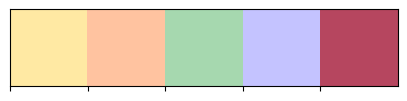

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import ants
from scipy import stats
from pyCompare import blandAltman
import antspynet as apn

# set color palette
colors = ['#FFE9A3','#FFC3A0', '#A6D8AF', '#C4C3FF','#B6465F']

cmap = sns.color_palette(colors)

sns.palplot(cmap)

sns.set_palette(colors)

# boxplot params
plot_params = {
    'notch': False,
    'showcaps': False,
    'width': 0.5,
    'saturation': 1,
    'medianprops': {"color": "coral"},
    'flierprops': {"marker": "x"}
}

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.family'] = 'Arial'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
#plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='normal')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight='bold')  # fontsize of the figure title



In [20]:
# figure_outputs = '../outputs/figures/paper_figures'

original_images_path = '/mnt/leif/littlab/users/cvadali/BIDS_MS_data_02062024'

source_data = '/mnt/leif/littlab/users/cvadali/BIDS_MS_data_02062024'

recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_64mT'

out_synthsr = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSR_skullstripped'

final_LowGAN_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/LowGAN_stage2_outputs_in_hifi'

#final_LowGAN_outputs_s1 = '../source_data/test_set_lofi_6_5_23/derivatives/results/recon_niftis_reshaped_intensity_norm_reshaped'

subjects = os.listdir(final_LowGAN_outputs)
subjects = list(set([x.split('_')[0] for x in subjects]))

# This section compares structural similarity and other image quality metrics across the outputs

### Create SynthSR T1 outputs in the same space as the rest of the images for comparison

### Uncomment to run

In [4]:
import math

# register single image to target
def register_image(source_image, target_image):

    # Perform image registration
    registration_result = ants.registration(
        fixed=target_image,
        moving=source_image,
        type_of_transform="DenseRigid",
        verbose=False
    )

    # Get the registered image
    registered_image = registration_result['warpedmovout']
    
    return registered_image

# pad into a cube
def make_cube(img):
    # this function zero pads the image until it becomes a cube
    x,y,z = img.shape
    max_dim = np.max(img.shape)
    
    to_add_x = (max_dim - x) / 2
    to_add_y = (max_dim - y) / 2
    to_add_z = (max_dim -  z) / 2
    
    zero_padded = np.ones((int(x+(to_add_x*2)), 
                           int(y+(to_add_y*2)), 
                           int(z+(to_add_z*2))))*img[0,0,0]
    
    zero_padded[math.floor(to_add_x):x+math.floor(to_add_x), 
                math.floor(to_add_y):y+math.floor(to_add_y), 
                math.floor(to_add_z):z+math.floor(to_add_z)] = img
    
    return zero_padded

In [11]:
# out_synthsr = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSR_skullstripped'

# if os.path.exists(out_synthsr)==False:
#     os.makedirs(out_synthsr)

# out_recon = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/LowGAN_stage2_outputs_in_hifi'

# if os.path.exists(out_recon)==False:
#     os.makedirs(out_recon)

# modality = 't1'

# for sub in subjects:
#     img_path_hifi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_hifi_'+modality.upper()+'_skullstripped.nii.gz')
#     img_path_lofi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_lofi_'+modality.upper()+'_in_hifi_'+modality.upper()+'_skullstripped.nii.gz')
#     img_path_recon = os.path.join(final_LowGAN_outputs,sub+'_recon_'+modality.lower()+'.nii.gz')
#     img_path_synthsr = os.path.join('/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSR',sub+'_synth_T1.nii.gz')
#     lofi_to_hifi_xfm_path = os.path.join(original_images_path,sub,'derivatives',
#                                         'registered_images',sub+'_lofi_T1_to_hifi_t1_xfm.mat')
#     brainmask = os.path.join(original_images_path, sub, 'derivatives', 'registered_images', sub+'_brainmask.nii.gz')
    
#     if os.path.exists(img_path_synthsr) & os.path.exists(img_path_hifi) & os.path.exists(lofi_to_hifi_xfm_path):
                
#         # hifi
#         hifi_img = ants.image_read(img_path_hifi)
        
#         # recon
#         recon_img = ants.image_read(img_path_recon)
        
#         # synthsr
#         synthsr_img = ants.image_read(img_path_synthsr)

#         # synthsr_img = make_cube((synthsr_img).numpy())

#         print(synthsr_img.shape)

#         recon_in_hifi = register_image(recon_img, hifi_img)

#         synthsr_in_hifi = register_image(synthsr_img, hifi_img)

#         print(f'Registered {sub}')

#         print(hifi_img.shape)

#         print(recon_in_hifi.shape)

#         print(synthsr_in_hifi.shape)

#         #brainmask = apn.brain_extraction(hifi_img,modality='T1'.lower())

#         brainmask = ants.image_read(brainmask)
        
#         # skullstrip
#         synthsr_in_hifi_skullstripped = synthsr_in_hifi * (brainmask.numpy())

#         print(f'Skullstripped {sub}')

#         ants.image_write(recon_in_hifi, os.path.join(out_recon,sub+'_recon_T1.nii.gz'))

#         ants.image_write(synthsr_in_hifi_skullstripped, os.path.join(out_synthsr,sub+'_synth_T1_skullstripped.nii.gz'))

(176, 240, 257)
Registered N037
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)
Skullstripped N037
(177, 240, 257)
Registered P009
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)
Skullstripped P009
(157, 224, 224)
Registered P005
(320, 320, 224)
(320, 320, 224)
(320, 320, 224)
Skullstripped P005
(177, 250, 250)
Registered P023
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
Skullstripped P023
(176, 250, 250)
Registered P031
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
Skullstripped P031
(176, 251, 250)
Registered P056
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
Skullstripped P056
(176, 250, 250)
Registered P052
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
Skullstripped P052
(177, 241, 257)
Registered N019
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)
Skullstripped N019
(176, 240, 256)
Registered N028
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)
Skullstripped N028
(176, 250, 250)
Registered P029
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)
Skullstripped P029
(177, 241,

In [16]:
# out_recon = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/LowGAN_stage2_outputs_in_hifi'

# if os.path.exists(out_recon)==False:
#     os.makedirs(out_recon)

# modalities = ['t2', 'flair']

# for sub in subjects:
#     for modality in modalities:
#         img_path_hifi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_hifi_T1_skullstripped.nii.gz')
#         img_path_recon = os.path.join(final_LowGAN_outputs,sub+'_recon_'+modality.lower()+'.nii.gz')
        
#         if os.path.exists(img_path_hifi) & os.path.exists(img_path_recon):
                    
#             # hifi
#             hifi_img = ants.image_read(img_path_hifi)
            
#             # recon
#             recon_img = ants.image_read(img_path_recon)

#             recon_in_hifi = register_image(recon_img, hifi_img)

#             print(f'Registered {sub}')

#             print(hifi_img.shape)

#             print(recon_in_hifi.shape)

#             print(f'Skullstripped {sub}')

#             ants.image_write(recon_in_hifi, os.path.join(out_recon,f'{sub}_recon_{modality}.nii.gz'))


Registered N037
(240, 256, 176)
(240, 256, 176)
Skullstripped N037
Registered N037
(240, 256, 176)
(240, 256, 176)
Skullstripped N037
Registered P009
(240, 256, 176)
(240, 256, 176)
Skullstripped P009
Registered P009
(240, 256, 176)
(240, 256, 176)
Skullstripped P009
Registered P005
(320, 320, 224)
(320, 320, 224)
Skullstripped P005
Registered P005
(320, 320, 224)
(320, 320, 224)
Skullstripped P005
Registered P023
(176, 256, 256)
(176, 256, 256)
Skullstripped P023
Registered P023
(176, 256, 256)
(176, 256, 256)
Skullstripped P023
Registered P031
(176, 256, 256)
(176, 256, 256)
Skullstripped P031
Registered P031
(176, 256, 256)
(176, 256, 256)
Skullstripped P031
Registered P056
(176, 256, 256)
(176, 256, 256)
Skullstripped P056
Registered P056
(176, 256, 256)
(176, 256, 256)
Skullstripped P056
Registered P052
(176, 256, 256)
(176, 256, 256)
Skullstripped P052
Registered P052
(176, 256, 256)
(176, 256, 256)
Skullstripped P052
Registered N019
(240, 256, 176)
(240, 256, 176)
Skullstripped 

In [17]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def zero_nan(arr):
    arr[np.isnan(arr)] = 0
    return arr

def nan_inf(arr):
    arr[np.isinf(arr)] = np.nan
    return arr

def measure_ssim(array1, array2):
    # Ensure inputs are numpy arrays and of the same shape
    array1 = np.asarray(array1)
    array2 = np.asarray(array2)
    assert array1.shape == array2.shape, "Both arrays must have the same shape"

    # Normalize arrays to the range [0, 255] (required for SSIM calculation)
    array1 = ((array1 - array1.min()) / (array1.max() - array1.min()) * 255).astype(np.uint8)
    array2 = ((array2 - array2.min()) / (array2.max() - array2.min()) * 255).astype(np.uint8)

    # Calculate SSIM
    ssim_score = ssim(array1, array2, data_range=array2.max() - array2.min())

    return ssim_score

def measure_psnr(image1, image2):
    # Ensure inputs are numpy arrays and of the same shape
    assert image1.shape == image2.shape, "Both images must have the same shape"
    
    image1 = ((image1 - image1.min()) / (image1.max() - image1.min()) * 255).astype(np.uint8)
    image2 = ((image2 - image2.min()) / (image2.max() - image2.min()) * 255).astype(np.uint8)
    
    
    # Calculate the squared error
    squared_error = np.square(image1 - image2)

    # Calculate the Mean Squared Error (MSE)
    mse = np.mean(squared_error)

    # Calculate the maximum pixel value of the images
    max_pixel_value = 255.0  # Assuming 8-bit images

    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel_value) - 10 * np.log10(mse)

    return psnr

from scipy.signal import correlate

def normalized_cross_correlation(image1, image2):
    # Ensure inputs are numpy arrays and of the same shape
    image1 = np.asarray(image1)
    image2 = np.asarray(image2)
    assert image1.shape == image2.shape, "Both images must have the same shape"

    # Subtract the mean of each image
    mean1 = image1.mean()
    mean2 = image2.mean()
    image1 -= mean1
    image2 -= mean2

    # Calculate the cross-correlation
    cross_corr = correlate(image1, image2, mode='valid')

    # Calculate the normalized cross-correlation
    norm_cross_corr = cross_corr / (np.sqrt(np.sum(image1**2) * np.sum(image2**2)))

    return norm_cross_corr[0][0][0]


def rescale_intensity_znorm_mean(img, ref_img):
    '''
    this function rescales the intensity of the image using the same min-max procedure from stage 1, and z-normalization 
    procedure from stage 2, which involves z-scoring the image based on values inside an image mask created by values
    above the image mean. The ref_img is the low-field T1, which is used to skullstrip the final output image
    with a threshold of 500.
    '''
    
    # apply the stage 1 rescaling 
    mask = img[ref_img>0]
    
    img_rescale1 = img - np.min(mask) # set lower bound
    img_rescale1 = img_rescale1 / ( np.max(mask) - np.min(mask) ) # set upper bound

    
    
    # apply the stage 2 rescaling
    img_mask_rescale = (img_rescale1>np.mean(img_rescale1))
    img_rescale2 = (img_rescale1-np.mean(img_rescale1[img_mask_rescale]))/(np.std(img_rescale1[img_mask_rescale]))
    
    # get the skullstrip mask
    skullstrip_mask = (ref_img>500)
    
    # apply the final rescaling where we make the lowest value in the image zero
    
    img_rescale3 = img_rescale2 - np.nanmin(img_rescale2)
    
    return img_rescale3*skullstrip_mask

def rescale_intensity_stage1(img, ref_img):
    '''
    this function rescales the intensity of the image using the same min-max procedure from stage 1, and z-normalization 
    procedure from stage 2, which involves z-scoring the image based on values inside an image mask created by values
    above the image mean. The ref_img is the low-field T1, which is used to skullstrip the final output image
    with a threshold of 500.
    '''
    
    # apply the stage 1 rescaling 
    mask = img[ref_img>0]
    
    img_rescale1 = img - np.min(mask) # set lower bound
    img_rescale1 = img_rescale1 / ( np.max(mask) - np.min(mask) ) # set upper bound

    # get the skullstrip mask
    skullstrip_mask = (ref_img>500)
    
    # apply the final rescaling where we make the lowest value in the image zero
    
    img_rescale3 = img_rescale1 - np.nanmin(img_rescale1)
    
    return img_rescale3*skullstrip_mask

def rescale_intensity_stage1_recon(img, ref_img):
    '''
    this function rescales the intensity of the image using the same min-max procedure from stage 1, and z-normalization 
    procedure from stage 2, which involves z-scoring the image based on values inside an image mask created by values
    above the image mean. The ref_img is the low-field T1, which is used to skullstrip the final output image
    with a threshold of 500.
    '''
    
    # apply the stage 1 rescaling 
    mask = img[ref_img>0]
    
    img_rescale1 = img - np.min(mask) # set lower bound
    img_rescale1 = img_rescale1 / ( np.max(mask) - np.min(mask) ) # set upper bound

    # get the skullstrip mask
    skullstrip_mask = (ref_img>0)
    
    # apply the final rescaling where we make the lowest value in the image zero
    
    img_rescale3 = img_rescale1 - np.nanmin(img_rescale1)
    
    return img_rescale3*skullstrip_mask


Define the folders and subjects to analyze

In [19]:
df_ssim = pd.DataFrame()

for modality in ['t1','t2','flair']:
    ssim_hifi_lofi = []
    ssim_hifi_recon = []
    
    psnr_hifi_lofi = []
    psnr_hifi_recon = []
    
    ncc_hifi_lofi = []
    ncc_hifi_recon = []
    
    for sub in tqdm(subjects):

        img_path_hifi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_hifi_'+modality.upper()+'_skullstripped.nii.gz')
        img_path_lofi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_lofi_'+modality.upper()+'_in_hifi_'+modality.upper()+'_skullstripped.nii.gz')
        img_path_recon = os.path.join(final_LowGAN_outputs,sub+'_recon_'+modality.lower()+'.nii.gz')
        #img_path_recon = os.path.join(final_LowGAN_outputs,sub+'_recon_'+modality.lower()+'_axial.nii.gz')

        if os.path.exists(img_path_hifi) and os.path.exists(img_path_lofi) and os.path.exists(img_path_recon):

            img_hifi = nib.load(img_path_hifi).get_fdata()
            img_lofi = nib.load(img_path_lofi).get_fdata()
            img_recon = nib.load(img_path_recon).get_fdata()

            print(sub)
            print(img_hifi.shape)
            print(img_lofi.shape)
            print(img_recon.shape)
            
            # rescale the images
            img_hifi = rescale_intensity_znorm_mean(img_hifi,img_lofi)
            img_lofi = rescale_intensity_znorm_mean(img_lofi,img_lofi)

#             img_hifi = rescale_intensity_stage1(img_hifi,img_lofi)
#             img_lofi = rescale_intensity_stage1(img_lofi,img_lofi)


            ncc_hifi_lofi.append(normalized_cross_correlation(img_hifi, img_lofi))
            ncc_hifi_recon.append(normalized_cross_correlation(img_hifi, img_recon))
            
            psnr_hifi_lofi.append(measure_psnr(img_hifi, img_lofi))
            psnr_hifi_recon.append(measure_psnr(img_hifi, img_recon))
            
            
            ssim_hifi_lofi.append(measure_ssim(img_hifi, img_lofi))
            ssim_hifi_recon.append(measure_ssim(img_hifi, img_recon))

    df_ssim_modality = pd.DataFrame()
    df_ssim_modality['NCC'] = ncc_hifi_lofi + ncc_hifi_recon
    df_ssim_modality['SSIM'] = ssim_hifi_lofi + ssim_hifi_recon
    df_ssim_modality['PSNR'] = psnr_hifi_lofi + psnr_hifi_recon
    df_ssim_modality['Group'] = len(subjects)*['3T-64mT'] + len(subjects)*['3T-LowGAN']
    df_ssim_modality['Modality'] = len(subjects)*2*[modality] 
    df_ssim_modality['Subject'] = subjects + subjects
    
    df_ssim = pd.concat([df_ssim, df_ssim_modality])

  0%|          | 0/57 [00:00<?, ?it/s]

N037
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


  2%|▏         | 1/57 [00:06<06:30,  6.97s/it]

P005
(320, 320, 224)
(320, 320, 224)
(320, 320, 224)


  4%|▎         | 2/57 [00:26<13:08, 14.33s/it]

P009
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


  5%|▌         | 3/57 [00:33<09:56, 11.05s/it]

P023
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  7%|▋         | 4/57 [00:41<08:49,  9.98s/it]

P031
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  9%|▉         | 5/57 [00:50<08:08,  9.39s/it]

P056
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 11%|█         | 6/57 [00:58<07:40,  9.02s/it]

N019
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 12%|█▏        | 7/57 [01:05<07:02,  8.46s/it]

P052
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 14%|█▍        | 8/57 [01:14<06:53,  8.44s/it]

N028
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 16%|█▌        | 9/57 [01:21<06:27,  8.07s/it]

P029
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 18%|█▊        | 10/57 [01:29<06:23,  8.16s/it]

P007
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 19%|█▉        | 11/57 [01:37<06:02,  7.88s/it]

N027
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 21%|██        | 12/57 [01:44<05:44,  7.66s/it]

P024
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 23%|██▎       | 13/57 [01:52<05:43,  7.81s/it]

P061
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 25%|██▍       | 14/57 [02:00<05:41,  7.95s/it]

N029
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 26%|██▋       | 15/57 [02:07<05:23,  7.71s/it]

N022
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 28%|██▊       | 16/57 [02:15<05:10,  7.57s/it]

P051
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 30%|██▉       | 17/57 [02:23<05:12,  7.82s/it]

N035
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 32%|███▏      | 18/57 [02:30<04:55,  7.57s/it]

N032
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 33%|███▎      | 19/57 [02:37<04:42,  7.42s/it]

P046
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 35%|███▌      | 20/57 [02:45<04:43,  7.66s/it]

P053
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 37%|███▋      | 21/57 [02:54<04:44,  7.91s/it]

P044
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 39%|███▊      | 22/57 [03:02<04:41,  8.06s/it]

P050
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 40%|████      | 23/57 [03:10<04:35,  8.11s/it]

P016
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 42%|████▏     | 24/57 [03:17<04:16,  7.76s/it]

P032
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 44%|████▍     | 25/57 [03:26<04:15,  7.98s/it]

P014
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 46%|████▌     | 26/57 [03:33<03:59,  7.72s/it]

N024
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 47%|████▋     | 27/57 [03:40<03:45,  7.51s/it]

N030
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 49%|████▉     | 28/57 [03:47<03:34,  7.40s/it]

P001
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 51%|█████     | 29/57 [03:54<03:24,  7.30s/it]

P026
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 53%|█████▎    | 30/57 [04:03<03:25,  7.62s/it]

N040
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 54%|█████▍    | 31/57 [04:10<03:15,  7.51s/it]

N031
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 56%|█████▌    | 32/57 [04:17<03:05,  7.43s/it]

N042
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 58%|█████▊    | 33/57 [04:24<02:56,  7.36s/it]

N034
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 60%|█████▉    | 34/57 [04:31<02:48,  7.31s/it]

P059
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 61%|██████▏   | 35/57 [04:40<02:46,  7.58s/it]

P041
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 63%|██████▎   | 36/57 [04:48<02:43,  7.79s/it]

P015
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 65%|██████▍   | 37/57 [04:55<02:31,  7.59s/it]

P054
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 67%|██████▋   | 38/57 [05:03<02:28,  7.80s/it]

P043
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 68%|██████▊   | 39/57 [05:11<02:22,  7.89s/it]

P049
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 70%|███████   | 40/57 [05:20<02:16,  8.01s/it]

P042
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 72%|███████▏  | 41/57 [05:28<02:09,  8.09s/it]

P030
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 74%|███████▎  | 42/57 [05:36<02:02,  8.14s/it]

N025
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 75%|███████▌  | 43/57 [05:43<01:49,  7.82s/it]

N038
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 77%|███████▋  | 44/57 [05:50<01:38,  7.60s/it]

N033
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 79%|███████▉  | 45/57 [05:58<01:29,  7.47s/it]

P013
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 81%|████████  | 46/57 [06:05<01:21,  7.38s/it]

N023
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 82%|████████▏ | 47/57 [06:12<01:13,  7.34s/it]

P033
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 84%|████████▍ | 48/57 [06:20<01:08,  7.61s/it]

P038
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 86%|████████▌ | 49/57 [06:29<01:02,  7.81s/it]

P011
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 88%|████████▊ | 50/57 [06:36<00:53,  7.63s/it]

P062
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 89%|████████▉ | 51/57 [06:44<00:46,  7.82s/it]

P027
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 91%|█████████ | 52/57 [06:52<00:39,  7.96s/it]

P025
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 93%|█████████▎| 53/57 [07:01<00:32,  8.07s/it]

N041
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 95%|█████████▍| 54/57 [07:08<00:23,  7.72s/it]

P047
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 96%|█████████▋| 55/57 [07:16<00:15,  7.87s/it]

N039
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 98%|█████████▊| 56/57 [07:23<00:07,  7.67s/it]

P028
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  0%|          | 0/57 [00:00<?, ?it/s]

N037
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


  2%|▏         | 1/57 [00:07<06:38,  7.12s/it]

P005
(320, 320, 224)
(320, 320, 224)
(320, 320, 224)


  4%|▎         | 2/57 [00:26<13:00, 14.19s/it]

P009
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


  5%|▌         | 3/57 [00:33<09:48, 10.89s/it]

P023
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  7%|▋         | 4/57 [00:41<08:39,  9.80s/it]

P031
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  9%|▉         | 5/57 [00:49<07:57,  9.18s/it]

P056
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 11%|█         | 6/57 [00:57<07:29,  8.81s/it]

N019
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 12%|█▏        | 7/57 [01:04<06:51,  8.23s/it]

P052
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 14%|█▍        | 8/57 [01:12<06:42,  8.21s/it]

N028
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 16%|█▌        | 9/57 [01:19<06:14,  7.80s/it]

P029
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 18%|█▊        | 10/57 [01:27<06:13,  7.95s/it]

P007
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 19%|█▉        | 11/57 [01:34<05:52,  7.66s/it]

N027
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 21%|██        | 12/57 [01:41<05:34,  7.44s/it]

P024
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 23%|██▎       | 13/57 [01:50<05:43,  7.80s/it]

P061
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 25%|██▍       | 14/57 [01:58<05:39,  7.90s/it]

N029
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 26%|██▋       | 15/57 [02:05<05:19,  7.60s/it]

N022
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 28%|██▊       | 16/57 [02:12<05:04,  7.44s/it]

P051
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 30%|██▉       | 17/57 [02:20<05:04,  7.61s/it]

N035
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 32%|███▏      | 18/57 [02:27<04:49,  7.42s/it]

N032
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 33%|███▎      | 19/57 [02:34<04:36,  7.27s/it]

P046
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 35%|███▌      | 20/57 [02:42<04:38,  7.51s/it]

P053
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 37%|███▋      | 21/57 [02:50<04:37,  7.72s/it]

P044
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 39%|███▊      | 22/57 [02:58<04:35,  7.87s/it]

P050
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 40%|████      | 23/57 [03:06<04:28,  7.90s/it]

P016
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 42%|████▏     | 24/57 [03:13<04:11,  7.62s/it]

P032
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 44%|████▍     | 25/57 [03:22<04:09,  7.80s/it]

P014
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 46%|████▌     | 26/57 [03:29<03:54,  7.58s/it]

N024
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 47%|████▋     | 27/57 [03:36<03:41,  7.37s/it]

N030
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 49%|████▉     | 28/57 [03:43<03:29,  7.23s/it]

P001
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 51%|█████     | 29/57 [03:49<03:19,  7.14s/it]

P026
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 53%|█████▎    | 30/57 [03:58<03:20,  7.43s/it]

N040
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 54%|█████▍    | 31/57 [04:05<03:09,  7.29s/it]

N031
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 56%|█████▌    | 32/57 [04:11<02:59,  7.19s/it]

N042
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 58%|█████▊    | 33/57 [04:19<02:51,  7.15s/it]

N034
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 60%|█████▉    | 34/57 [04:25<02:42,  7.08s/it]

P059
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 61%|██████▏   | 35/57 [04:34<02:42,  7.39s/it]

P041
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 63%|██████▎   | 36/57 [04:42<02:40,  7.62s/it]

P015
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 65%|██████▍   | 37/57 [04:49<02:29,  7.49s/it]

P054
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 67%|██████▋   | 38/57 [04:57<02:25,  7.68s/it]

P043
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 68%|██████▊   | 39/57 [05:05<02:20,  7.81s/it]

P049
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 70%|███████   | 40/57 [05:13<02:14,  7.92s/it]

P042
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 72%|███████▏  | 41/57 [05:21<02:07,  7.97s/it]

P030
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 74%|███████▎  | 42/57 [05:30<02:02,  8.19s/it]

N025
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 75%|███████▌  | 43/57 [05:37<01:49,  7.83s/it]

N038
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 77%|███████▋  | 44/57 [05:44<01:38,  7.55s/it]

N033
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 79%|███████▉  | 45/57 [05:51<01:28,  7.37s/it]

P013
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 81%|████████  | 46/57 [05:58<01:20,  7.34s/it]

N023
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 82%|████████▏ | 47/57 [06:05<01:12,  7.28s/it]

P033
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 84%|████████▍ | 48/57 [06:14<01:08,  7.59s/it]

P038
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 86%|████████▌ | 49/57 [06:22<01:01,  7.74s/it]

P011
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 88%|████████▊ | 50/57 [06:29<00:53,  7.60s/it]

P062
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 89%|████████▉ | 51/57 [06:37<00:46,  7.77s/it]

P027
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 91%|█████████ | 52/57 [06:45<00:39,  7.91s/it]

P025
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 93%|█████████▎| 53/57 [06:54<00:31,  7.98s/it]

N041
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 95%|█████████▍| 54/57 [07:01<00:22,  7.66s/it]

P047
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 96%|█████████▋| 55/57 [07:09<00:15,  7.78s/it]

N039
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 98%|█████████▊| 56/57 [07:16<00:07,  7.55s/it]

P028
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  0%|          | 0/57 [00:00<?, ?it/s]

N037
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


  2%|▏         | 1/57 [00:07<06:39,  7.14s/it]

P005
(320, 320, 224)
(320, 320, 224)
(320, 320, 224)


  4%|▎         | 2/57 [00:26<12:58, 14.15s/it]

P009
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


  5%|▌         | 3/57 [00:33<09:47, 10.89s/it]

P023
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  7%|▋         | 4/57 [00:41<08:43,  9.87s/it]

P031
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


  9%|▉         | 5/57 [00:49<07:58,  9.20s/it]

P056
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 11%|█         | 6/57 [00:57<07:31,  8.85s/it]

N019
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 12%|█▏        | 7/57 [01:05<06:57,  8.35s/it]

P052
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 14%|█▍        | 8/57 [01:13<06:47,  8.32s/it]

N028
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 16%|█▌        | 9/57 [01:20<06:19,  7.90s/it]

P029
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 18%|█▊        | 10/57 [01:28<06:16,  8.01s/it]

P007
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 19%|█▉        | 11/57 [01:35<05:57,  7.76s/it]

N027
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 21%|██        | 12/57 [01:42<05:37,  7.51s/it]

P024
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 23%|██▎       | 13/57 [01:50<05:41,  7.75s/it]

P061
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 25%|██▍       | 14/57 [01:59<05:37,  7.85s/it]

N029
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 26%|██▋       | 15/57 [02:05<05:17,  7.57s/it]

N022
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 28%|██▊       | 16/57 [02:13<05:04,  7.43s/it]

P051
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 30%|██▉       | 17/57 [02:21<05:04,  7.62s/it]

N035
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 32%|███▏      | 18/57 [02:28<04:52,  7.49s/it]

N032
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 33%|███▎      | 19/57 [02:35<04:39,  7.35s/it]

P046
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 35%|███▌      | 20/57 [02:43<04:37,  7.51s/it]

P053
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 37%|███▋      | 21/57 [02:51<04:38,  7.73s/it]

P044
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 39%|███▊      | 22/57 [02:59<04:38,  7.94s/it]

P050
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 40%|████      | 23/57 [03:08<04:33,  8.05s/it]

P016
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 42%|████▏     | 24/57 [03:15<04:16,  7.77s/it]

P032
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 44%|████▍     | 25/57 [03:23<04:16,  8.00s/it]

P014
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 46%|████▌     | 26/57 [03:30<03:59,  7.74s/it]

N024
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 47%|████▋     | 27/57 [03:38<03:49,  7.63s/it]

N030
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 49%|████▉     | 28/57 [03:45<03:36,  7.48s/it]

P001
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 51%|█████     | 29/57 [03:52<03:25,  7.35s/it]

P026
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 53%|█████▎    | 30/57 [04:00<03:24,  7.59s/it]

N040
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 54%|█████▍    | 31/57 [04:08<03:16,  7.55s/it]

N031
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 56%|█████▌    | 32/57 [04:15<03:05,  7.40s/it]

N042
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 58%|█████▊    | 33/57 [04:22<02:55,  7.31s/it]

N034
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 60%|█████▉    | 34/57 [04:29<02:47,  7.28s/it]

P059
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 61%|██████▏   | 35/57 [04:37<02:46,  7.59s/it]

P041
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 63%|██████▎   | 36/57 [04:46<02:45,  7.88s/it]

P015
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 65%|██████▍   | 37/57 [04:53<02:33,  7.67s/it]

P054
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 67%|██████▋   | 38/57 [05:01<02:28,  7.81s/it]

P043
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 68%|██████▊   | 39/57 [05:09<02:23,  7.95s/it]

P049
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 70%|███████   | 40/57 [05:18<02:17,  8.10s/it]

P042
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 72%|███████▏  | 41/57 [05:26<02:09,  8.12s/it]

P030
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 74%|███████▎  | 42/57 [05:34<02:02,  8.14s/it]

N025
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 75%|███████▌  | 43/57 [05:41<01:48,  7.78s/it]

N038
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 77%|███████▋  | 44/57 [05:48<01:38,  7.61s/it]

N033
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 79%|███████▉  | 45/57 [05:56<01:30,  7.55s/it]

P013
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 81%|████████  | 46/57 [06:03<01:21,  7.40s/it]

N023
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 82%|████████▏ | 47/57 [06:10<01:13,  7.31s/it]

P033
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 84%|████████▍ | 48/57 [06:18<01:08,  7.56s/it]

P038
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 86%|████████▌ | 49/57 [06:26<01:01,  7.71s/it]

P011
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 88%|████████▊ | 50/57 [06:33<00:52,  7.53s/it]

P062
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 89%|████████▉ | 51/57 [06:41<00:46,  7.73s/it]

P027
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 91%|█████████ | 52/57 [06:50<00:39,  7.93s/it]

P025
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 93%|█████████▎| 53/57 [06:58<00:32,  8.04s/it]

N041
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 95%|█████████▍| 54/57 [07:05<00:23,  7.77s/it]

P047
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


 96%|█████████▋| 55/57 [07:13<00:15,  7.86s/it]

N039
(240, 256, 176)
(240, 256, 176)
(240, 256, 176)


 98%|█████████▊| 56/57 [07:20<00:07,  7.61s/it]

P028
(176, 256, 256)
(176, 256, 256)
(176, 256, 256)


100%|██████████| 57/57 [07:29<00:00,  7.89s/it]


In [21]:
ncc_hifi_synthseg = []
ssim_hifi_synthseg = []

# add the synthseg segmentations
for sub in tqdm(subjects):

    img_path_hifi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_hifi_'+modality.upper()+'_skullstripped.nii.gz')
    img_path_synthseg = os.path.join(out_synthsr,sub+'_synth_T1_skullstripped.nii.gz') 

    if os.path.exists(img_path_hifi) and os.path.exists(img_path_synthseg):

        img_hifi = nib.load(img_path_hifi).get_fdata()
        img_synthseg = nib.load(img_path_synthseg).get_fdata()

        ncc_hifi_synthseg.append(normalized_cross_correlation(img_hifi, img_synthseg))
        
        ssim_hifi_synthseg.append(measure_ssim(img_hifi, img_synthseg))
        
df_ssim_modality = pd.DataFrame()
df_ssim_modality['NCC'] = ncc_hifi_synthseg
df_ssim_modality['SSIM'] = ssim_hifi_synthseg
df_ssim_modality['Group'] = len(subjects)*['3T-SynthSeg']
df_ssim_modality['Modality'] = len(subjects)*['t1'] 
df_ssim_modality['Subject'] = subjects

df_ssim = pd.concat([df_ssim, df_ssim_modality])

100%|██████████| 57/57 [03:06<00:00,  3.28s/it]


In [22]:
df_ssim_melted = pd.melt(df_ssim, id_vars=['Group','Subject','NCC','SSIM','PSNR'], value_name='Modality').drop('variable', axis=1)

/tmp/ipykernel_50681/2838976461.py:1: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



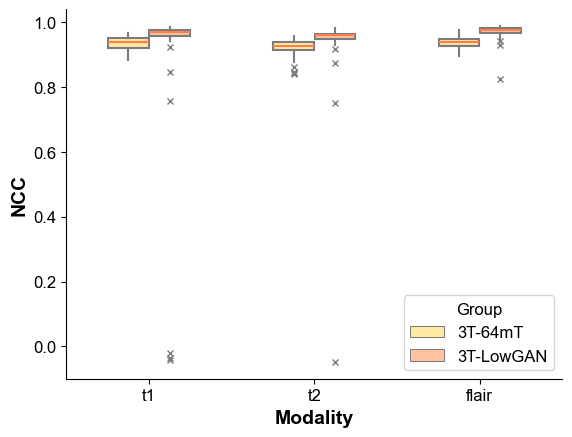

In [23]:
sns.boxplot(x='Modality', y='NCC', hue='Group', data=df_ssim_melted[df_ssim_melted['Group']!='3T-SynthSeg'], **plot_params)
sns.despine()

In [24]:
a = df_ssim_melted[(df_ssim_melted['Group']=='3T-64mT')&(df_ssim_melted['Modality']=='t1')]['NCC'].values
b = df_ssim_melted[(df_ssim_melted['Group']=='3T-LowGAN')&(df_ssim_melted['Modality']=='t1')]['NCC'].values


stats.ttest_1samp(a-b, popmean=0)

TtestResult(statistic=0.799048366884037, pvalue=0.42763848734703036, df=56)

In [25]:
a = df_ssim_melted[(df_ssim_melted['Group']=='3T-64mT')&(df_ssim_melted['Modality']=='flair')]['NCC'].values
b = df_ssim_melted[(df_ssim_melted['Group']=='3T-LowGAN')&(df_ssim_melted['Modality']=='flair')]['NCC'].values


stats.ttest_1samp(a-b, popmean=0)

TtestResult(statistic=-9.654512289044247, pvalue=1.6093046793321836e-13, df=56)

In [26]:
a = df_ssim_melted[(df_ssim_melted['Group']=='3T-64mT')&(df_ssim_melted['Modality']=='t2')]['NCC'].values
b = df_ssim_melted[(df_ssim_melted['Group']=='3T-LowGAN')&(df_ssim_melted['Modality']=='t2')]['NCC'].values


stats.ttest_1samp(a-b, popmean=0)

TtestResult(statistic=-0.8157238846443207, pvalue=0.4181142286268372, df=56)

### Compute the NCC across the axial, coronal and sagittal planes from stage 1

In [747]:
final_LowGAN_outputs_s1 = '../source_data/test_set_lofi_V2_6_5_23/derivatives/results/recon_niftis_reshaped_reshaped'

df_metric_s1 = pd.DataFrame()

for modality in ['t1','t2','flair']:
    ssim_hifi_lofi = []
    ssim_hifi_recon = []
    
    psnr_lofi_hifi = []
    psnr_recon_hifi = []
    
    ncc_lofi_hifi = []
    ncc_recon_hifi_axial = []
    ncc_recon_hifi_coronal = []
    ncc_recon_hifi_sagittal = []
    ncc_recon_s2 = []
    
    for sub in tqdm(subjects):

        img_path_hifi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_hifi_'+modality.upper()+'_skullstripped.nii.gz')
        img_path_lofi = os.path.join(original_images_path,sub,'derivatives','registered_images',sub+'_lofi_'+modality.upper()+'_in_hifi_'+modality.upper()+'_skullstripped.nii.gz')
        img_path_recon = os.path.join(final_LowGAN_outputs,sub+'_recon_'+modality.lower()+'.nii.gz')
        img_path_recon_axial = os.path.join(final_LowGAN_outputs_s1,sub+'_recon_'+modality.lower()+'_axial.nii.gz')
        img_path_recon_coronal = os.path.join(final_LowGAN_outputs_s1,sub+'_recon_'+modality.lower()+'_coronal.nii.gz')
        img_path_recon_sagittal = os.path.join(final_LowGAN_outputs_s1,sub+'_recon_'+modality.lower()+'_sagittal.nii.gz')

        if os.path.exists(img_path_hifi) and os.path.exists(img_path_lofi) and os.path.exists(img_path_recon_axial) and os.path.exists(img_path_recon_coronal) and os.path.exists(img_path_recon_sagittal):

            img_hifi = nib.load(img_path_hifi).get_fdata()
            img_lofi = nib.load(img_path_lofi).get_fdata()
            
            img_recon_axial = nib.load(img_path_recon_axial).get_fdata()
            img_recon_coronal = nib.load(img_path_recon_coronal).get_fdata()
            img_recon_sagittal = nib.load(img_path_recon_sagittal).get_fdata()
            img_recon = nib.load(img_path_recon).get_fdata()
            # rescale the images
            img_hifi = rescale_intensity_stage1(img_hifi,img_lofi)
            img_lofi = rescale_intensity_stage1(img_lofi,img_lofi)
            

#             print(stats.pearsonr(img_lofi[img_recon_axial>0].ravel(), img_hifi[img_recon_axial>0].ravel())[0])
#             print(stats.pearsonr(img_recon_axial[img_recon_axial>0].ravel(), img_hifi[img_recon_axial>0].ravel())[0])

#             ncc_lofi_hifi.append(stats.pearsonr(img_lofi[img_recon_axial>0].ravel(), img_hifi[img_recon_axial>0].ravel())[0])
#             ncc_recon_hifi_axial.append(stats.pearsonr(img_recon_axial[img_recon_axial>0].ravel(), img_hifi[img_recon_axial>0].ravel())[0])
           
#             ncc_recon_hifi_coronal.append(stats.pearsonr(img_recon_coronal[img_recon_coronal>0].ravel(), img_hifi[img_recon_coronal>0].ravel())[0])
            
#             ncc_recon_hifi_sagittal.append(stats.pearsonr(img_recon_sagittal[img_recon_sagittal>0].ravel(), img_hifi[img_recon_sagittal>0].ravel())[0])

            ncc_lofi_hifi.append(normalized_cross_correlation(img_lofi, img_hifi))
            ncc_recon_hifi_axial.append(normalized_cross_correlation(img_recon_axial, img_hifi))
           
            ncc_recon_hifi_coronal.append(normalized_cross_correlation(img_recon_coronal, img_hifi))            
            
            ncc_recon_hifi_sagittal.append(normalized_cross_correlation(img_recon_sagittal, img_hifi))
            
            ncc_recon_s2.append(normalized_cross_correlation(img_recon, img_hifi))
            
        else:
            print('Subject ', sub, ', does not exist')
            
    df_metric_s1_modality = pd.DataFrame()
    #df_metric_s1_modality['NCC'] = ncc_hifi_lofi + ncc_hifi_recon
    #df_metric_s1_modality['SSIM'] = ssim_hifi_lofi + ssim_hifi_recon
    df_metric_s1_modality['NCC'] = ncc_lofi_hifi + ncc_recon_hifi_axial + ncc_recon_hifi_coronal + ncc_recon_hifi_sagittal + ncc_recon_s2
    df_metric_s1_modality['Group'] = len(subjects)*['3T-64mT'] + len(subjects)*['3T-LowGAN - S1 Axial'] + len(subjects)*['3T-LowGAN - S1 Coronal'] + len(subjects)*['3T-LowGAN - S1 Sagittal'] + len(subjects)*['3T-LowGAN - S2']
    df_metric_s1_modality['Modality'] = len(subjects)*5*[modality] 
    df_metric_s1_modality['Subject'] = subjects*5

    df_metric_s1 = pd.concat([df_metric_s1, df_metric_s1_modality])
            

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.60s/it]


In [748]:
stats.spearmanr(img_recon_axial[:,100,:].ravel(),img_hifi[:,100,:].ravel())

SpearmanrResult(correlation=0.9445143942442299, pvalue=0.0)

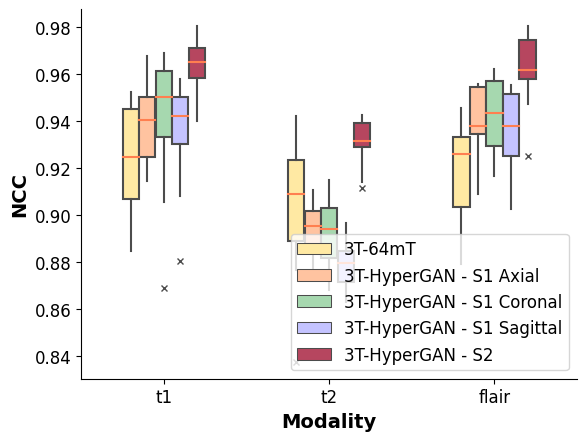

In [749]:
sns.boxplot(x='Modality',y='NCC',hue='Group',data=df_metric_s1, **plot_params)
plt.legend(loc='lower right')
sns.despine()

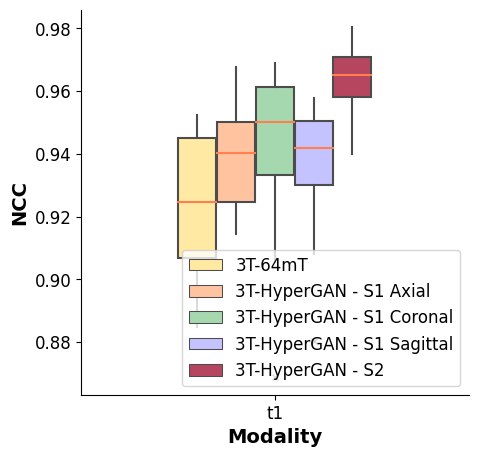

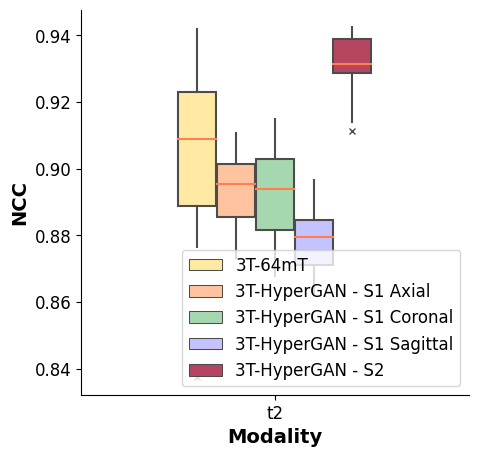

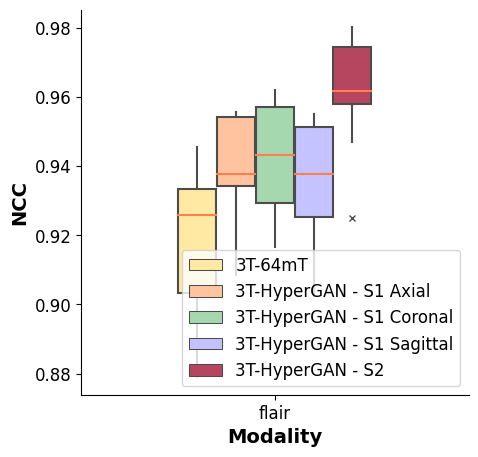

In [766]:
plt.figure(figsize=(5,5))
sns.boxplot(x='Modality',y='NCC',hue='Group',data=df_metric_s1[df_metric_s1['Modality']=='t1'], **plot_params)
plt.legend(loc='lower right')
sns.despine()

plt.figure(figsize=(5,5))
sns.boxplot(x='Modality',y='NCC',hue='Group',data=df_metric_s1[df_metric_s1['Modality']=='t2'], **plot_params)
plt.legend(loc='lower right')
sns.despine()

plt.figure(figsize=(5,5))
sns.boxplot(x='Modality',y='NCC',hue='Group',data=df_metric_s1[df_metric_s1['Modality']=='flair'], **plot_params)
plt.legend(loc='lower right')
sns.despine()


---------T1w---------
Lofi-Axial: t-test p-val, bonf(X4) 0.3796842609692809 Cohen's d:  -0.7669855564558785
NCC difference:  -0.01552548354399171 +/- 0.008135718433921494 

Lofi-Coronal: t-test p-val, bonf(X4) 0.6345237678089325 Cohen's d:  -0.6640848965089012
NCC difference:  -0.01780473569517561 +/- 0.011271693504318218 

Lofi-Sagittal: t-test p-val, bonf(X4) 1.0213684033201498 Cohen's d:  -0.5105357832764671
NCC difference:  -0.011878375093119361 +/- 0.009477143344813619 

Lofi-S2: t-test p-val, bonf(X4) 0.0012290607617157351 Cohen's d:  -2.2201483226406458
NCC difference:  -0.040844011046617806 +/- 0.007560076337727523 


---------T2w---------
Lofi-Axial: t-test p-val, bonf(X4) 0.6510355546539303 Cohen's d:  0.5213236435896218
NCC difference:  0.011764303889157288 +/- 0.007528595859266623 

Lofi-Coronal: t-test p-val, bonf(X4) 0.656544578325985 Cohen's d:  0.4786396967387528
NCC difference:  0.011283921778717168 +/- 0.007247067976411016 

Lofi-Sagittal: t-test p-val, bonf(X4) 0.01

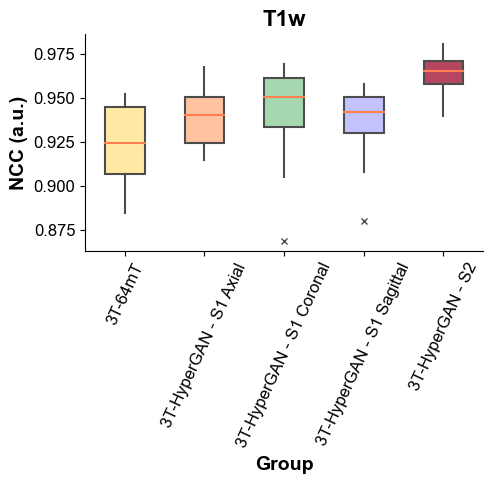

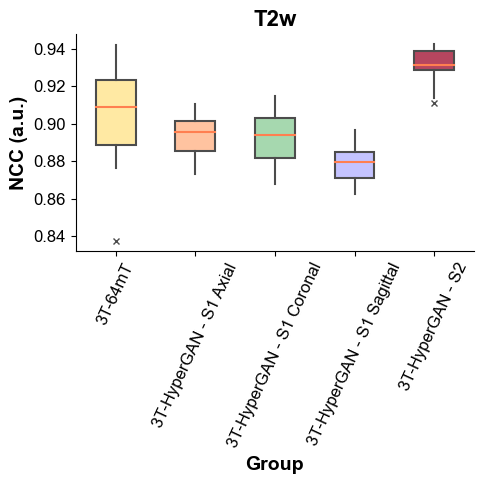

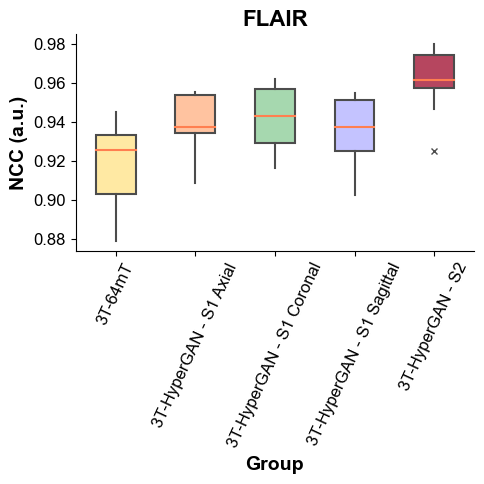

In [921]:
def ncc_difference(group1, group2):
    
    diff = group1-group2
    
    n1 = len(group1)
    n2 = len(group2)
    
    sd1 = np.std(group1)
    sd2 = np.std(group2)
    
    SE = np.std(diff)/np.sqrt(n1)
    
    vol_difference = np.mean(diff)

    return print('NCC difference: ',vol_difference, '+/-', SE,'\n')



plt.figure(figsize=(5,5))
ax = sns.boxplot(x='Group',y='NCC',hue='Group',data=df_metric_s1[df_metric_s1['Modality']=='t1'], **plot_params, dodge=False)
plt.legend(loc='lower right')
plt.ylabel('NCC (a.u.)')
ax.legend_.remove()
plt.xticks(rotation=65)
sns.despine()
plt.title('T1w')
plt.tight_layout()
plt.savefig(os.path.join(figure_outputs,'ncc_t1.pdf'))
print('\n---------T1w---------')
t2 = df_metric_s1[df_metric_s1['Modality']=='t1']
t2_lofi = t2[t2['Group']=='3T-64mT']['NCC']
t2_axial = t2[t2['Group']=='3T-LowGAN - S1 Axial']['NCC']
t2_coronal = t2[t2['Group']=='3T-LowGAN - S1 Coronal']['NCC']
t2_sagittal = t2[t2['Group']=='3T-LowGAN - S1 Sagittal']['NCC']
t2_s2 = t2[t2['Group']=='3T-LowGAN - S2']['NCC']

print("Lofi-Axial: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_axial.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_axial))
ncc_difference(t2_lofi.values,t2_axial.values)

print("Lofi-Coronal: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_coronal.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_coronal))
ncc_difference(t2_lofi.values,t2_coronal.values)

print("Lofi-Sagittal: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_sagittal.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_sagittal))
ncc_difference(t2_lofi.values,t2_sagittal.values)

print("Lofi-S2: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_s2.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_s2))
ncc_difference(t2_lofi.values,t2_s2.values)

plt.figure(figsize=(5,5))
ax = sns.boxplot(x='Group',y='NCC',hue='Group',data=df_metric_s1[df_metric_s1['Modality']=='t2'], **plot_params, dodge=False)
plt.legend(loc='lower right')
plt.ylabel('NCC (a.u.)')
ax.legend_.remove()
plt.xticks(rotation=65)
sns.despine()
plt.title('T2w')
plt.tight_layout()
plt.savefig(os.path.join(figure_outputs,'ncc_t2.pdf'))
print('\n---------T2w---------')
t2 = df_metric_s1[df_metric_s1['Modality']=='t2']
t2_lofi = t2[t2['Group']=='3T-64mT']['NCC']
t2_axial = t2[t2['Group']=='3T-LowGAN - S1 Axial']['NCC']
t2_coronal = t2[t2['Group']=='3T-LowGAN - S1 Coronal']['NCC']
t2_sagittal = t2[t2['Group']=='3T-LowGAN - S1 Sagittal']['NCC']
t2_s2 = t2[t2['Group']=='3T-LowGAN - S2']['NCC']

print("Lofi-Axial: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_axial.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_axial))
ncc_difference(t2_lofi.values,t2_axial.values)

print("Lofi-Coronal: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_coronal.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_coronal))
ncc_difference(t2_lofi.values,t2_coronal.values)

print("Lofi-Sagittal: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_sagittal.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_sagittal))
ncc_difference(t2_lofi.values,t2_sagittal.values)

print("Lofi-S2: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_s2.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_s2))
ncc_difference(t2_lofi.values,t2_s2.values)



plt.figure(figsize=(5,5))
ax = sns.boxplot(x='Group',y='NCC',hue='Group',data=df_metric_s1[df_metric_s1['Modality']=='flair'], **plot_params, dodge=False)
plt.legend(loc='lower right')
plt.ylabel('NCC (a.u.)')
ax.legend_.remove()
plt.xticks(rotation=65)
sns.despine()
plt.title('FLAIR')
plt.tight_layout()
plt.savefig(os.path.join(figure_outputs,'ncc_flair.pdf'))

print('\n---------FLAIR---------')
t2 = df_metric_s1[df_metric_s1['Modality']=='flair']
t2_lofi = t2[t2['Group']=='3T-64mT']['NCC']
t2_axial = t2[t2['Group']=='3T-LowGAN - S1 Axial']['NCC']
t2_coronal = t2[t2['Group']=='3T-LowGAN - S1 Coronal']['NCC']
t2_sagittal = t2[t2['Group']=='3T-LowGAN - S1 Sagittal']['NCC']
t2_s2 = t2[t2['Group']=='3T-LowGAN - S2']['NCC']

print("Lofi-Axial: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_axial.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_axial))
ncc_difference(t2_lofi.values,t2_axial.values)

print("Lofi-Coronal: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_coronal.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_coronal))
ncc_difference(t2_lofi.values,t2_coronal.values)

print("Lofi-Sagittal: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_sagittal.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_sagittal))
ncc_difference(t2_lofi.values,t2_sagittal.values)

print("Lofi-S2: t-test p-val, bonf(X4)",stats.ttest_1samp(t2_lofi.values-t2_s2.values, popmean=0)[1]*4,"Cohen's d: ",cohen_d(t2_lofi,t2_s2))
ncc_difference(t2_lofi.values,t2_s2.values)


In [806]:
t2 = df_metric_s1[df_metric_s1['Modality']=='t2']
t2_lofi = t2[t2['Group']=='3T-64mT']['NCC']
t2_axial = t2[t2['Group']=='3T-LowGAN - S1 Axial']['NCC']
t2_coronal = t2[t2['Group']=='3T-LowGAN - S1 Coronal']['NCC']
t2_sagittal = t2[t2['Group']=='3T-LowGAN - S1 Sagittal']['NCC']
t2_s2 = t2[t2['Group']=='3T-LowGAN - S2']['NCC']

print("Lofi-Axial: t-test",stats.ttest_1samp(t2_lofi.values-t2_axial.values, popmean=0),"Cohen's d: ",cohen_d(t2_lofi,t2_axial))
print("Lofi-Coronal: t-test",stats.ttest_1samp(t2_lofi.values-t2_coronal.values, popmean=0),"Cohen's d: ",cohen_d(t2_lofi,t2_coronal))
print("Lofi-Sagittal: t-test",stats.ttest_1samp(t2_lofi.values-t2_sagittal.values, popmean=0),"Cohen's d: ",cohen_d(t2_lofi,t2_sagittal))
print("Lofi-S2: t-test",stats.ttest_1samp(t2_lofi.values-t2_s2.values, popmean=0),"Cohen's d: ",cohen_d(t2_lofi,t2_s2))


Lofi-Axial: t-test Ttest_1sampResult(statistic=1.496090859160516, pvalue=0.16275888866348256) Cohen's d:  0.5213236435896218
Lofi-Coronal: t-test Ttest_1sampResult(statistic=1.49074530940114, pvalue=0.16413614458149625) Cohen's d:  0.4786396967387528
Lofi-Sagittal: t-test Ttest_1sampResult(statistic=3.649006954292957, pvalue=0.0038273671276637658) Cohen's d:  1.1584188942120193
Lofi-S2: t-test Ttest_1sampResult(statistic=-2.8933747164873056, pvalue=0.01461733405996621) Cohen's d:  -1.2205247425943344


### Compute the perceptual loss

In [202]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
import sys
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from datetime import datetime

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

# Load the VGG16 model
vgg16_model = vgg16(pretrained=True).to(device)

# Extract the convolutional layers
features = vgg16_model.features

# Create a new sequential model that contains only the convolutional layers
conv_model = nn.Sequential(*list(features.children())[:23])
#conv_model.to_device(device)
# Freeze the parameters in the convolutional model
for param in conv_model.parameters():
    param.requires_grad = False

# Define the 3D perceptual loss function
def perceptual_loss_3d(fake_images, real_images):
    # Get the feature representations of the fake and real images
    fake_features = conv_model(fake_images)
    real_features = conv_model(real_images)
    
    # Compute the mean square error (MSE) between the feature representations
    mse_loss = nn.MSELoss()
    loss = mse_loss(fake_features, real_features)
    
    return loss

class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super(PerceptualLoss, self).__init__()
        self.device = device
    
    def forward(self, input, target, sum_layers=True):
        
        zsize = np.size(target.data,2)
        
        # divided by 10 sets MSE and Perceptual magnitudes equal initially
        mse_loss = nn.MSELoss()
        res = mse_loss(input, target)
        print(res)
        # Set VGG16 mean and stdev
        mean0, mean1, mean2 = 0.485, 0.456, 0.406
        std0, std1, std2 = 0.229, 0.224, 0.225

        # Rescale training batch mean and stdev to match VGG16
        input = input - torch.mean(input[:]) 
        
        target = target - torch.mean(target[:])

        input2 = input.clone()
        input2 = input2.expand(-1,3,-1,-1,-1)
        input2[:,0,:,:,:] = mean0+std0*(input2[:,0,:,:,:].clone())/torch.std(input[:])#.data
        input2[:,1,:,:,:] = mean1+std1*(input2[:,0,:,:,:].clone())/torch.std(input[:])#.data
        input2[:,2,:,:,:] = mean2+std2*(input2[:,0,:,:,:].clone())/torch.std(input[:])#.data

        target2 = target.clone()
        target2 = target2.expand(-1,3,-1,-1,-1)
        target2[:,0,:,:,:] = mean0+std0*(target2[:,0,:,:,:].clone())/torch.std(target[:])#.data
        target2[:,1,:,:,:] = mean1+std1*(target2[:,0,:,:,:].clone())/torch.std(target[:])#.data
        target2[:,2,:,:,:] = mean2+std2*(target2[:,0,:,:,:].clone())/torch.std(target[:])#.data
            
        # Loop over each slice in each dimension
        for ii in range(zsize):
            
            input3z = torch.squeeze(input2[:,:,:,:,ii]).to(self.device)
            target3z = torch.squeeze(target2[:,:,:,:,ii]).to(self.device)
            res+= perceptual_loss_3d(input3z, target3z)
        for ii in range(zsize):
            
            input3y = torch.squeeze(input2[:,:,:,ii,:]).to(self.device)
            target3y = torch.squeeze(target2[:,:,:,ii,:]).to(self.device)
            res+= perceptual_loss_3d(input3y, target3y)
                                    
        for ii in range(zsize):
                    
            input3x = torch.squeeze(input2[:,:,ii,:,:]).to(self.device)
            target3x = torch.squeeze(target2[:,:,ii,:,:]).to(self.device)
            res+= perceptual_loss_3d(input3x, target3x)

        print(res,'\n')
        return res

def rescale_image(img1, ref_img=[]):
    
    if len(ref_img)==0:
        ref_img = img1
    
    mask = (ref_img>0).astype(int)
    
    img1_rescaled = (img1-np.nanmedian(img1[mask==1]))/(np.nanstd(img1[mask==1]))
    
    return img1_rescaled

def get_perceptual_loss(img_hifi, img_lofi):
    criterion = PerceptualLoss(device)
    hifi_tensor = torch.tensor(rescale_image(img_hifi), dtype=torch.float).reshape(1,1,img_hifi.shape[0], img_hifi.shape[1], img_hifi.shape[2]).to(device)
    lofi_tensor = torch.tensor(rescale_image(img_lofi), dtype=torch.float).reshape(1,1,img_lofi.shape[0], img_lofi.shape[1], img_lofi.shape[2]).to(device)

    return criterion(hifi_tensor, lofi_tensor).cpu().numpy()

/mnt/leif/littlab/users/allucas/CNT_borel/tools/miniconda3/envs/hypergan/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/mnt/leif/littlab/users/allucas/CNT_borel/tools/miniconda3/envs/hypergan/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.



In [204]:
get_perceptual_loss(img_hifi, img_lofi)

tensor(0.3506, device='cuda:0')


IndexError: index 176 is out of bounds for dimension 4 with size 176

In [205]:
get_perceptual_loss(img_hifi, img_recon)

tensor(3.6739, device='cuda:0')


IndexError: index 176 is out of bounds for dimension 4 with size 176

(array([6.87900e+04, 6.65760e+04, 3.16896e+05, 4.94805e+05, 3.62099e+05,
        1.40767e+05, 2.19740e+04, 9.49000e+02, 3.80000e+01, 5.00000e+00]),
 array([ 10.00065216,  43.50877766,  77.01690315, 110.52502865,
        144.03315414, 177.54127964, 211.04940514, 244.55753063,
        278.06565613, 311.57378162, 345.08190712]),
 <BarContainer object of 10 artists>)

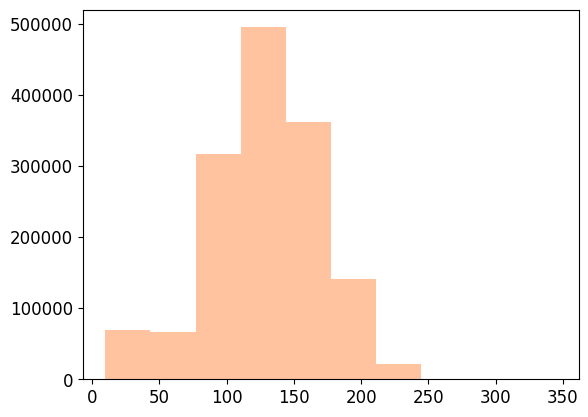

In [76]:
plt.hist(img_hifi[img_hifi>10].ravel())

(array([ 60450.,  56794.,  52126.,  55662.,  66827., 116829., 330977.,
        600628., 233876.,   9134.]),
 array([0.03119487, 0.51757102, 1.00394717, 1.49032331, 1.97669946,
        2.46307561, 2.94945176, 3.43582791, 3.92220406, 4.4085802 ,
        4.89495635]),
 <BarContainer object of 10 artists>)

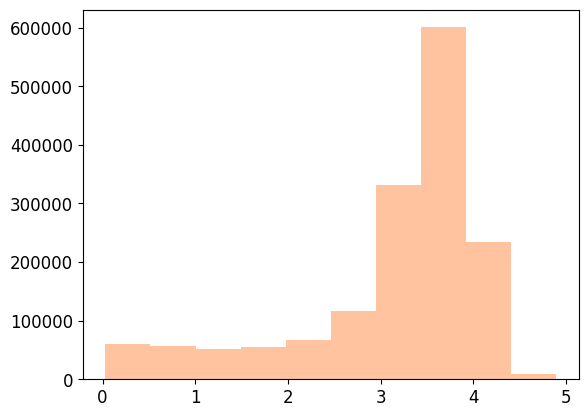

In [77]:
plt.hist(img_recon[img_recon>0].ravel())

In [92]:
img_recon_rescaled = rescale_image(img_recon)
img_hifi_rescaled = rescale_image(img_hifi, img_recon)
img_lofi_rescaled = rescale_image(img_lofi, img_recon)

(array([8.96870e+04, 2.90888e+05, 8.54892e+05, 3.14304e+05, 2.78870e+04,
        2.99000e+03, 1.35900e+03, 8.37000e+02, 3.98000e+02, 6.10000e+01]),
 array([-3.00487291, -1.78050863, -0.55614435,  0.66821994,  1.89258422,
         3.1169485 ,  4.34131278,  5.56567707,  6.79004135,  8.01440563,
         9.23876991]),
 <BarContainer object of 10 artists>)

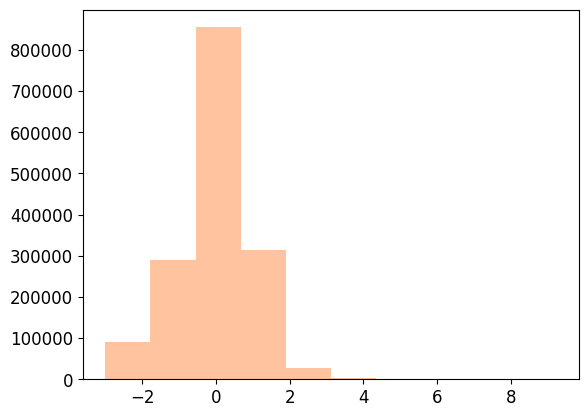

In [93]:
plt.hist(img_lofi_rescaled[img_recon>0].ravel())

(array([ 60450.,  56794.,  52126.,  55662.,  66827., 116829., 330977.,
        600628., 233876.,   9134.]),
 array([-3.43349424, -2.94909503, -2.46469582, -1.98029661, -1.4958974 ,
        -1.01149819, -0.52709899, -0.04269978,  0.44169943,  0.92609864,
         1.41049785]),
 <BarContainer object of 10 artists>)

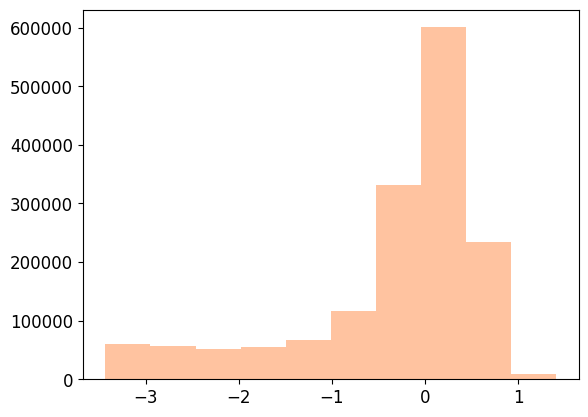

In [94]:
plt.hist(img_recon_rescaled[img_recon>0].ravel())

(array([1.44026e+05, 6.75770e+04, 1.19040e+05, 4.89112e+05, 4.67251e+05,
        2.45458e+05, 4.83420e+04, 2.43600e+03, 5.50000e+01, 6.00000e+00]),
 array([-2.63595989, -1.96964781, -1.30333572, -0.63702364,  0.02928844,
         0.69560053,  1.36191261,  2.02822469,  2.69453678,  3.36084886,
         4.02716094]),
 <BarContainer object of 10 artists>)

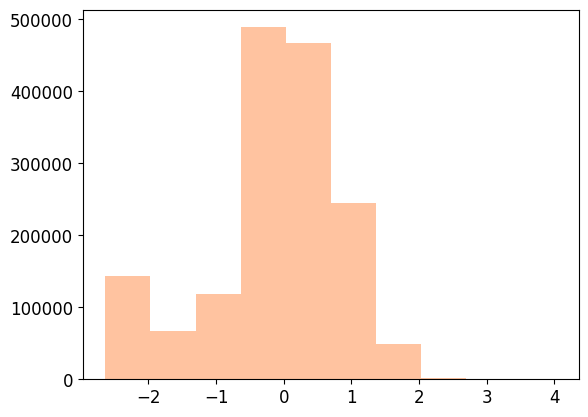

In [95]:
plt.hist(img_hifi_rescaled[img_recon>0].ravel())

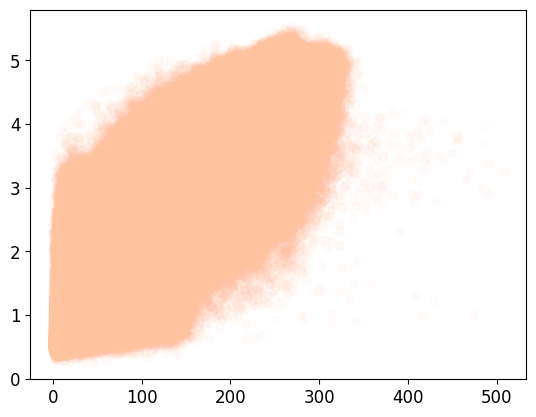

In [44]:
plt.scatter(img_hifi[img_recon>0].ravel(), img_recon[img_recon>0].ravel(), alpha=0.05)

In [50]:
from scipy import stats
stats.pearsonr(img_hifi[img_recon>0].ravel(), img_recon[img_recon>0].ravel())

PearsonRResult(statistic=0.8620518100210347, pvalue=0.0)

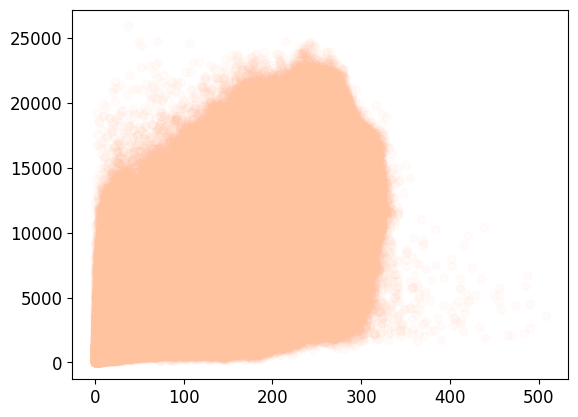

In [46]:
plt.scatter(img_hifi[img_lofi>0].ravel(), img_lofi[img_lofi>0].ravel(), alpha=0.05)

In [51]:
stats.pearsonr(img_hifi[img_lofi>0].ravel(), img_lofi[img_lofi>0].ravel())

PearsonRResult(statistic=0.8285363986224332, pvalue=0.0)

In [55]:
normalized_cross_correlation(img_hifi, img_lofi)

0.9270660423069474

In [56]:
normalized_cross_correlation(img_hifi, img_recon)

0.9806395924633639

In [96]:
get_perceptual_loss(img_hifi_rescaled, img_lofi_rescaled)

tensor(3.8893, device='cuda:0')
tensor(4.0174, device='cuda:0') 



array(4.017444, dtype=float32)

In [102]:
measure_ssim(img_hifi[img_recon>0], img_recon[img_recon>0])

0.28799791316931866

In [841]:
measure_ssim(img_hifi[img_recon>0], img_lofi[img_recon>0])

0.3425478750925546

# This section quanitifies SynthSeg volumes and Dice scores across 3T, 64mT and LowGAN

## Compute the ICV from the brain mask

In [27]:
folder1 = '/mnt/leif/littlab/users/cvadali/BIDS_MS_data_02062024/'
icv = []
for sub in subjects:
    brain_mask = os.path.join(folder1, sub , 'derivatives/registered_images/',sub+'_brainmask.nii.gz')
    if os.path.exists(brain_mask):
        icv.append(np.sum(nib.load(brain_mask).get_fdata()))

## SynthSeg volume comparisons

In [28]:
# define the segmentations
lr_thalamus = [10,49]
lr_lat_ventricles = [4,43]
lr_hippocampus = [17,53]
lr_amygdala = [18,54]
lr_wm = [2,41]
lr_gm = [3,42]
lr_putamen = [12, 51]
lr_pallidum = [13, 52]
lr_caudate = [11, 50]
csf = [24,24]

def calculate_volume(img, labels):
    spacing = img.header['pixdim'][1:4]
    img_np = img.get_fdata()
    
    left_vox = np.sum(img_np==labels[0])
    right_vox = np.sum(img_np==labels[1])
    
    return left_vox*spacing[0]*spacing[1]*spacing[2], right_vox*spacing[0]*spacing[1]*spacing[2]


In [940]:
original_images_path = '../source_data/new_subjects_2_19_2023'

source_data = '../source_data/test_set_lofi_V2_6_5_23'

recon_synthseg_outputs = '../source_data/test_set_lofi_V2_6_5_23/derivatives/SynthSR_outputs'
hifi_synthseg_outputs = '../outputs/SynthSeg_3T_new'
lofi_synthseg_outputs = '../outputs/SynthSeg_SynthSR_v2'

In [941]:
subjects = os.listdir(source_data)
subjects = [x for x in subjects if (x[0]!='.') and ('derivatives' not in x)]

#subjects = list(set(subjects) - {'P050'})


Functions for plotting

In [1030]:
!pip install statannotations

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.1
    Uninstalling seaborn-0.12.1:
      Successfully uninstalled seaborn-0.12.1

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
fig_path='../outputs/figures/paper_figures'

from statannotations.Annotator import Annotator

def cohen_d(group1, group2):
    """
    Calculate Cohen's d between two groups.

    Parameters:
        group1 (array-like): First group of data (e.g., a list, NumPy array, or Pandas Series).
        group2 (array-like): Second group of data (e.g., a list, NumPy array, or Pandas Series).

    Returns:
        float: The Cohen's d effect size.
    """
    # Calculate means of both groups
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    # Calculate pooled standard deviation
    n1 = len(group1)
    n2 = len(group2)
    pooled_std = np.sqrt(((n1 - 1) * np.var(group1, ddof=1) + (n2 - 1) * np.var(group2, ddof=1)) / (n1 + n2 - 2))

    # Calculate Cohen's d
    cohen_d = (mean1 - mean2) / pooled_std

    return cohen_d

def volume_difference(group1, group2):
    
    diff = group1-group2
    
    n1 = len(group1)
    n2 = len(group2)
    
    sd1 = np.std(group1)
    sd2 = np.std(group2)
    
    SE = np.std(diff)/np.sqrt(n1)
    
    vol_difference = np.mean(diff)

    return print('Volume Difference: ',vol_difference, '+/-', SE)

def add_subplot_label(label, ax):
    ax.text(-0.2, 1.05, label, transform=ax.transAxes,
            fontsize=16, fontweight='bold')

def plot_volume_analysis(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, structure_name, scatter_lims):
    df = pd.DataFrame()
    
    '''
    l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list: left and right list of values for 64mT (lofi), 3T (hifi), LowGAN (recon)
    sub_list: list of subjects
    structure_name: name of the structure that is being plotted
    scatter_lims: limits of the scatterplot
    '''

    df['Left '+structure_name] = l_hifi_list+l_lofi_list+l_recon_list
    df['Right '+structure_name] = r_hifi_list+r_lofi_list+r_recon_list
    df['Group'] = len(l_lofi_list)*['3T'] + len(r_lofi_list)*['64mT+SynthSR'] + len(r_lofi_list)*['64mT+LowGAN']
    df['Subject'] = sub_list + sub_list + sub_list

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    order = ['3T','64mT+SynthSR','64mT+LowGAN']
    ax = sns.boxplot(x='Group', y='Left '+structure_name, data=df, order=order, **plot_params)
    
    # add the annotations
    annot = Annotator(ax, [('3T','64mT+SynthSR'),('3T','64mT+LowGAN'),('64mT+SynthSR','64mT+LowGAN')],
                     data=df, x='Group', y='Left '+structure_name, order=order)
    
    annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
    annot.apply_test()
    annot.annotate()
    
    # add the rest of the plot
    sns.lineplot(x='Group', y='Left '+structure_name, units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='Left '+structure_name, data=df, color='k')
    plt.ylabel('Left '+structure_name+'\nVolume (mm$^3$)')
    plt.xticks(rotation=25)
    sns.despine()

    
    plt.subplot(1,3,2)
    ax = sns.boxplot(x='Group', y='Right '+structure_name, data=df, order=order, **plot_params)
    
    # add the annotations
    annot = Annotator(ax, [('3T','64mT+SynthSR'),('3T','64mT+LowGAN'),('64mT+SynthSR','64mT+LowGAN')],
                     data=df, x='Group', y='Right '+structure_name, order=order)
    
    annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
    annot.apply_test()
    annot.annotate()
    
    # add the rest of the plot
    sns.lineplot(x='Group', y='Right '+structure_name, units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='Right '+structure_name, data=df, color='k')
    plt.ylabel('Right '+structure_name+'\nVolume (mm$^3$)')
    plt.xticks(rotation=25)
    sns.despine()
    plt.tight_layout()
    
    # scatterplot
    plt.subplot(1,3,3)

    plt.scatter(x=l_hifi_list, y=l_lofi_list, color=colors[1], label='64mT+SynthSR')
    plt.scatter(x=r_hifi_list, y=r_lofi_list, color=colors[1], label=None)

    #
    plt.scatter(x=l_hifi_list, y=l_recon_list, color=colors[2], label='64mT+LowGAN')
    plt.scatter(x=r_hifi_list, y=r_recon_list, color=colors[2], label=None)
    plt.plot(scatter_lims,scatter_lims, color='k')
    sns.despine()
    plt.xlabel('Target Volume (mm$^3$)')
    plt.ylabel('Measured Volume (mm$^3$)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # print the statistics
    print('Left '+structure_name+', one-sample t-test')
    print('3T vs. 64mT+LowGAN: ',stats.ttest_1samp(df[df['Group']=='3T']['Left '+structure_name].values-df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values)
    
    
    print('\n3T vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='3T']['Left '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values)

    print('\n64mT+LowGAN vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values)

    print('\nRight '+structure_name+', one-sample t-test')
    
    print('3T vs. 64mT+LowGAN: ',stats.ttest_1samp(df[df['Group']=='3T']['Right '+structure_name].values-df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values)
    
    print('\n3T vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='3T']['Right '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values)
    
    print('\n64mT+LowGAN vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values, popmean=0),
     "\nCohen's d: ", cohen_d(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values)

    print("---\n")
    return df


def plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, structure_name, scatter_lims):
    df = pd.DataFrame()
    
    '''
    l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list: left and right list of values for 64mT (lofi), 3T (hifi), LowGAN (recon)
    sub_list: list of subjects
    structure_name: name of the structure that is being plotted
    scatter_lims: limits of the scatterplot
    '''

    df['Left '+structure_name] = l_hifi_list+l_lofi_list+l_recon_list
    df['Right '+structure_name] = r_hifi_list+r_lofi_list+r_recon_list
    df['Group'] = len(l_lofi_list)*['3T'] + len(r_lofi_list)*['64mT+SynthSR'] + len(r_lofi_list)*['64mT+LowGAN']
    df['Subject'] = sub_list + sub_list + sub_list

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    order = ['3T','64mT+SynthSR','64mT+LowGAN']
    ax = sns.boxplot(x='Group', y='Left '+structure_name, data=df, order=order, **plot_params)
    
    # add the annotations
    annot = Annotator(ax, [('3T','64mT+SynthSR'),('3T','64mT+LowGAN'),('64mT+SynthSR','64mT+LowGAN')],
                     data=df, x='Group', y='Left '+structure_name, order=order)
    
    annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
    annot.apply_test()
    annot.annotate()
    
    # add the rest of the plot
    sns.lineplot(x='Group', y='Left '+structure_name, units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='Left '+structure_name, data=df, color='k')
    plt.ylabel('Left '+structure_name+'\nVolume (mm$^3$)')
    plt.xticks(rotation=25)
    sns.despine()
    add_subplot_label('A.', plt.gca())

    
    plt.subplot(1,3,2)
    ax = sns.boxplot(x='Group', y='Right '+structure_name, data=df, order=order, **plot_params)
    
    # add the annotations
    annot = Annotator(ax, [('3T','64mT+SynthSR'),('3T','64mT+LowGAN'),('64mT+SynthSR','64mT+LowGAN')],
                     data=df, x='Group', y='Right '+structure_name, order=order)
    
    annot.configure(test='t-test_paired', text_format='star', loc='inside', verbose=2, comparisons_correction="Bonferroni")
    annot.apply_test()
    annot.annotate()
    
    # add the rest of the plot
    sns.lineplot(x='Group', y='Right '+structure_name, units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='Right '+structure_name, data=df, color='k')
    plt.ylabel('Right '+structure_name+'\nVolume (mm$^3$)')
    plt.xticks(rotation=25)
    sns.despine()
    add_subplot_label('B.', plt.gca())
    plt.tight_layout()
    
    # scatterplot
    plt.subplot(1,3,3)

    plt.scatter(x=l_hifi_list, y=l_lofi_list, color=colors[1], label='64mT+SynthSR')
    plt.scatter(x=r_hifi_list, y=r_lofi_list, color=colors[1], label=None)

    #
    plt.scatter(x=l_hifi_list, y=l_recon_list, color=colors[2], label='64mT+LowGAN')
    plt.scatter(x=r_hifi_list, y=r_recon_list, color=colors[2], label=None)
    plt.plot(scatter_lims,scatter_lims, color='k')
    sns.despine()
    plt.xlabel('Target Volume (mm$^3$)')
    plt.ylabel('Measured Volume (mm$^3$)')
    plt.xticks(rotation=45)
    plt.legend()
    add_subplot_label('C.', plt.gca())
    plt.tight_layout()
    
    # print the statistics
    print('Left '+structure_name+', one-sample t-test')
    print('3T vs. 64mT+LowGAN: ',stats.ttest_1samp(df[df['Group']=='3T']['Left '+structure_name].values-df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values)
    
    
    print('\n3T vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='3T']['Left '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values)

    print('\n64mT+LowGAN vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values)

    print('\nRight '+structure_name+', one-sample t-test')
    
    print('3T vs. 64mT+LowGAN: ',stats.ttest_1samp(df[df['Group']=='3T']['Right '+structure_name].values-df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values)
    
    print('\n3T vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='3T']['Right '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values)
    
    print('\n64mT+LowGAN vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values, popmean=0),
     "\nCohen's d: ", cohen_d(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values)

    print("---\n")
    return df




def plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, structure_name, scatter_lims, icv_list):
    df = pd.DataFrame()
    
    '''
    l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list: left and right list of values for 64mT (lofi), 3T (hifi), LowGAN (recon)
    sub_list: list of subjects
    structure_name: name of the structure that is being plotted
    scatter_lims: limits of the scatterplot
    '''
    
    df['Left '+structure_name] = list(np.array(l_hifi_list)/np.array(icv_list))+list(np.array(l_lofi_list)/np.array(icv_list))+list(np.array(l_recon_list)/np.array(icv_list))
    df['Right '+structure_name] = list(np.array(r_hifi_list)/np.array(icv_list))+list(np.array(r_lofi_list)/np.array(icv_list))+list(np.array(r_recon_list)/np.array(icv_list))
    df['Group'] = len(l_lofi_list)*['3T'] + len(r_lofi_list)*['64mT+SynthSR'] + len(r_lofi_list)*['64mT+LowGAN']
    df['Subject'] = sub_list + sub_list + sub_list

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    sns.boxplot(x='Group', y='Left '+structure_name, data=df, **plot_params)
    sns.lineplot(x='Group', y='Left '+structure_name, units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='Left '+structure_name, data=df, color='k')
    plt.ylabel('Left '+structure_name+'\nVolume (mm$^3$)')
    plt.xticks(rotation=25)
    sns.despine()
    
    plt.subplot(1,3,2)
    sns.boxplot(x='Group', y='Right '+structure_name, data=df, **plot_params)
    sns.lineplot(x='Group', y='Right '+structure_name, units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='Right '+structure_name, data=df, color='k')
    plt.ylabel('Right '+structure_name+'\nVolume (mm$^3$)')
    plt.xticks(rotation=25)
    sns.despine()
    plt.tight_layout()

    # scatterplot
    plt.subplot(1,3,3)

    plt.scatter(x=list(np.array(l_hifi_list)/np.array(icv_list)), y=list(np.array(l_lofi_list)/np.array(icv_list)), color=colors[1], label='64mT+SynthSR')
    plt.scatter(x=list(np.array(r_hifi_list)/np.array(icv_list)), y=list(np.array(r_lofi_list)/np.array(icv_list)), color=colors[1], label=None)

    #
    plt.scatter(x=list(np.array(l_hifi_list)/np.array(icv_list)), y=list(np.array(l_recon_list)/np.array(icv_list)), color=colors[2], label='64mT+LowGAN')
    plt.scatter(x=list(np.array(r_hifi_list)/np.array(icv_list)), y=list(np.array(r_recon_list)/np.array(icv_list)), color=colors[2], label=None)
    plt.plot(scatter_lims,scatter_lims, color='k')
    sns.despine()
    plt.xlabel('Target Volume (mm$^3$)')
    plt.ylabel('Measured Volume (mm$^3$)')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    
    # print the statistics
    print('Left '+structure_name+', one-sample t-test')
    print('3T vs. 64mT+LowGAN: ',stats.ttest_1samp(df[df['Group']=='3T']['Left '+structure_name].values-df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values)
    
    
    print('\n3T vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='3T']['Left '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values)

    print('\n64mT+LowGAN vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values))
    volume_difference(df[df['Group']=='64mT+LowGAN']['Left '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Left '+structure_name].values)

    print('\nRight '+structure_name+', one-sample t-test')
    
    print('3T vs. 64mT+LowGAN: ',stats.ttest_1samp(df[df['Group']=='3T']['Right '+structure_name].values-df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values)
    
    print('\n3T vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='3T']['Right '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values, popmean=0),
         "\nCohen's d: ", cohen_d(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='3T']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values)
    
    print('\n64mT+LowGAN vs. 64mT: ', stats.ttest_1samp(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values-df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values, popmean=0),
     "\nCohen's d: ", cohen_d(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values))
    volume_difference(df[df['Group']=='64mT+LowGAN']['Right '+structure_name].values,df[df['Group']=='64mT+SynthSR']['Right '+structure_name].values)

    print("---\n")
    return df


def plot_bland_altman(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, structure_name):
    
    data2_lofi = l_lofi_list + r_lofi_list
    data1_hifi = l_hifi_list + r_hifi_list
    data2_recon = l_recon_list + r_recon_list
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the Bland-Altman plot for 3T vs. SynthSR+64mT on the first subplot (ax1)
    blandAltman(data1_hifi, data2_lofi,
                limitOfAgreement=1.96,
                confidenceInterval=95,
                confidenceIntervalMethod='approximate',
                detrend=None,
                percentage=True,
                title='3T vs. 64mT+SynthSR - ' + structure_name,
                ax=ax1)
    ax1.set_xlabel('Mean of 3T and 64mT+SynthSR')
    ax1.set_ylabel('Percent Difference \n(3T - 64mT+SynthSR)')
    ax1.set_title('3T vs. 64mT+SynthSR - ' + structure_name)
    ax1.text(-0.15, 1.02, 'A.', transform=ax1.transAxes, fontsize=16, fontweight='bold')
    print('The Bias in the plot is: lofi-hifi')

    # Plot the Bland-Altman plot for 3T vs. LowGAN+64mT on the second subplot (ax2)
    blandAltman(data1_hifi, data2_recon,
                limitOfAgreement=1.96,
                confidenceInterval=95,
                confidenceIntervalMethod='approximate',
                detrend=None,
                percentage=True,
                title='3T vs. 64mT+LowGAN - ' + structure_name,
                ax=ax2)
    ax2.set_xlabel('Mean of 3T and 64mT+LowGAN')
    ax2.set_ylabel('Percent Difference \n(3T - 64mT+LowGAN)')
    ax2.set_title('3T vs. 64mT+LowGAN - ' + structure_name)
    ax2.text(-0.15, 1.02, 'B.', transform=ax2.transAxes, fontsize=16, fontweight='bold')
    print('The Bias in the plot is: recon-hifi')

    # Adjust subplot spacing
    plt.tight_layout()
    
    # Show the plots
    #plt.show()

    
def plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, structure_name):
    
    data2_lofi = l_lofi_list + r_lofi_list
    data1_hifi = l_hifi_list + r_hifi_list
    data2_recon = l_recon_list + r_recon_list
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the Bland-Altman plot for 3T vs. SynthSR+64mT on the first subplot (ax1)
    blandAltman(data1_hifi, data2_lofi,
                limitOfAgreement=1.96,
                confidenceInterval=95,
                confidenceIntervalMethod='approximate',
                detrend=None,
                percentage=True,
                title='3T vs. 64mT+SynthSR - ' + structure_name,
                ax=ax1)
    ax1.set_xlabel('Mean of 3T and 64mT+SynthSR')
    ax1.set_ylabel('Percent Difference \n(3T - 64mT+SynthSR)')
    ax1.set_title('3T vs. 64mT+SynthSR - ' + structure_name)
    ax1.text(-0.15, 1.02, 'D.', transform=ax1.transAxes, fontsize=16, fontweight='bold')
    print('The Bias in the plot is: lofi-hifi')

    # Plot the Bland-Altman plot for 3T vs. LowGAN+64mT on the second subplot (ax2)
    blandAltman(data1_hifi, data2_recon,
                limitOfAgreement=1.96,
                confidenceInterval=95,
                confidenceIntervalMethod='approximate',
                detrend=None,
                percentage=True,
                title='3T vs. 64mT+LowGAN - ' + structure_name,
                ax=ax2)
    ax2.set_xlabel('Mean of 3T and 64mT+LowGAN')
    ax2.set_ylabel('Percent Difference \n(3T - 64mT+LowGAN)')
    ax2.set_title('3T vs. 64mT+LowGAN - ' + structure_name)
    ax2.text(-0.15, 1.02, 'E.', transform=ax2.transAxes, fontsize=16, fontweight='bold')
    print('The Bias in the plot is: recon-hifi')

    # Adjust subplot spacing
    plt.tight_layout()




## Thalamus

In [31]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_thalamus)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_thalamus)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_thalamus)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)
    else:
        print('Subject ', sub, ' not found')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:2.324e-20 t=1.467e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.857e-19 t=-1.400e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-9.361e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:7.997e-25 t=1.830e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:4.869e-15 t=-1.093e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:9.362e-01 t=1.020e+00
Lef

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Thalamus  Right Thalamus        Group Subject
0      4615.000000     4638.000000           3T    N037
1      5352.000000     5161.000000           3T    P005
2      5904.000000     5603.000000           3T    P009
3      6108.278031     6196.969656           3T    P023
4      6089.210510     5951.881409           3T    P031
..             ...             ...          ...     ...
166    6768.000000     6909.000000  64mT+LowGAN    P025
167    8269.000000     8733.000000  64mT+LowGAN    N041
168    7807.000000     6908.000000  64mT+LowGAN    P047
169    6473.000000     6220.000000  64mT+LowGAN    N039
170    7455.000000     7654.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

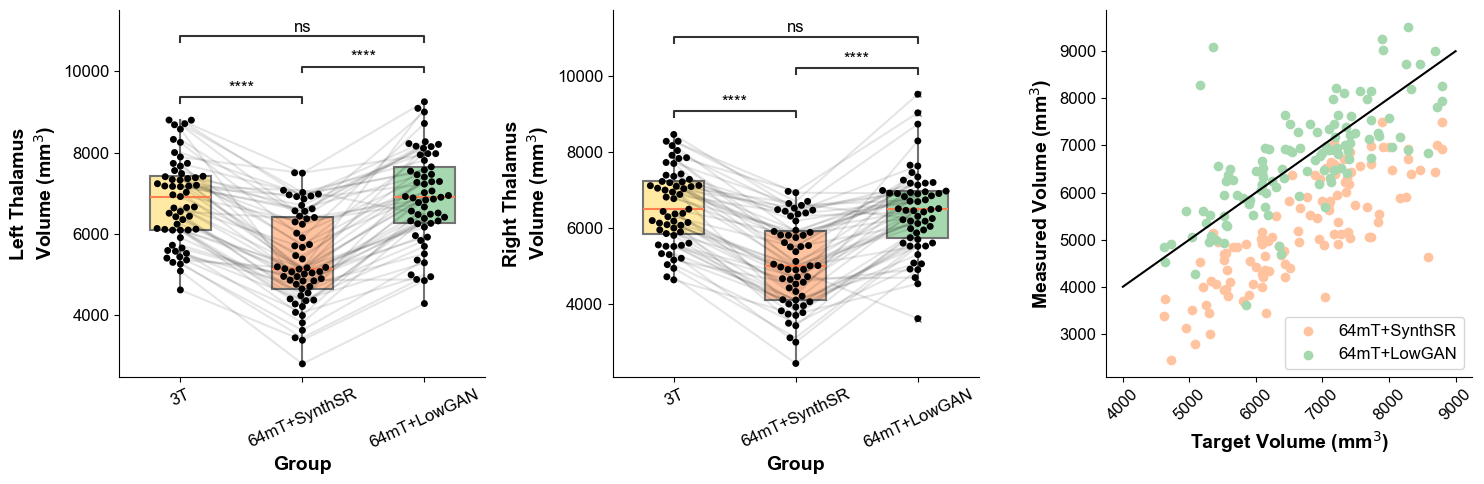

In [32]:
plot_volume_analysis(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Thalamus', [4000,9000])
#plt.savefig(os.path.join(fig_path,'thalamus_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


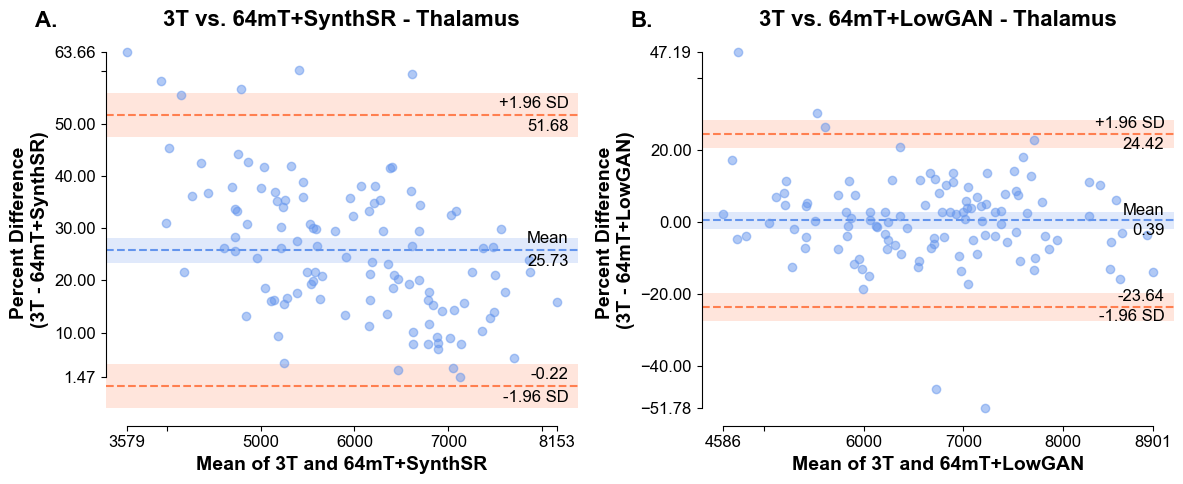

In [33]:
plot_bland_altman(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Thalamus')
#plt.savefig(os.path.join(fig_path,'thalamus_bland_altman.pdf'))

Left Thalamus, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=-0.6636380113046961, pvalue=0.5096450081648438, df=56) 
Cohen's d:  -0.05524725594753831
Volume Difference:  -4.002978233338986e-05 +/- 5.9787247679688684e-05

3T vs. 64mT:  TtestResult(statistic=14.757533642408058, pvalue=5.96343348988925e-21, df=56) 
Cohen's d:  1.303369578601372
Volume Difference:  0.0010014094684365935 +/- 6.725963359383885e-05

64mT+LowGAN vs. 64mT:  TtestResult(statistic=15.230434912526134, pvalue=1.4413861139248157e-21, df=56) 
Cohen's d:  1.380049867745276
Volume Difference:  0.0010414392507699832 +/- 6.777635711765986e-05

Right Thalamus, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=1.4509705905639503, pvalue=0.1523669521752915, df=56) 
Cohen's d:  0.13738022489202983
Volume Difference:  9.914514831872244e-05 +/- 6.77281858048478e-05

3T vs. 64mT:  TtestResult(statistic=19.18081464774382, pvalue=2.762648164034084e-26, df=56) 
Cohen's d:  1.370280768069111
Volume Differe

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Thalamus  Right Thalamus        Group Subject
0         0.004294        0.004315           3T    N037
1         0.001556        0.001501           3T    P005
2         0.004729        0.004488           3T    P009
3         0.004197        0.004258           3T    P023
4         0.004439        0.004339           3T    P031
..             ...             ...          ...     ...
166       0.005014        0.005118  64mT+LowGAN    P025
167       0.005287        0.005584  64mT+LowGAN    N041
168       0.005005        0.004428  64mT+LowGAN    P047
169       0.004752        0.004567  64mT+LowGAN    N039
170       0.005160        0.005298  64mT+LowGAN    P028

[171 rows x 4 columns]

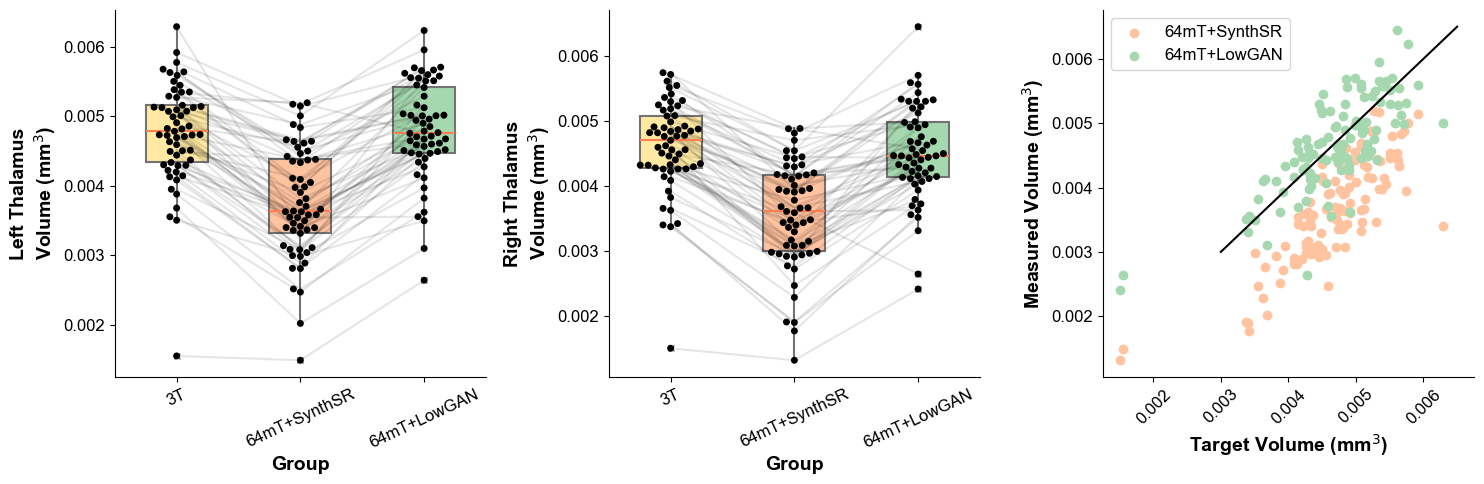

In [34]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Thalamus', [0.003,0.0065], icv)

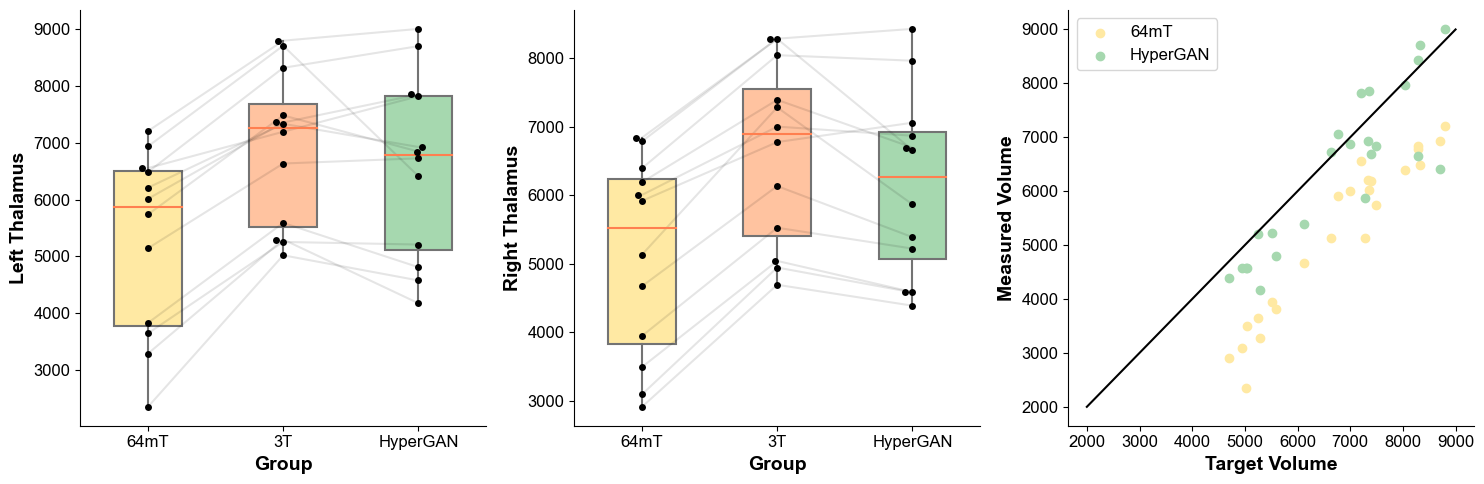

In [1253]:
##### df_thalamus = pd.DataFrame()

df_thalamus['Left Thalamus'] = l_lofi_list+l_hifi_list+l_recon_list
df_thalamus['Right Thalamus'] = r_lofi_list+r_hifi_list+r_recon_list
df_thalamus['Group'] = len(l_lofi_list)*['64mT'] + len(r_lofi_list)*['3T'] + len(r_lofi_list)*['LowGAN']
df_thalamus['Subject'] = sub_list + sub_list + sub_list


plt.figure(figsize=(15,5))

# right structure boxplot
plt.subplot(1,3,1)
sns.boxplot(x='Group', y='Left Thalamus', data=df_thalamus, **plot_params)
sns.lineplot(x='Group', y='Left Thalamus', units='Subject', estimator=None,data=df_thalamus, color='k', alpha=0.1)
sns.swarmplot(x='Group', y='Left Thalamus', data=df_thalamus, color='k')
sns.despine()

# left structure boxplot
plt.subplot(1,3,2)
sns.boxplot(x='Group', y='Right Thalamus', data=df_thalamus, **plot_params)
sns.lineplot(x='Group', y='Right Thalamus', units='Subject', estimator=None,data=df_thalamus, color='k', alpha=0.1)
sns.swarmplot(x='Group', y='Right Thalamus', data=df_thalamus, color='k')
sns.despine()


# scatterplot
plt.subplot(1,3,3)

plt.scatter(x=l_hifi_list, y=l_lofi_list, color=colors[0], label='64mT')
plt.scatter(x=r_hifi_list, y=r_lofi_list, color=colors[0], label=None)

#
plt.scatter(x=l_hifi_list, y=l_recon_list, color=colors[2], label='LowGAN')
plt.scatter(x=r_hifi_list, y=r_recon_list, color=colors[2], label=None)
plt.plot([2000,9000],[2000,9000], color='k')
sns.despine()
plt.xlabel('Target Volume')
plt.ylabel('Measured Volume')
plt.legend()

plt.tight_layout()

In [1254]:
from scipy import stats

print('Left Thalamus')
print('3T vs. LowGAN: ',stats.ttest_1samp(df_thalamus[df_thalamus['Group']=='3T']['Left Thalamus'].values-df_thalamus[df_thalamus['Group']=='LowGAN']['Left Thalamus'].values, popmean=0))
print('3T vs. 64mT: ', stats.ttest_1samp(df_thalamus[df_thalamus['Group']=='3T']['Left Thalamus'].values-df_thalamus[df_thalamus['Group']=='64mT']['Left Thalamus'].values, popmean=0))



print('\nRight Thalamus')
print('3T vs. LowGAN: ',stats.ttest_1samp(df_thalamus[df_thalamus['Group']=='3T']['Right Thalamus'].values-df_thalamus[df_thalamus['Group']=='LowGAN']['Right Thalamus'].values, popmean=0))
print('3T vs. 64mT: ',stats.ttest_1samp(df_thalamus[df_thalamus['Group']=='3T']['Right Thalamus'].values-df_thalamus[df_thalamus['Group']=='64mT']['Right Thalamus'].values, popmean=0))



Left Thalamus
3T vs. HyperGAN:  Ttest_1sampResult(statistic=1.3788941695449193, pvalue=0.19531997008542853)
3T vs. 64mT:  Ttest_1sampResult(statistic=11.51725942526234, pvalue=1.7720525098397095e-07)

Right Thalamus
3T vs. HyperGAN:  Ttest_1sampResult(statistic=2.8651456236672237, pvalue=0.015374461644869789)
3T vs. 64mT:  Ttest_1sampResult(statistic=14.505131062924224, pvalue=1.6214976959950654e-08)


### Does the lesion burden correlate with the thalamic volume?

In [1255]:

mask_path = '../source_data/test_set_lofi_V2_6_5_23/derivatives/results/lesion_masks'
mask_path_lofi = '../source_data/test_set_lofi_V2_6_5_23/derivatives/results/lesion_masks_lofi'

lesion_burden = []
lesion_burden_lofi = []

for sub in subjects:
    if os.path.exists(os.path.join(mask_path,sub+'_lesion_mask.nii.gz')):

        
        # constrain the lesions to the white matter
        seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg.nii.gz')
        seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_SynthSeg.nii.gz')
        seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_recon_t1_SynthSeg.nii.gz')
        
        seg_recon = nib.load(seg_recon_path).get_fdata()
        
        seg_wm_recon = ((seg_recon==lr_wm[0]) | (seg_recon==lr_wm[1]))    
   
        seg_lofi = nib.load(seg_lofi_path).get_fdata()
        
        seg_wm_lofi = ((seg_lofi==lr_wm[0]) | (seg_lofi==lr_wm[1]))    
   


        lesion_mask = nib.load(os.path.join(mask_path,sub+'_lesion_mask.nii.gz')).get_fdata()
        lesion_mask_lofi = nib.load(os.path.join(mask_path_lofi,sub+'_lesion_mask.nii.gz')).get_fdata()
        pixdim = nib.load(os.path.join(mask_path,sub+'_lesion_mask.nii.gz')).header['pixdim'][1:4]
#        lesion_burden.append(pixdim[0]*pixdim[1]*pixdim[2]*np.sum(lesion_mask*seg_wm_recon))
        lesion_burden.append(pixdim[0]*pixdim[1]*pixdim[2]*np.sum(lesion_mask))

        lesion_burden_lofi.append(pixdim[0]*pixdim[1]*pixdim[2]*np.sum(lesion_mask_lofi))
    else:
        print(sub)
        lesion_burden.append(np.nan)
        lesion_burden_lofi.append(np.nan)

P047


In [1256]:
subjects

['N032',
 'P047',
 'P024',
 'P057',
 'N028',
 'P062',
 'P050',
 'N027',
 'P041',
 'P046',
 'P032',
 'N029']

In [1257]:
lesion_burden

[1459.9998259544373,
 nan,
 12810.707092285156,
 25799.75128173828,
 689.9999588727951,
 2347.9461669921875,
 8484.840393066406,
 636.0,
 27146.339416503906,
 13831.138610839844,
 5483.62697660923,
 2125.0]

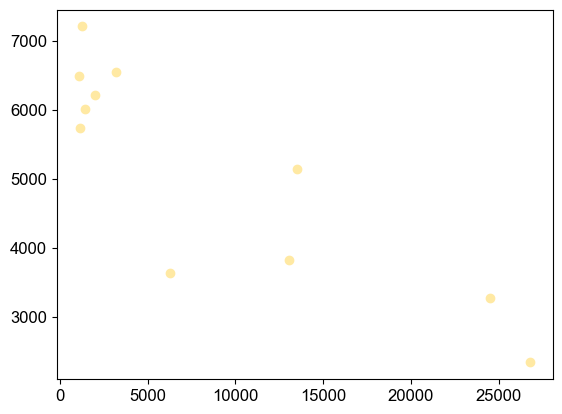

In [1258]:
plt.scatter(lesion_burden_lofi, np.array(l_lofi_list))

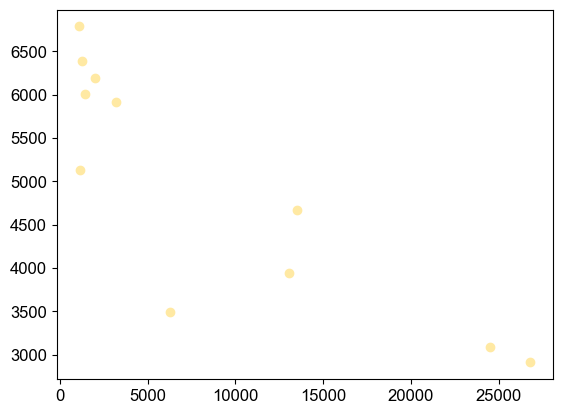

In [1259]:
plt.scatter(lesion_burden_lofi, np.array(r_lofi_list))

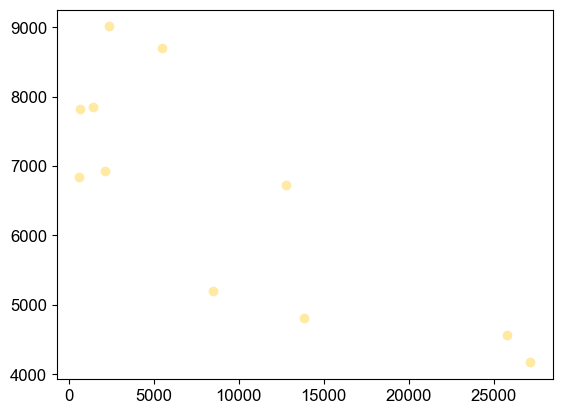

In [1260]:
plt.scatter(lesion_burden, np.array(l_recon_list))

In [1261]:
stats.pearsonr(np.array(lesion_burden)[~np.isnan(lesion_burden)], np.array(l_recon_list)[~np.isnan(lesion_burden)])

PearsonRResult(statistic=-0.8061363887501355, pvalue=0.002729194414770161)

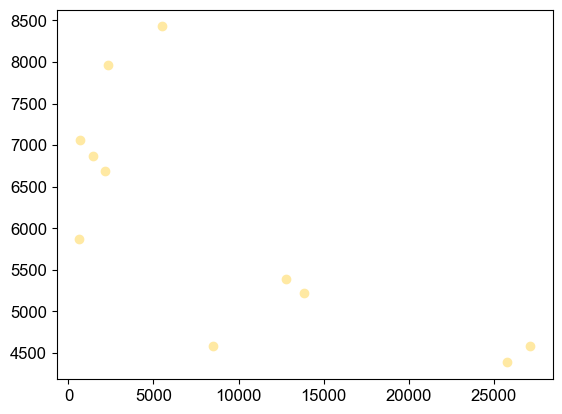

In [1262]:
plt.scatter(lesion_burden, np.array(r_recon_list))

In [1263]:
stats.pearsonr(np.array(lesion_burden)[~np.isnan(lesion_burden)], np.array(r_recon_list)[~np.isnan(lesion_burden)])

PearsonRResult(statistic=-0.7253311563237302, pvalue=0.011532714919835206)

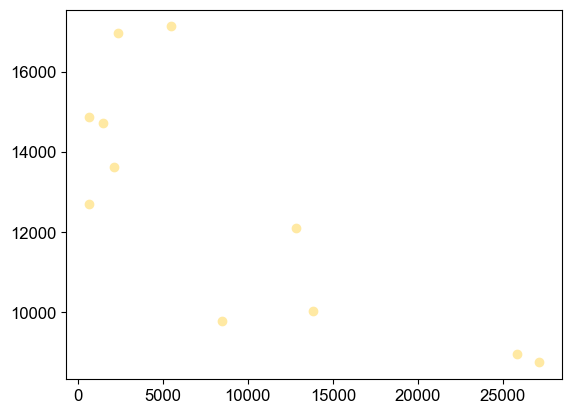

In [1264]:
plt.scatter(lesion_burden, np.array(r_recon_list)+np.array(l_recon_list))

In [1265]:
stats.pearsonr(np.array(lesion_burden)[~np.isnan(lesion_burden)], (np.array(r_recon_list)+np.array(l_recon_list))[~np.isnan(lesion_burden)])

PearsonRResult(statistic=-0.7801499213813258, pvalue=0.004617130679895098)

### Load the MIMOSA segmentations at 3T

In [1266]:
mimosa_folder = '../outputs/MIMOSA'

mimosa_lesion_burden = []

for sub in subjects:
    mimosa_path_sub = os.path.join(mimosa_folder,sub,'session1_3T','mimosa','mimosa_mask.nii.gz')
    if os.path.exists(mimosa_path_sub):
        mimosa_seg_3t = np.sum(nib.load(mimosa_path_sub).get_fdata())
        pixdim = nib.load(mimosa_path_sub).header['pixdim'][1:4]
        
        mimosa_lesion_burden.append(mimosa_seg_3t*pixdim[0]*pixdim[1]*pixdim[2])
    else:
        mimosa_lesion_burden.append(np.nan)

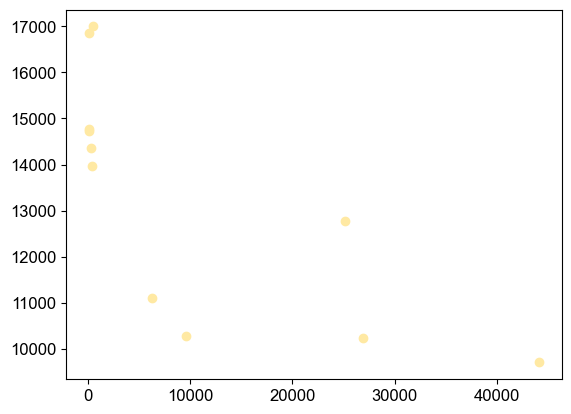

In [1267]:
plt.scatter( mimosa_lesion_burden,(np.array(r_hifi_list)+np.array(l_hifi_list)))

#### Fit a decaying exponential

/tmp/ipykernel_4316/3936653774.py:7: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_4316/3936653774.py:7: RuntimeWarning:

overflow encountered in multiply



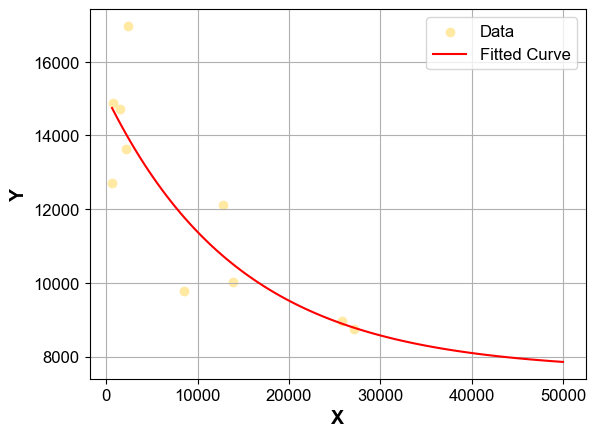

Optimized Coefficients:
a = 7452.504081409989
b = 6.8069744477615e-05
c = 7608.090186754601
R-squared = 0.723957064668469


In [1268]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the decaying exponential function
def decaying_exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

# Sample data (replace this with your own data)

x_data = np.array(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]
y_data = (np.array(r_recon_list)+np.array(l_recon_list))[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]


# Fit the curve to the data
params, covariance = curve_fit(decaying_exponential, x_data, y_data, p0=[17000,0.01,10000], method='lm')

# Get the optimized coefficients
a_opt, b_opt, c_opt = params

# Calculate R-squared
residuals = y_data - decaying_exponential(x_data, a_opt, b_opt, c_opt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)

# Generate points for the fitted curve
x_fit_recon = np.linspace(x_data.min(), 50000, 100)
y_fit_recon = decaying_exponential(x_fit_recon, a_opt, b_opt, c_opt)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit_recon, y_fit_recon, label='Fitted Curve', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Report the results
print("Optimized Coefficients:")
print(f"a = {a_opt}")
print(f"b = {b_opt}")
print(f"c = {c_opt}")
print(f"R-squared = {r_squared}")


/tmp/ipykernel_4316/3936653774.py:7: RuntimeWarning:

overflow encountered in exp



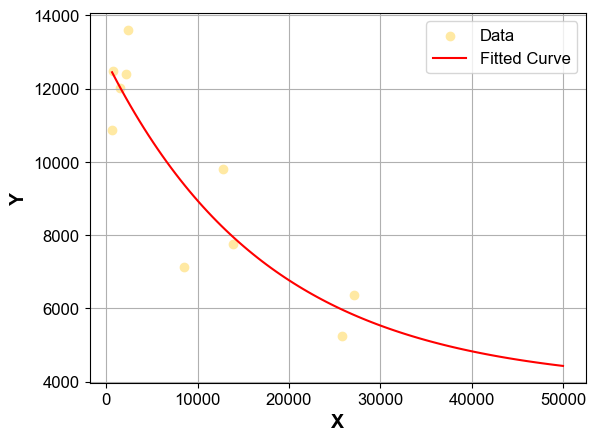

Optimized Coefficients:
a = 8852.999287414983
b = 5.6386842150787526e-05
c = 3903.7933783293374
R-squared = 0.804932207951546


In [1269]:
# Sample data (replace this with your own data)

x_data = np.array(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]
y_data = (np.array(r_lofi_list)+np.array(l_lofi_list))[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]


# Fit the curve to the data
params, covariance = curve_fit(decaying_exponential, x_data, y_data, p0=[17000,0.01,10000], method='lm')

# Get the optimized coefficients
a_opt, b_opt, c_opt = params

# Calculate R-squared
residuals = y_data - decaying_exponential(x_data, a_opt, b_opt, c_opt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)

# Generate points for the fitted curve
x_fit_lofi = np.linspace(x_data.min(), 50000, 100)
y_fit_lofi = decaying_exponential(x_fit_lofi, a_opt, b_opt, c_opt)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit_lofi, y_fit_lofi, label='Fitted Curve', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Report the results
print("Optimized Coefficients:")
print(f"a = {a_opt}")
print(f"b = {b_opt}")
print(f"c = {c_opt}")
print(f"R-squared = {r_squared}")

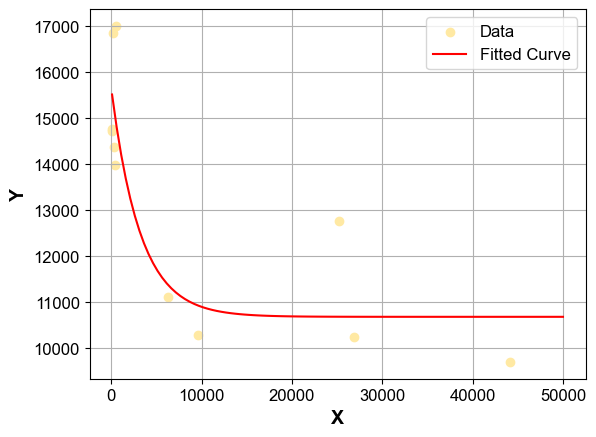

Optimized Coefficients:
a = 4964.6587989001655
b = 0.0003131664955051671
c = 10685.769222638466
R-squared = 0.7695599808063764


In [1270]:
x_data = np.array(mimosa_lesion_burden)[~np.isnan(l_hifi_list) & ~np.isnan(mimosa_lesion_burden)]
y_data = (np.array(r_hifi_list)+np.array(l_hifi_list))[~np.isnan(l_hifi_list) & ~np.isnan(mimosa_lesion_burden)]

# Fit the curve to the data
params, covariance = curve_fit(decaying_exponential, x_data, y_data, p0=[17000,0.01,10000], method='lm')

# Get the optimized coefficients
a_opt, b_opt, c_opt = params

# Calculate R-squared
residuals = y_data - decaying_exponential(x_data, a_opt, b_opt, c_opt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)

# Generate points for the fitted curve
x_fit_hifi = np.linspace(x_data.min(), 50000, 100)
y_fit_hifi = decaying_exponential(x_fit_hifi, a_opt, b_opt, c_opt)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit_hifi, y_fit_hifi, label='Fitted Curve', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Report the results
print("Optimized Coefficients:")
print(f"a = {a_opt}")
print(f"b = {b_opt}")
print(f"c = {c_opt}")
print(f"R-squared = {r_squared}")

#### Plot the lesion burden as a function of thalamic volume

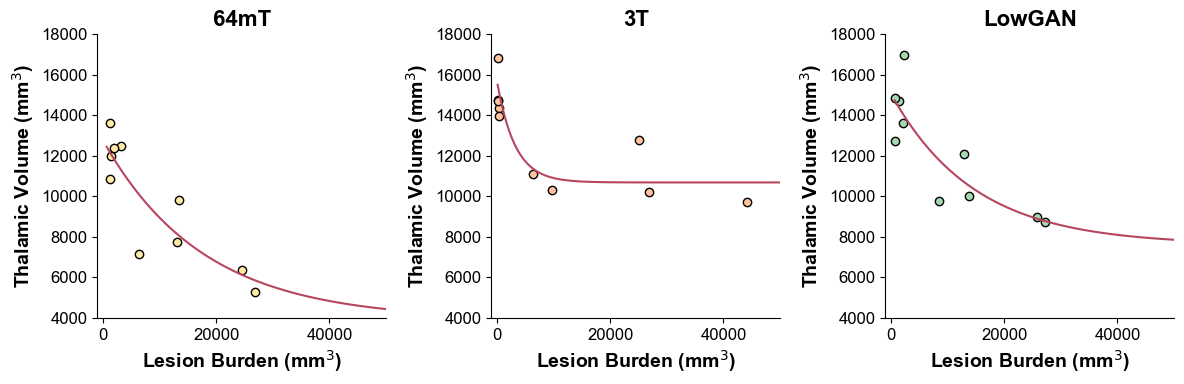

In [1276]:
# plot of lesion burden as a function of thalamic volume
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.scatter(np.array(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            (np.array(r_lofi_list)+np.array(l_lofi_list))[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)],
           color=colors[0], edgecolor='k')
plt.plot(x_fit_lofi,y_fit_lofi,color=colors[-1])

plt.xlabel('Lesion Burden (mm$^3$)')
plt.ylabel('Thalamic Volume (mm$^3$)')
plt.title('64mT')

plt.ylim([4000,18000])
plt.xlim([-1000,50000])
sns.despine()

plt.subplot(1,3,3)
plt.scatter(np.array(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            (np.array(r_recon_list)+np.array(l_recon_list))[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)],
           color=colors[2], edgecolor='k')
plt.plot(x_fit_recon,y_fit_recon,color=colors[-1])
plt.xlabel('Lesion Burden (mm$^3$)')
plt.ylabel('Thalamic Volume (mm$^3$)')
plt.title('LowGAN')

plt.ylim([4000,18000])
plt.xlim([-1000,50000])
sns.despine()

plt.subplot(1,3,2)
plt.scatter(np.array(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            (np.array(r_hifi_list)+np.array(l_hifi_list))[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)],
           color=colors[1], edgecolor='k')
plt.plot(x_fit_hifi,y_fit_hifi,color=colors[-1])

plt.xlabel('Lesion Burden (mm$^3$)')
plt.ylabel('Thalamic Volume (mm$^3$)')
plt.title('3T')
plt.ylim([4000,18000])
plt.xlim([-1000,50000])
sns.despine()

plt.tight_layout()
plt.savefig(os.path.join(fig_path,'thal_volume_vs_lesion_burden.pdf'))

#### Relationship between lesion burden across modalities

3T-64mT correlation:  PearsonRResult(statistic=0.9550800771226235, pvalue=1.6870549257739056e-05)
3T-HyperGAN correlation:  PearsonRResult(statistic=0.9143736915546261, pvalue=0.00021186969144177114)
64mT-HyperGAN correlation:  PearsonRResult(statistic=0.9143368942028491, pvalue=0.0002122244507990935)


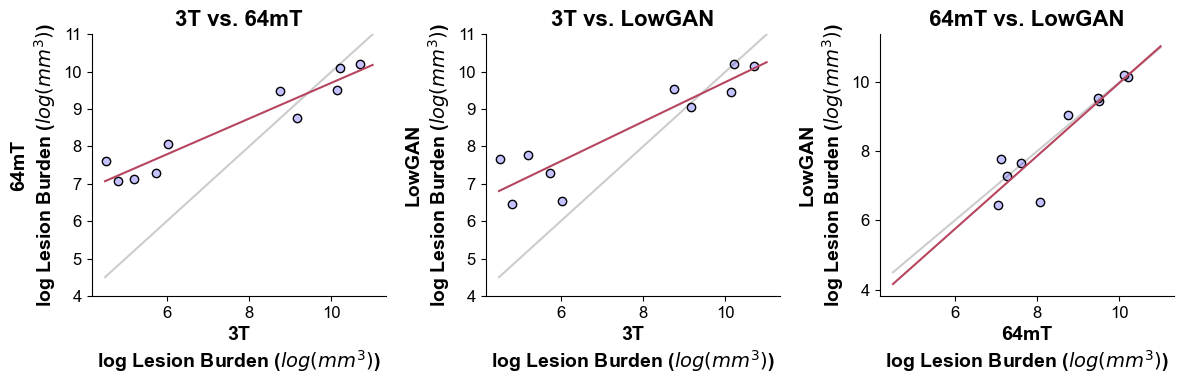

In [1277]:
plt.figure(figsize=(12,4))

########### first subplot ##########


plt.subplot(1,3,1)
plt.scatter(np.log(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            np.log(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]
            , color=colors[-2], edgecolor='k')
plt.plot([4.5,11],[4.5,11], color='k', alpha=0.2)

# Fit linear regression
coefficients = np.polyfit(np.log(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
                          np.log(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 1)
slope, intercept = coefficients

# Generate points for the linear regression line
x_fit = np.linspace(4.5, 11, 100)
y_fit = slope * x_fit + intercept

# Plot the linear regression line
plt.plot(x_fit, y_fit, color=colors[-1], label='Linear Regression')

# Print the regression coefficient
print('3T-64mT correlation: ',stats.pearsonr(np.log(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
                          np.log(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]))



sns.despine()
plt.title('3T vs. 64mT')
plt.xlabel('3T\nlog Lesion Burden ($log(mm^3)$)')
plt.ylabel('64mT\nlog Lesion Burden ($log(mm^3)$)')
plt.ylim([4,11])

########### second subplot ##########

plt.subplot(1,3,2)
plt.scatter(np.log(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            np.log(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            color=colors[-2], edgecolor='k')
plt.plot([4.5,11],[4.5,11], color='k', alpha=0.2)

# Fit linear regression
coefficients = np.polyfit(np.log(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
                          np.log(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 1)
slope, intercept = coefficients

# Generate points for the linear regression line
x_fit = np.linspace(4.5, 11, 100)
y_fit = slope * x_fit + intercept

# Plot the linear regression line
plt.plot(x_fit, y_fit, color=colors[-1], label='Linear Regression')

# Print the regression coefficient
print('3T-LowGAN correlation: ',stats.pearsonr(np.log(mimosa_lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
                          np.log(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]))


sns.despine()
plt.title('3T vs. LowGAN')
plt.xlabel('3T\nlog Lesion Burden ($log(mm^3)$)')
plt.ylabel('LowGAN\nlog Lesion Burden ($log(mm^3)$)')
plt.ylim([4,11])

########### third subplot ##########

plt.subplot(1,3,3)
plt.scatter(np.log(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            np.log(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
            color=colors[-2], edgecolor='k')
plt.plot([4.5,11],[4.5,11], color='k', alpha=0.2)

# Fit linear regression
coefficients = np.polyfit(np.log(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
                          np.log(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 1)
slope, intercept = coefficients

# Generate points for the linear regression line
x_fit = np.linspace(4.5, 11, 100)
y_fit = slope * x_fit + intercept

# Plot the linear regression line
plt.plot(x_fit, y_fit, color=colors[-1], label='Linear Regression')

# Print the regression coefficient
print('64mT-LowGAN correlation: ',stats.pearsonr(np.log(lesion_burden_lofi)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)], 
                          np.log(lesion_burden)[~np.isnan(mimosa_lesion_burden) & ~np.isnan(lesion_burden)]))


sns.despine()
plt.title('64mT vs. LowGAN')
plt.xlabel('64mT\nlog Lesion Burden ($log(mm^3)$)')
plt.ylabel('LowGAN\nlog Lesion Burden ($log(mm^3)$)')
plt.tight_layout()
plt.savefig(os.path.join(fig_path,'burden_vs_burden_relationship.pdf'))

#### Quantify Dice score between lesion segmentations at 64mT, 3T and LowGAN

In [379]:

mask_path = '../source_data/test_set_lofi_V2_6_5_23/derivatives/results/lesion_masks'
mask_path_lofi = '../source_data/test_set_lofi_V2_6_5_23/derivatives/results/lesion_masks_lofi'

dice_3t_64mt = []
dice_3t_LowGAN = []

for sub in subjects:
    if os.path.exists(os.path.join(mask_path,sub+'_lesion_mask.nii.gz')):

        lesion_mask = nib.load(os.path.join(mask_path,sub+'_lesion_mask.nii.gz')).get_fdata()
    
        lesion_mask_LowGAN_ants = ants.image_read(os.path.join(mask_path,sub+'_lesion_mask.nii.gz'))
    
        lesion_mask_lofi = nib.load(os.path.join(mask_path_lofi,sub+'_lesion_mask.nii.gz')).get_fdata()
        
        lesion_mask_lofi_ants = ants.image_read(os.path.join(mask_path_lofi,sub+'_lesion_mask.nii.gz'))
        
    else:
        print(sub)
        lesion_burden.append(np.nan)
        lesion_burden_lofi.append(np.nan)
    
    # loading 3T MIMOSA
    
    mimosa_path_sub = os.path.join(mimosa_folder,sub,'session1_3T','mimosa','mimosa_mask.nii.gz')
    
    if os.path.exists(mimosa_path_sub):
        mimosa_seg_3t = np.sum(nib.load(mimosa_path_sub).get_fdata())
        
        mimosa_seg_3t_ants = ants.image_read(mimosa_path_sub)
        
        lesion_mask_lofi_resampled = ants.resample_image_to_target(lesion_mask_lofi_ants, mimosa_seg_3t_ants, interp_type='nearestNeighbor')
        
        lesion_mask_LowGAN_resampled = ants.resample_image_to_target(lesion_mask_LowGAN_ants, mimosa_seg_3t_ants, interp_type='nearestNeighbor')
        
        dice_3t_64mt.append(dice_coefficient(lesion_mask_lofi_resampled.numpy() ,mimosa_seg_3t_ants.numpy()))
        dice_3t_LowGAN.append(dice_coefficient(lesion_mask_LowGAN_resampled.numpy() ,mimosa_seg_3t_ants.numpy()))
        
        
    else:
        mimosa_lesion_burden.append(np.nan)
    

P047


In [380]:
dice_3t_64mt

[0.0011344299489506524,
 0.0,
 0.006415634407540838,
 0.489561474307237,
 0.07675194660734148,
 0.0938337801608579,
 0.25809153454980555,
 0.08385093167701864,
 0.5984102811722319,
 0.4073089046493302,
 0.05233111322549953]

In [381]:
dice_3t_LowGAN

[0.001129305477131564,
 0.0,
 0.010848002410667202,
 0.5223037677679863,
 0.3074141048824593,
 0.11769143719351188,
 0.40892584600810483,
 0.12928759894459102,
 0.5904701375280265,
 0.3455398171396087,
 0.06943192064923355]

(0.0, 0.7)

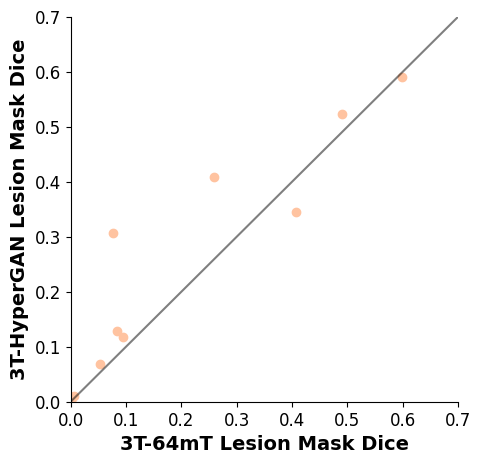

In [390]:
plt.figure(figsize=(5,5))
plt.scatter(dice_3t_64mt, dice_3t_LowGAN)
plt.plot([0,0.7],[0,0.7], color='k', alpha=0.5)
sns.despine()
plt.xlabel('3T-64mT Lesion Mask Dice')
plt.ylabel('3T-LowGAN Lesion Mask Dice')
plt.xlim([0,0.7])
plt.ylim([0,0.7])

In [478]:
stats.ttest_1samp(np.array(dice_3t_64mt)-np.array(dice_3t_LowGAN), popmean=0)

Ttest_1sampResult(statistic=-1.6081799990884418, pvalue=0.13887490905822195)

## Lateral Ventricles

In [35]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_lat_ventricles)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_lat_ventricles)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_lat_ventricles)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:2.223e-22 t=-1.625e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.505e-21 t=1.515e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:7.460e-01 t=1.166e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:9.012e-20 t=-1.423e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:3.673e-19 t=1.378e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.648e-02 t=2.419e+00
Left

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Ventricle  Right Ventricle        Group Subject
0      20944.000000     22350.000000           3T    N037
1      20740.000000     18005.000000           3T    P005
2       6899.000000      8444.000000           3T    P009
3      22694.565545     17423.612745           3T    P023
4      11205.673218      9018.898010           3T    P031
..              ...              ...          ...     ...
166     9341.000000      9191.000000  64mT+LowGAN    P025
167    18451.000000     11556.000000  64mT+LowGAN    N041
168     6077.000000      5847.000000  64mT+LowGAN    P047
169     5940.000000      6698.000000  64mT+LowGAN    N039
170    33358.000000     30810.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

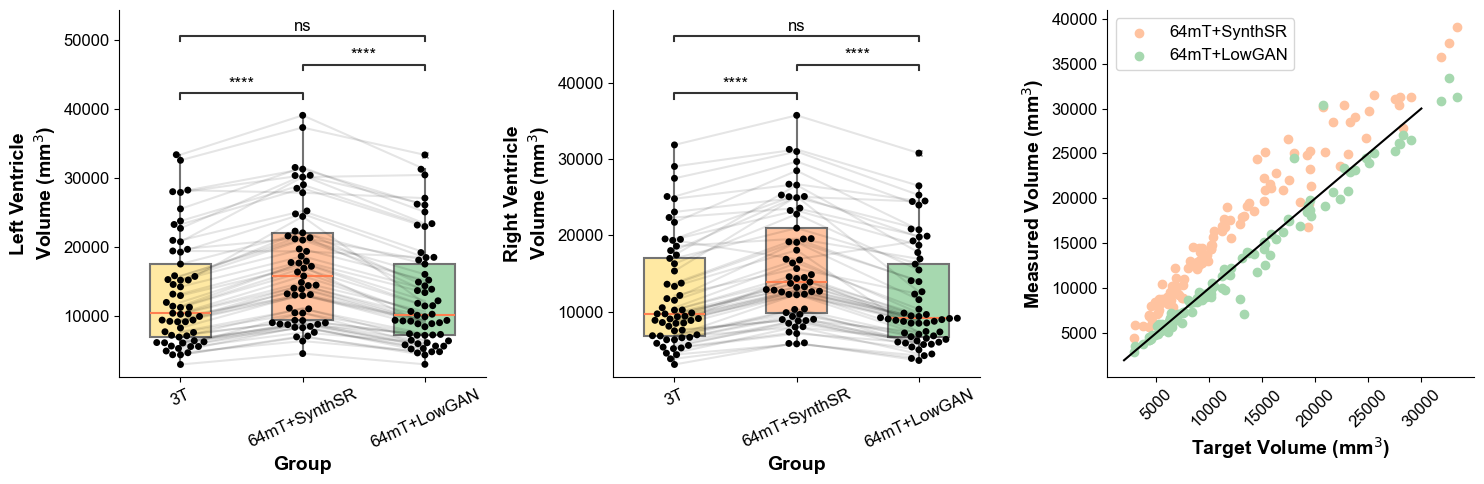

In [36]:
plot_volume_analysis(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Ventricle', [2000,30000])
#plt.savefig(os.path.join(fig_path,'ventricles_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


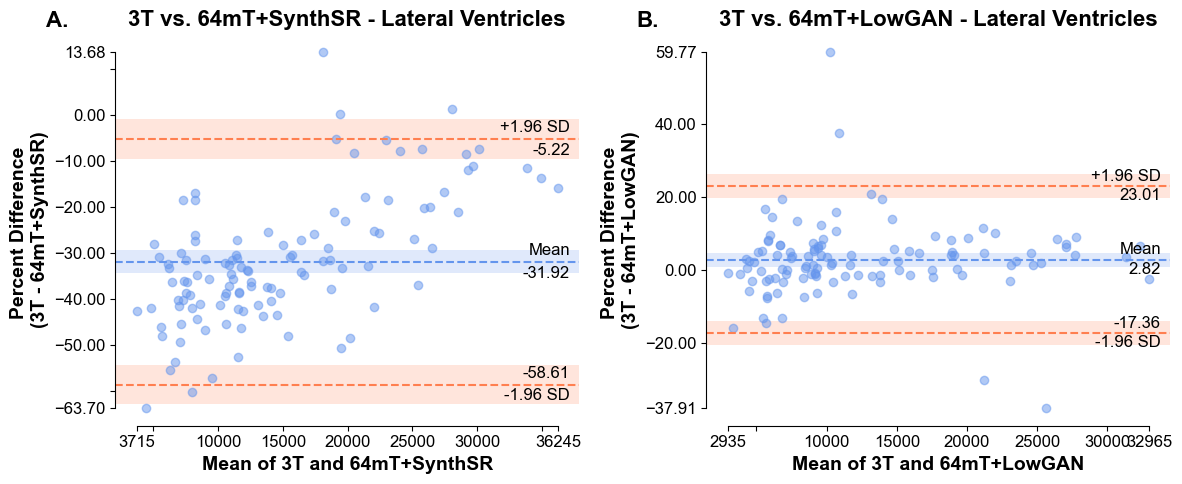

In [37]:
plot_bland_altman(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Lateral Ventricles')
#plt.savefig(os.path.join(fig_path,'ventricles_bland_altman.pdf'))

Left Lateral Ventricles, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=2.4336319373667483, pvalue=0.018164376101163608, df=56) 
Cohen's d:  0.04760555335311713
Volume Difference:  0.00024574368446810365 +/- 0.00010008847103301776

3T vs. 64mT:  TtestResult(statistic=-16.711027936559915, pvalue=2.007875730314076e-23, df=56) 
Cohen's d:  -0.5249460650511758
Volume Difference:  -0.0028979101263558646 +/- 0.00017188514026463786

64mT+LowGAN vs. 64mT:  TtestResult(statistic=-14.946677356390895, pvalue=3.368280657868842e-21, df=56) 
Cohen's d:  -0.5807307896486429
Volume Difference:  -0.003143653810823968 +/- 0.0002084714753796249

Right Lateral Ventricles, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=3.3844066765797125, pvalue=0.0013086673510172766, df=56) 
Cohen's d:  0.07876900914134524
Volume Difference:  0.00037421524369915944 +/- 0.0001095962052641774

3T vs. 64mT:  TtestResult(statistic=-14.40633734834902, pvalue=1.7427074476058976e-20, df=56) 
Cohen's d

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Lateral Ventricles  Right Lateral Ventricles        Group Subject
0                   0.019486                  0.020794           3T    N037
1                   0.006031                  0.005236           3T    P005
2                   0.005526                  0.006763           3T    P009
3                   0.015593                  0.011972           3T    P023
4                   0.008169                  0.006575           3T    P031
..                       ...                       ...          ...     ...
166                 0.006920                  0.006809  64mT+LowGAN    P025
167                 0.011798                  0.007389  64mT+LowGAN    N041
168                 0.003896                  0.003748  64mT+LowGAN    P047
169                 0.004361                  0.004918  64mT+LowGAN    N039
170                 0.023090                  0.021326  64mT+LowGAN    P028

[171 rows x 4 columns]

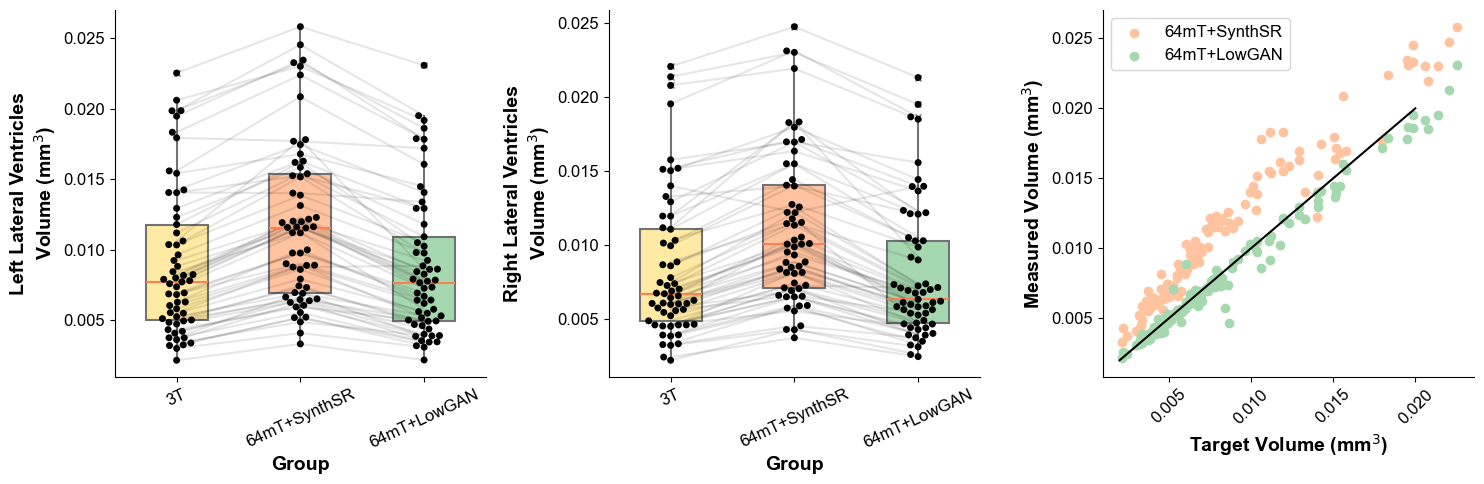

In [38]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Lateral Ventricles', [0.002,0.02], icv)

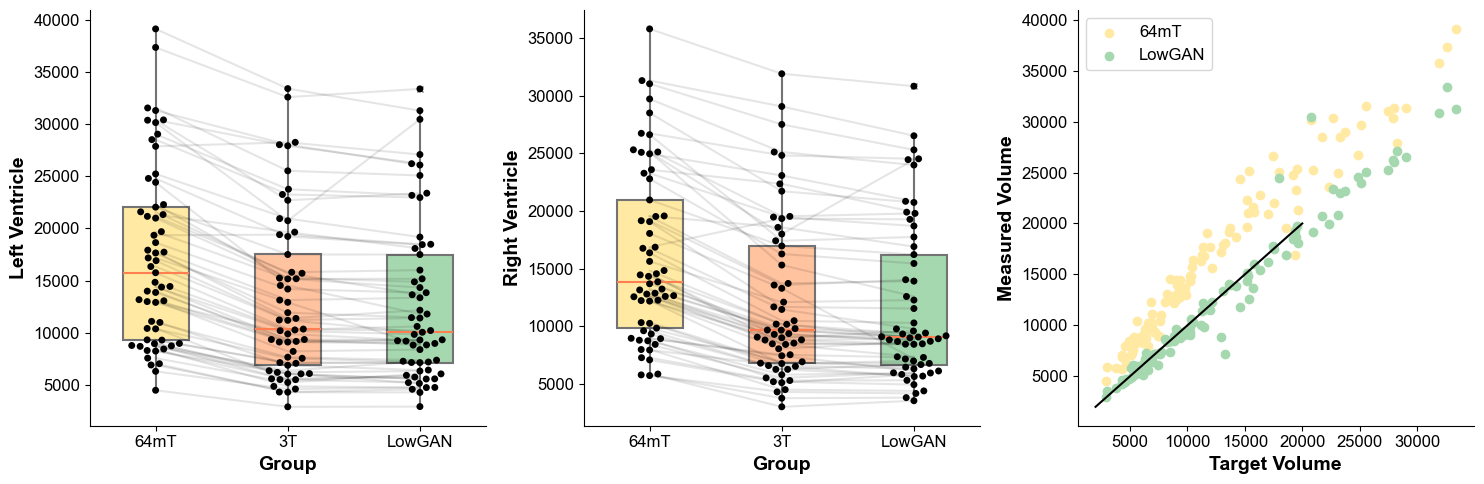

In [39]:
df_ventricle = pd.DataFrame()


df_ventricle['Left Ventricle'] = l_lofi_list+l_hifi_list+l_recon_list
df_ventricle['Right Ventricle'] = r_lofi_list+r_hifi_list+r_recon_list
df_ventricle['Group'] = len(l_lofi_list)*['64mT'] + len(r_lofi_list)*['3T'] + len(r_lofi_list)*['LowGAN']
df_ventricle['Subject'] = sub_list + sub_list + sub_list

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x='Group', y='Left Ventricle', data=df_ventricle, **plot_params)
sns.lineplot(x='Group', y='Left Ventricle', units='Subject', estimator=None,data=df_ventricle, color='k', alpha=0.1)
sns.swarmplot(x='Group', y='Left Ventricle', data=df_ventricle, color='k')
sns.despine()
plt.subplot(1,3,2)
sns.boxplot(x='Group', y='Right Ventricle', data=df_ventricle, **plot_params)
sns.lineplot(x='Group', y='Right Ventricle', units='Subject', estimator=None,data=df_ventricle, color='k', alpha=0.1)
sns.swarmplot(x='Group', y='Right Ventricle', data=df_ventricle, color='k')
sns.despine()
plt.tight_layout()

# scatterplot
plt.subplot(1,3,3)

plt.scatter(x=l_hifi_list, y=l_lofi_list, color=colors[0], label='64mT')
plt.scatter(x=r_hifi_list, y=r_lofi_list, color=colors[0], label=None)

#
plt.scatter(x=l_hifi_list, y=l_recon_list, color=colors[2], label='LowGAN')
plt.scatter(x=r_hifi_list, y=r_recon_list, color=colors[2], label=None)
plt.plot([2000,20000],[2000,20000], color='k')
sns.despine()
plt.xlabel('Target Volume')
plt.ylabel('Measured Volume')
plt.legend()

plt.tight_layout()


In [40]:
from scipy import stats

print('Left Ventricle')
print('3T vs. LowGAN: ',stats.ttest_1samp(df_ventricle[df_ventricle['Group']=='3T']['Left Ventricle'].values-df_ventricle[df_ventricle['Group']=='LowGAN']['Left Ventricle'].values, popmean=0))
print('3T vs. 64mT: ', stats.ttest_1samp(df_ventricle[df_ventricle['Group']=='3T']['Left Ventricle'].values-df_ventricle[df_ventricle['Group']=='64mT']['Left Ventricle'].values, popmean=0))



print('\nRight Ventricle')
print('3T vs. LowGAN: ',stats.ttest_1samp(df_ventricle[df_ventricle['Group']=='3T']['Right Ventricle'].values-df_ventricle[df_ventricle['Group']=='LowGAN']['Right Ventricle'].values, popmean=0))
print('3T vs. 64mT: ', stats.ttest_1samp(df_ventricle[df_ventricle['Group']=='3T']['Right Ventricle'].values-df_ventricle[df_ventricle['Group']=='64mT']['Right Ventricle'].values, popmean=0))



Left Ventricle
3T vs. LowGAN:  TtestResult(statistic=1.1656964133569425, pvalue=0.24867824285856419, df=56)
3T vs. 64mT:  TtestResult(statistic=-16.24921784198742, pvalue=7.408955514425894e-23, df=56)

Right Ventricle
3T vs. LowGAN:  TtestResult(statistic=2.419228897257122, pvalue=0.01882679627898068, df=56)
3T vs. 64mT:  TtestResult(statistic=-14.22992901434606, pvalue=3.0038488323379366e-20, df=56)


## Hippocampus

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.115e-06 t=5.760e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=3.574e-02
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:6.408e-07 t=5.909e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:9.190e-10 t=7.637e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.269e-03 t=-3.286e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.326e-03 t=3.735e+00
Left 

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Hippocampus  Right Hippocampus        Group Subject
0         3086.000000        3026.000000           3T    N037
1         3434.000000        3592.000000           3T    P005
2         4177.000000        4257.000000           3T    P009
3         3718.372528        4327.769822           3T    P023
4         4570.960999        4837.989807           3T    P031
..                ...                ...          ...     ...
166       3724.000000        4452.000000  64mT+LowGAN    P025
167       4591.000000        4798.000000  64mT+LowGAN    N041
168       4652.000000        4952.000000  64mT+LowGAN    P047
169       4173.000000        4106.000000  64mT+LowGAN    N039
170       3813.000000        3828.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

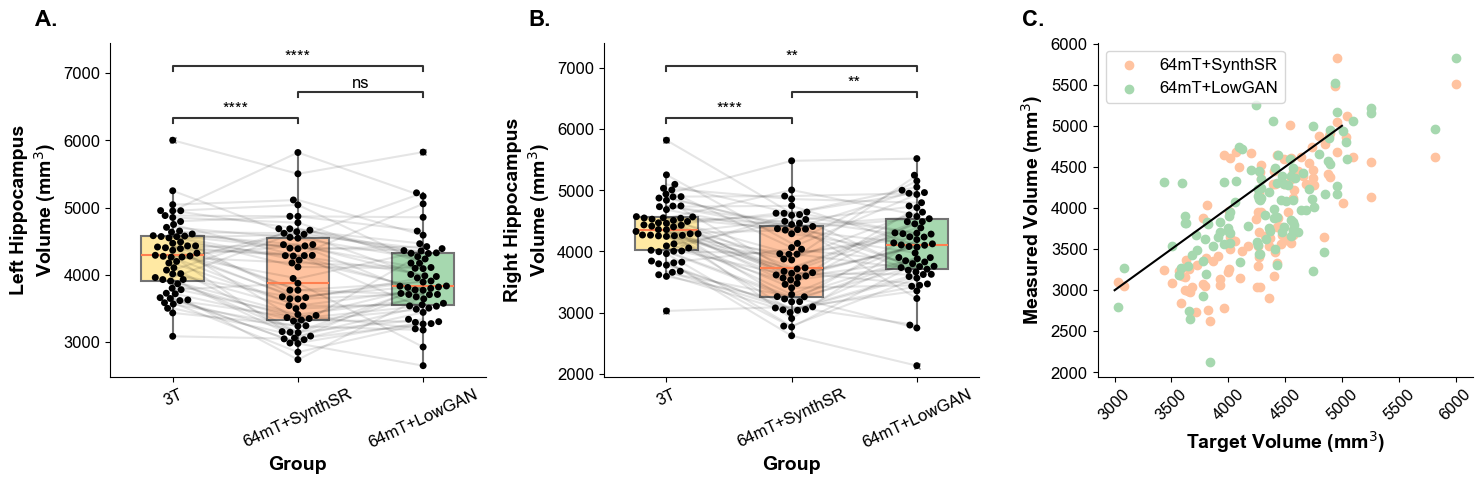

In [42]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_hippocampus)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_hippocampus)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_hippocampus)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Hippocampus', [3000,5000])
#plt.savefig(os.path.join(fig_path,'hippocampus_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


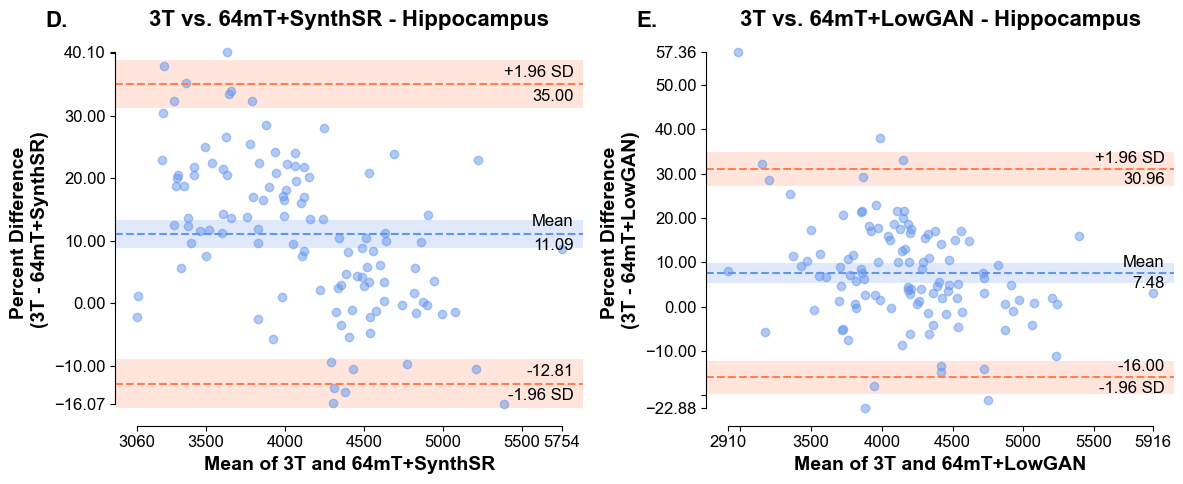

In [43]:
plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Hippocampus')
#plt.savefig(os.path.join(fig_path,'hippocampus_bland_altman.pdf'))

Left Hippocampus, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=6.486605012387921, pvalue=2.4305600086208745e-08, df=56) 
Cohen's d:  0.6286861817463869
Volume Difference:  0.0002482363358113704 +/- 3.7931890168675506e-05

3T vs. 64mT:  TtestResult(statistic=5.759196971747938, pvalue=3.733845885981931e-07, df=56) 
Cohen's d:  0.5041731864501416
Volume Difference:  0.00023585979505641745 +/- 4.059275899520627e-05

64mT+LowGAN vs. 64mT:  TtestResult(statistic=-0.29870921512700777, pvalue=0.7662675916803978, df=56) 
Cohen's d:  -0.027728878547336664
Volume Difference:  -1.237654075495295e-05 +/- 4.1068348735665176e-05

Right Hippocampus, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=4.211266042420081, pvalue=9.30330705787237e-05, df=56) 
Cohen's d:  0.4658414057513277
Volume Difference:  0.00019231384657366238 +/- 4.526415963760267e-05

3T vs. 64mT:  TtestResult(statistic=7.523498732998162, pvalue=4.720615084116682e-10, df=56) 
Cohen's d:  0.8197070238152736


Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Hippocampus  Right Hippocampus        Group Subject
0            0.002871           0.002815           3T    N037
1            0.000999           0.001045           3T    P005
2            0.003346           0.003410           3T    P009
3            0.002555           0.002974           3T    P023
4            0.003332           0.003527           3T    P031
..                ...                ...          ...     ...
166          0.002759           0.003298  64mT+LowGAN    P025
167          0.002936           0.003068  64mT+LowGAN    N041
168          0.002982           0.003174  64mT+LowGAN    P047
169          0.003064           0.003015  64mT+LowGAN    N039
170          0.002639           0.002650  64mT+LowGAN    P028

[171 rows x 4 columns]

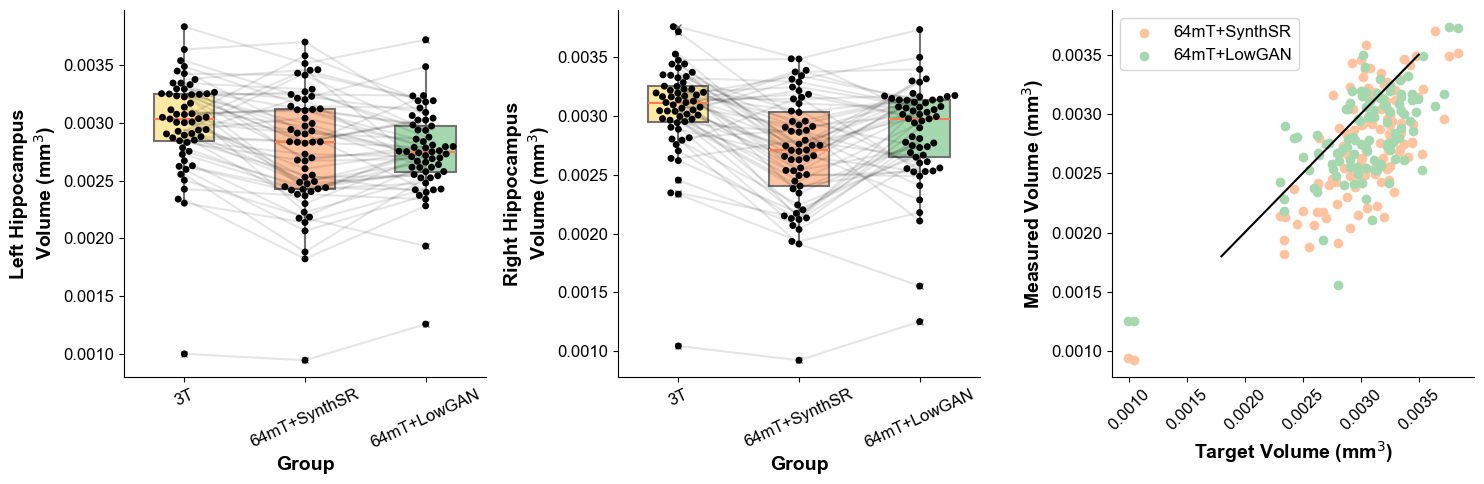

In [44]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Hippocampus', [0.001800,0.003500], icv)

## Amygdala

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.022e-12 t=9.450e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.280e-02 t=-2.446e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:2.069e-06 t=5.594e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:3.688e-12 t=9.103e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:3.335e-01 t=-1.619e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:6.649e-08 t=6.511e+00
Left

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Amygdala  Right Amygdala        Group Subject
0      1282.000000     1285.000000           3T    N037
1      1454.000000     1469.000000           3T    P005
2      1723.000000     1736.000000           3T    P009
3      1604.078634     1742.361275           3T    P023
4      1992.225647     1987.457275           3T    P031
..             ...             ...          ...     ...
166    1462.000000     1610.000000  64mT+LowGAN    P025
167    1879.000000     1575.000000  64mT+LowGAN    N041
168    1684.000000     1634.000000  64mT+LowGAN    P047
169    1502.000000     1544.000000  64mT+LowGAN    N039
170    1601.000000     1329.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

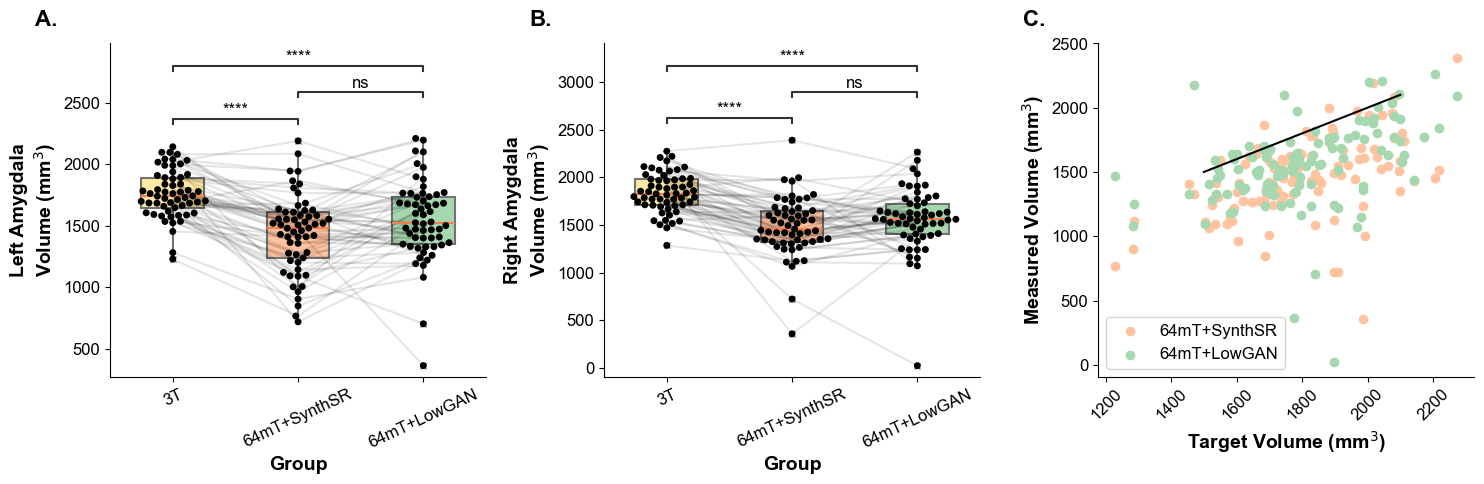

In [45]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_amygdala)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_amygdala)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_amygdala)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Amygdala', [1500,2100])
#plt.savefig(os.path.join(fig_path,'amygdala_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


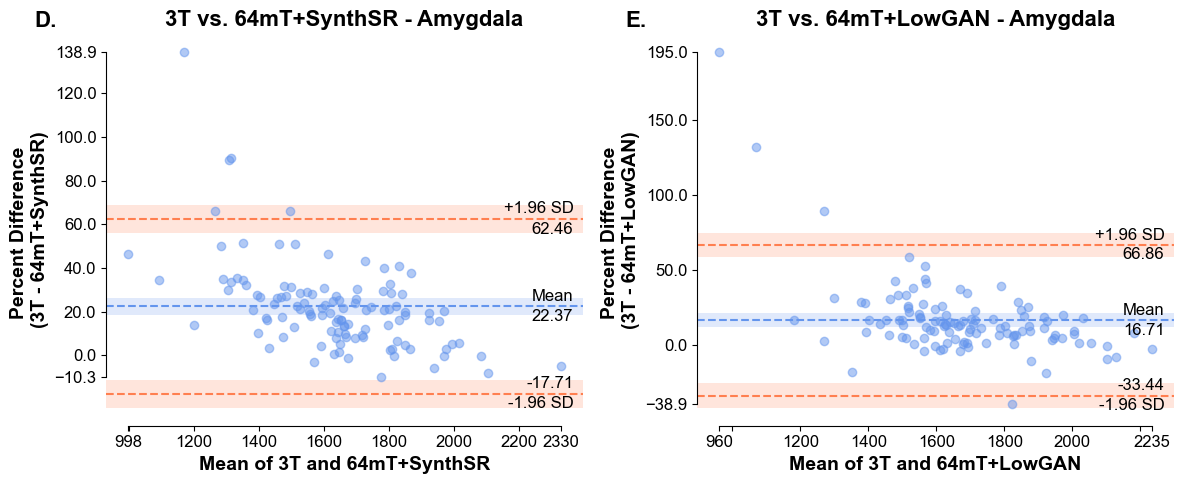

In [46]:
plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Amygdala')
#plt.savefig(os.path.join(fig_path,'amygdala_bland_altman.pdf'))

Left Amygdala, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=5.825943336230801, pvalue=2.912613499267303e-07, df=56) 
Cohen's d:  0.8172453987599008
Volume Difference:  0.0001567961074163359 +/- 2.6676300817972467e-05

3T vs. 64mT:  TtestResult(statistic=9.353826047688232, pvalue=4.859349644220599e-13, df=56) 
Cohen's d:  1.2548737987640182
Volume Difference:  0.0002347214129467411 +/- 2.487253252071593e-05

64mT+LowGAN vs. 64mT:  TtestResult(statistic=2.5188038937949906, pvalue=0.014658319972333264, df=56) 
Cohen's d:  0.3663804081314685
Volume Difference:  7.792530553040521e-05 +/- 3.066484285210371e-05

Right Amygdala, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=6.940631493154157, pvalue=4.337691256323408e-09, df=56) 
Cohen's d:  1.1253060739826455
Volume Difference:  0.00020772642405007943 +/- 2.966534094466995e-05

3T vs. 64mT:  TtestResult(statistic=8.960873632911587, pvalue=2.086157172766926e-12, df=56) 
Cohen's d:  1.30826755849538
Volume Differe

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Amygdala  Right Amygdala        Group Subject
0         0.001193        0.001196           3T    N037
1         0.000423        0.000427           3T    P005
2         0.001380        0.001391           3T    P009
3         0.001102        0.001197           3T    P023
4         0.001452        0.001449           3T    P031
..             ...             ...          ...     ...
166       0.001083        0.001193  64mT+LowGAN    P025
167       0.001201        0.001007  64mT+LowGAN    N041
168       0.001080        0.001047  64mT+LowGAN    P047
169       0.001103        0.001134  64mT+LowGAN    N039
170       0.001108        0.000920  64mT+LowGAN    P028

[171 rows x 4 columns]

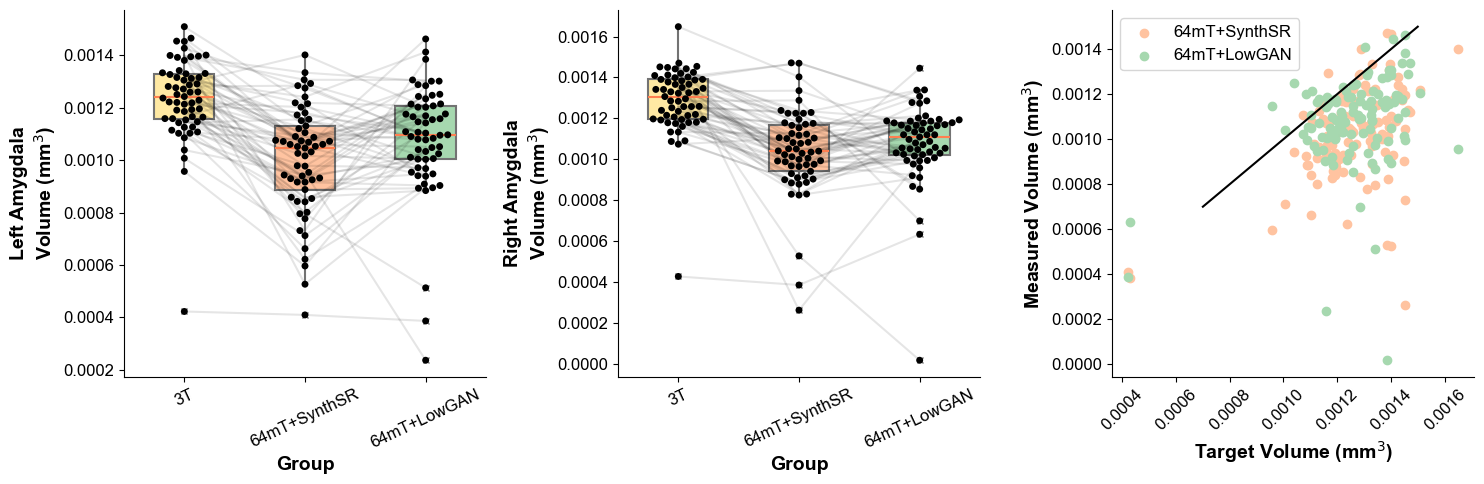

In [47]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Amygdala', [0.0007,0.001500], icv)

## White Matter

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:4.177e-06 t=5.403e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.048e-09 t=-7.190e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:4.293e-02 t=-2.528e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:4.919e-14 t=1.028e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.785e-13 t=-9.927e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.006e-01 t=-2.179e+00
Le

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left White Matter  Right White Matter        Group Subject
0        144891.000000       143033.000000           3T    N037
1        186013.000000       188908.000000           3T    P005
2        185171.000000       185361.000000           3T    P009
3        195248.413148       194403.458529           3T    P023
4        187724.113464       186998.367310           3T    P031
..                 ...                 ...          ...     ...
166      202731.000000       196284.000000  64mT+LowGAN    P025
167      247558.000000       250054.000000  64mT+LowGAN    N041
168      236261.000000       241817.000000  64mT+LowGAN    P047
169      217491.000000       220656.000000  64mT+LowGAN    N039
170      206455.000000       205790.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

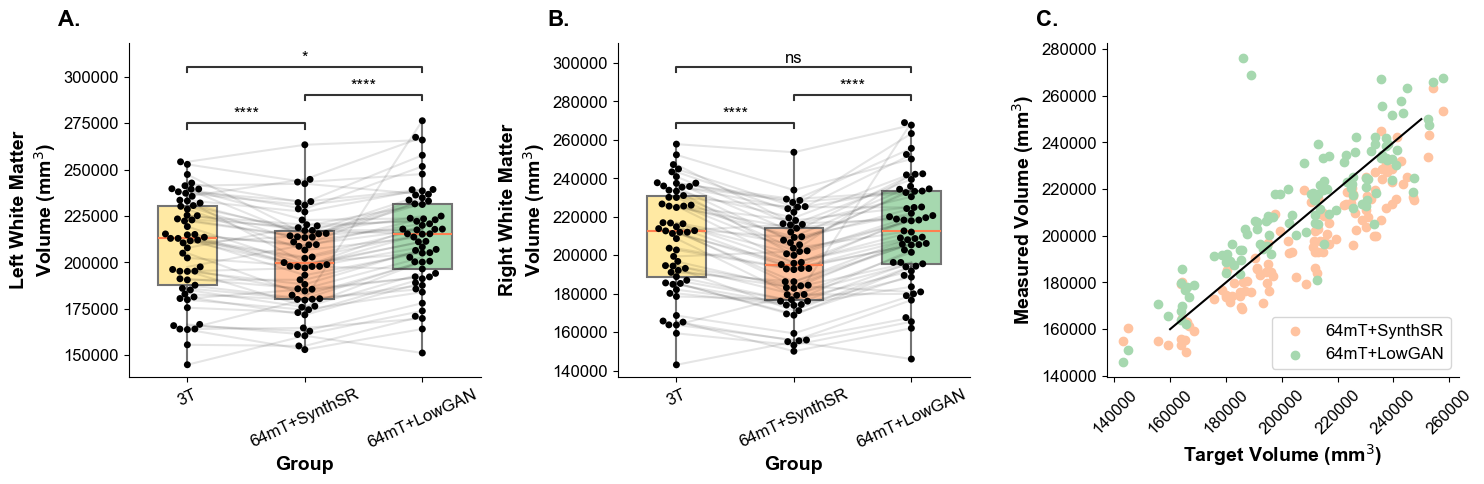

In [48]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_wm)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_wm)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_wm)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'White Matter', [160000,250000])
#plt.savefig(os.path.join(fig_path,'wm_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


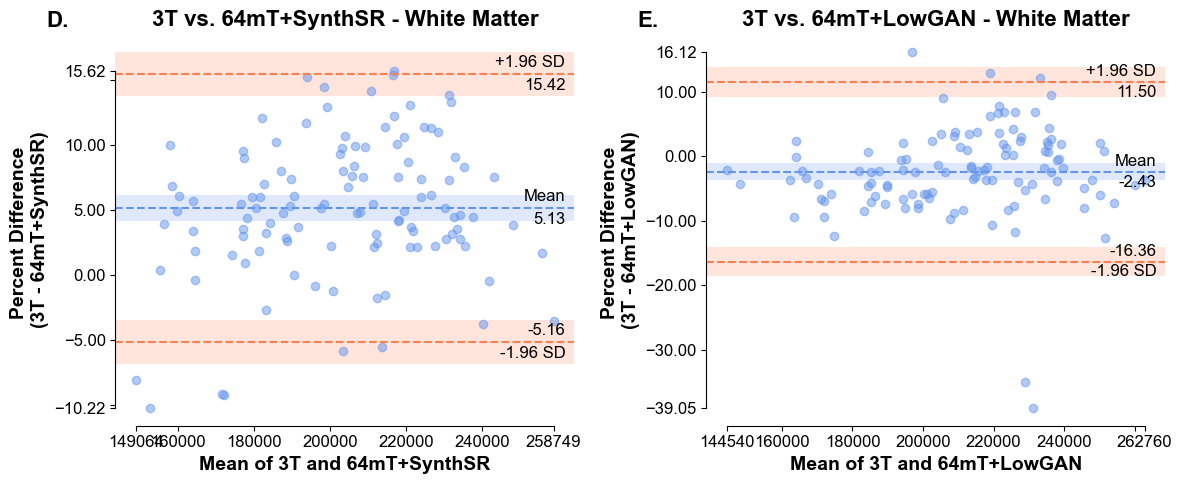

In [49]:
plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'White Matter')
#plt.savefig(os.path.join(fig_path,'wm_bland_altman.pdf'))

Left White Matter, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=-2.7344757132749633, pvalue=0.008349943048596471, df=56) 
Cohen's d:  -0.2096863583563258
Volume Difference:  -0.0031400648476892974 +/- 0.0011382066857287044

3T vs. 64mT:  TtestResult(statistic=5.3572558986965415, pvalue=1.6437196393470718e-06, df=56) 
Cohen's d:  0.3237215123019617
Volume Difference:  0.005294955842754246 +/- 0.0009796626181913582

64mT+LowGAN vs. 64mT:  TtestResult(statistic=10.403672284391583, pvalue=1.068519158352182e-14, df=56) 
Cohen's d:  0.6200834678873492
Volume Difference:  0.008435020690443544 +/- 0.000803629877057342

Right White Matter, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=-2.180482272827433, pvalue=0.033439640685319495, df=56) 
Cohen's d:  -0.15855588677112467
Volume Difference:  -0.0023744731989274476 +/- 0.001079372371762571

3T vs. 64mT:  TtestResult(statistic=9.979687551876955, pvalue=4.921788137250051e-14, df=56) 
Cohen's d:  0.5999222642307672
V

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left White Matter  Right White Matter        Group Subject
0             0.134802            0.133074           3T    N037
1             0.054093            0.054935           3T    P005
2             0.148318            0.148471           3T    P009
3             0.134153            0.133572           3T    P023
4             0.136849            0.136320           3T    P031
..                 ...                 ...          ...     ...
166           0.150189            0.145413  64mT+LowGAN    P025
167           0.158295            0.159891  64mT+LowGAN    N041
168           0.151454            0.155016  64mT+LowGAN    P047
169           0.159678            0.162002  64mT+LowGAN    N039
170           0.142907            0.142446  64mT+LowGAN    P028

[171 rows x 4 columns]

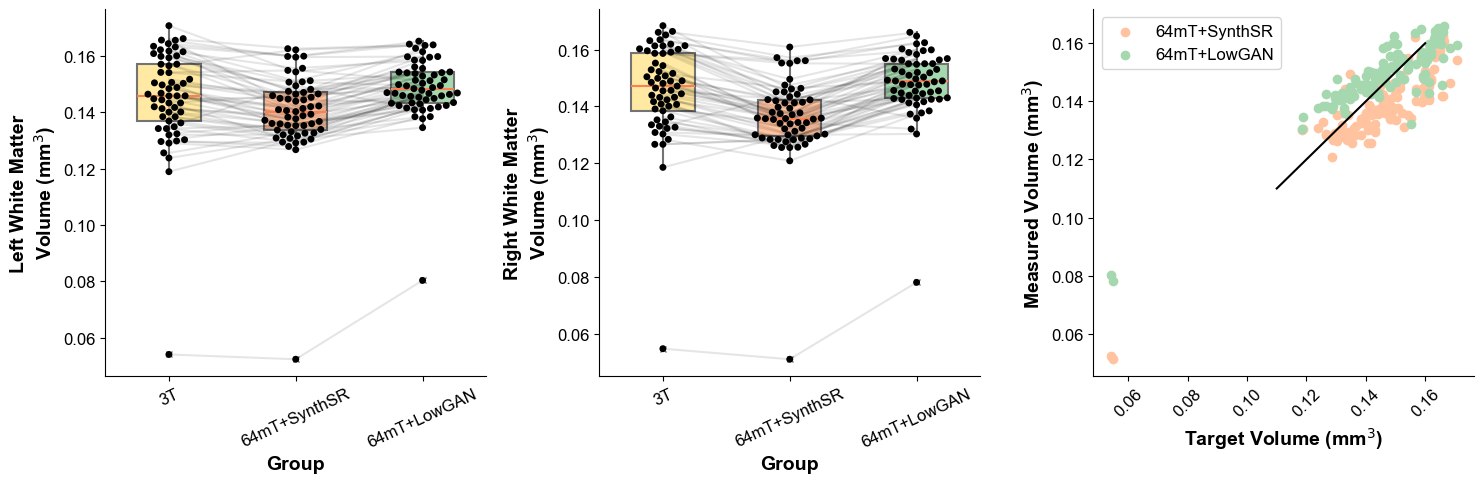

In [50]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'White Matter', [0.11,0.1600], icv)

## Gray Matter

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:2.380e-15 t=1.114e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.648e-09 t=-7.484e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-4.906e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.360e-22 t=1.642e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:2.599e-15 t=-1.111e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-6.546e-01
Le

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Gray Matter  Right Gray Matter        Group Subject
0       182228.000000       178728.00000           3T    N037
1       216952.000000       216534.00000           3T    P005
2       229276.000000       229915.00000           3T    P009
3       233765.373825       234589.34763           3T    P023
4       236724.853516       238950.72937           3T    P031
..                ...                ...          ...     ...
166     234260.000000       237013.00000  64mT+LowGAN    P025
167     265656.000000       269148.00000  64mT+LowGAN    N041
168     262541.000000       269122.00000  64mT+LowGAN    P047
169     237878.000000       245160.00000  64mT+LowGAN    N039
170     236036.000000       238341.00000  64mT+LowGAN    P028

[171 rows x 4 columns]

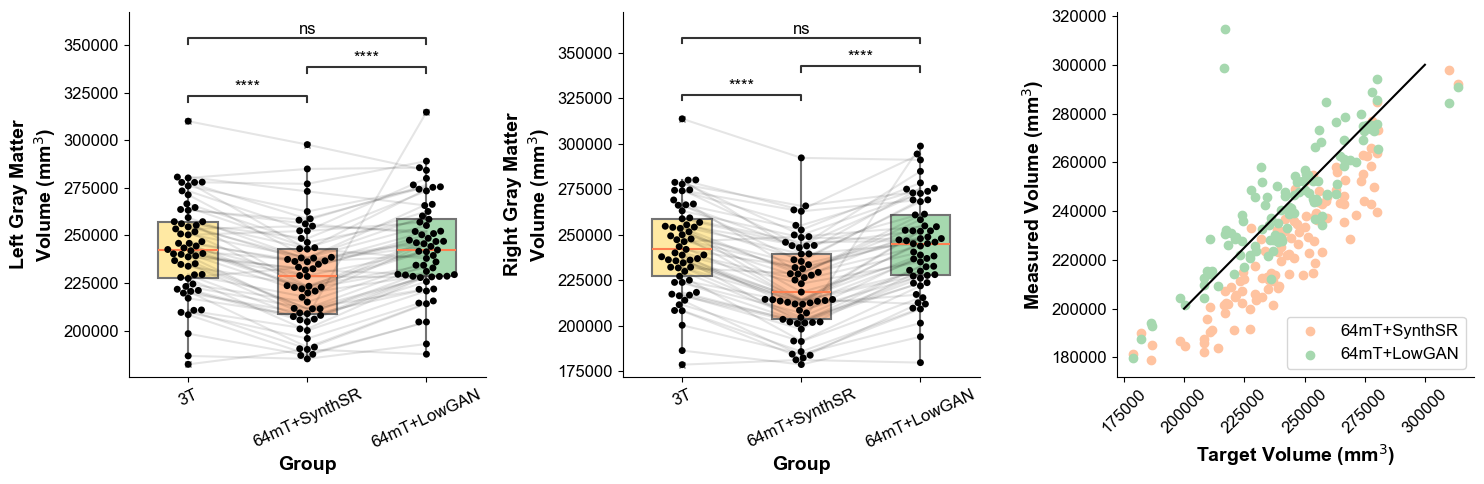

In [51]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_gm)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_gm)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_gm)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Gray Matter', [200000,300000])
#plt.savefig(os.path.join(fig_path,'gm_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


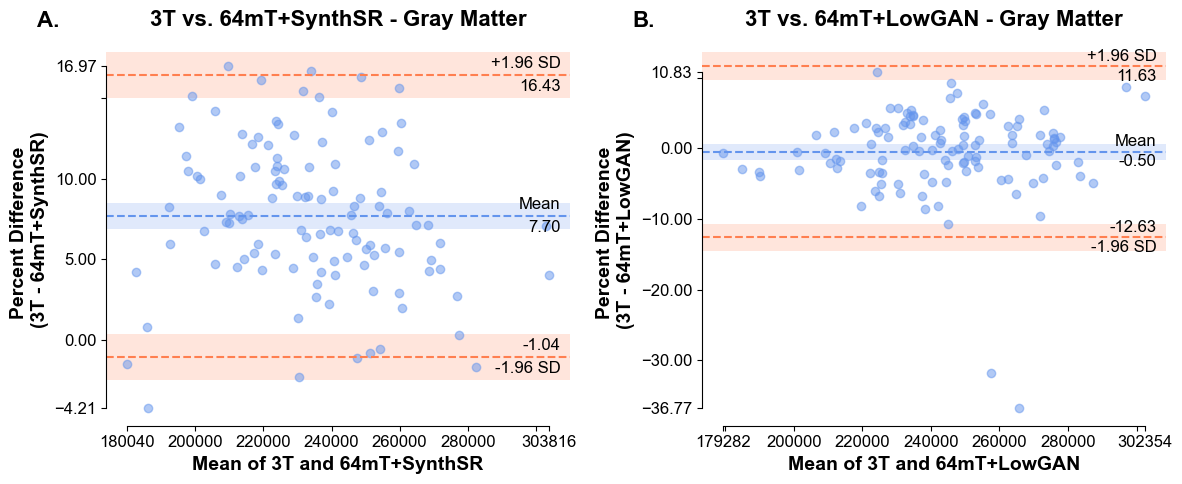

In [52]:
plot_bland_altman(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Gray Matter')
#plt.savefig(os.path.join(fig_path,'gm_bland_altman.pdf'))

Left Gray Matter, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=0.0377418706215601, pvalue=0.9700277162035202, df=56) 
Cohen's d:  0.00268686832811376
Volume Difference:  4.0899165084129786e-05 +/- 0.0010741071474576166

3T vs. 64mT:  TtestResult(statistic=10.633047997113154, pvalue=4.716655869399501e-15, df=56) 
Cohen's d:  0.6150294974037155
Volume Difference:  0.010541222931220468 +/- 0.0009826295256821738

64mT+LowGAN vs. 64mT:  TtestResult(statistic=10.247985870935567, pvalue=1.8678425804709675e-14, df=56) 
Cohen's d:  0.7272762940396589
Volume Difference:  0.010500323766136337 +/- 0.0010155954768130344

Right Gray Matter, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=-0.18534014205470745, pvalue=0.8536319151243172, df=56) 
Cohen's d:  -0.01283510177026136
Volume Difference:  -0.00019308420613732045 +/- 0.0010326040997985617

3T vs. 64mT:  TtestResult(statistic=15.609516890926814, pvalue=4.708746580688067e-22, df=56) 
Cohen's d:  0.8796009951241633
Vo

/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning:

5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
   

     Left Gray Matter  Right Gray Matter        Group Subject
0            0.169539           0.166283           3T    N037
1            0.063090           0.062968           3T    P005
2            0.183646           0.184158           3T    P009
3            0.160617           0.161183           3T    P023
4            0.172570           0.174192           3T    P031
..                ...                ...          ...     ...
166          0.173547           0.175586  64mT+LowGAN    P025
167          0.169867           0.172100  64mT+LowGAN    N041
168          0.168301           0.172519  64mT+LowGAN    P047
169          0.174646           0.179992  64mT+LowGAN    N039
170          0.163382           0.164978  64mT+LowGAN    P028

[171 rows x 4 columns]

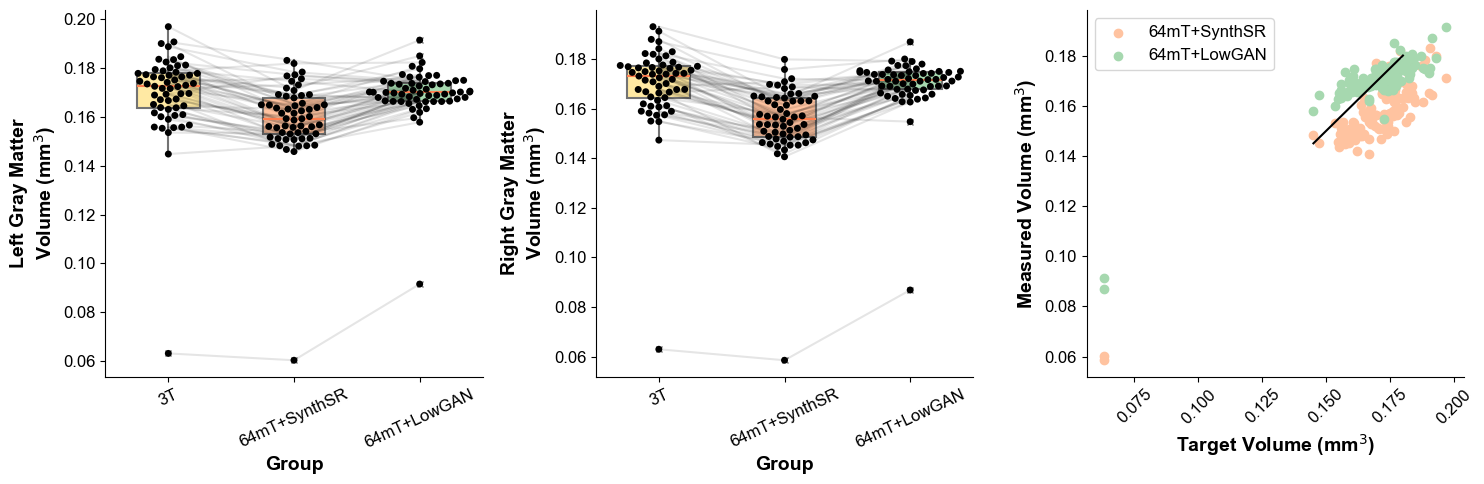

In [53]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Gray Matter', [0.145,0.1800], icv)

## Putamen

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.372e-02 t=2.955e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.234e-10 t=8.167e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:2.061e-14 t=1.053e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.096e-04 t=4.486e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:9.532e-09 t=7.022e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:3.795e-14 t=1.036e+01
Left P

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Putamen  Right Putamen        Group Subject
0     4457.000000    4144.000000           3T    N037
1     4890.000000    4662.000000           3T    P005
2     4536.000000    4271.000000           3T    P009
3     4919.047320    5185.122195           3T    P023
4     4830.360413    4961.967468           3T    P031
..            ...            ...          ...     ...
166   3721.000000    3319.000000  64mT+LowGAN    P025
167   5500.000000    5460.000000  64mT+LowGAN    N041
168   5101.000000    5049.000000  64mT+LowGAN    P047
169   5132.000000    5124.000000  64mT+LowGAN    N039
170   3901.000000    3661.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

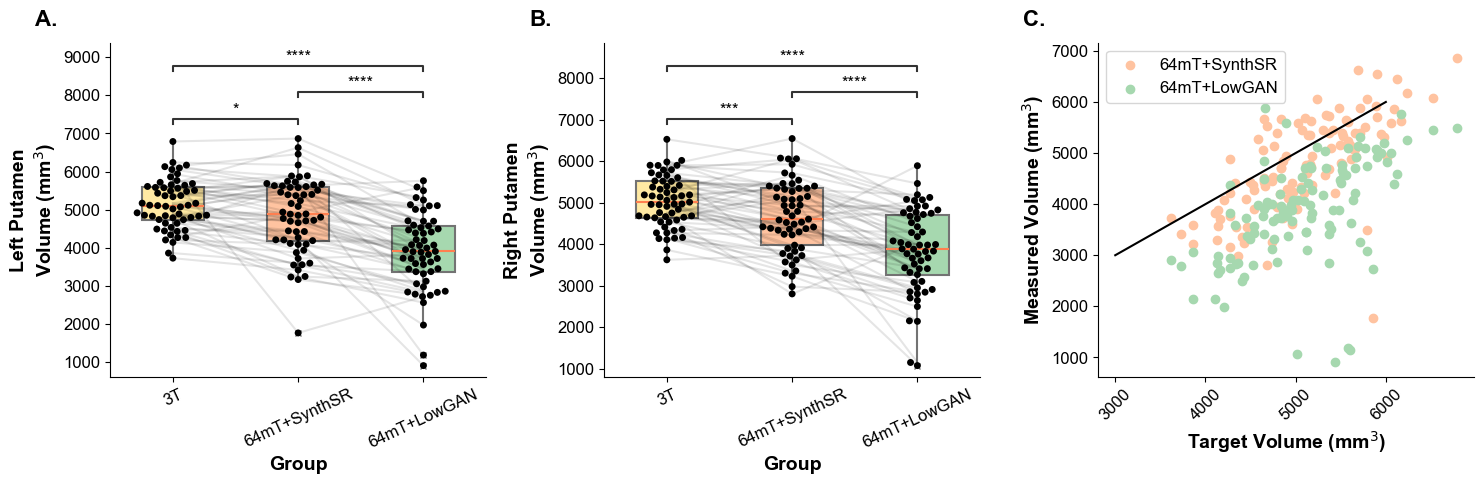

In [54]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_putamen)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_putamen)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_putamen)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Putamen', [3000,6000])
#plt.savefig(os.path.join(fig_path,'putamen_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


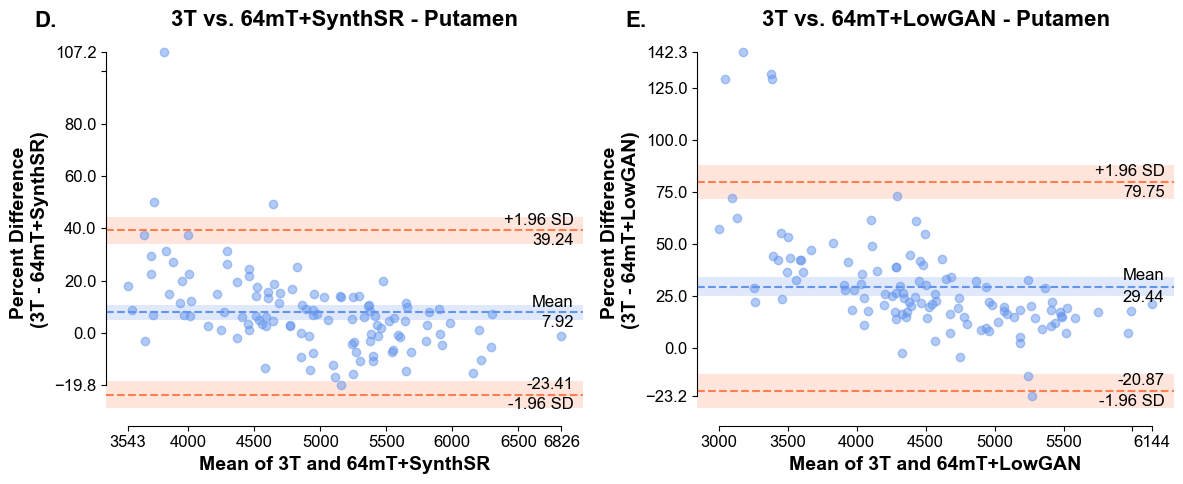

In [55]:
plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Putamen')
#plt.savefig(os.path.join(fig_path,'putamen_bland_altman.pdf'))

Left Putamen, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=10.675071447949415, pvalue=4.063115102241111e-15, df=56) 
Cohen's d:  1.618550769597373
Volume Difference:  0.0008917850042805633 +/- 8.280297877427286e-05

3T vs. 64mT:  TtestResult(statistic=3.0219867084450454, pvalue=0.0037818397838850796, df=56) 
Cohen's d:  0.3804045954010754
Volume Difference:  0.00021894124325886266 +/- 7.181110602245627e-05

64mT+LowGAN vs. 64mT:  TtestResult(statistic=-8.277469944444194, pvalue=2.707749631005262e-11, df=56) 
Cohen's d:  -1.0529126288048656
Volume Difference:  -0.0006728437610217005 +/- 8.056997018121846e-05

Right Putamen, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=10.710663844968257, pvalue=3.581525944209524e-15, df=56) 
Cohen's d:  1.5937679286535953
Volume Difference:  0.0008540361574387261 +/- 7.903445345420122e-05

3T vs. 64mT:  TtestResult(statistic=4.4281620307011424, pvalue=4.455962150709698e-05, df=56) 
Cohen's d:  0.49359348905448874
Volume D

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Putamen  Right Putamen        Group Subject
0        0.004147       0.003855           3T    N037
1        0.001422       0.001356           3T    P005
2        0.003633       0.003421           3T    P009
3        0.003380       0.003563           3T    P023
4        0.003521       0.003617           3T    P031
..            ...            ...          ...     ...
166      0.002757       0.002459  64mT+LowGAN    P025
167      0.003517       0.003491  64mT+LowGAN    N041
168      0.003270       0.003237  64mT+LowGAN    P047
169      0.003768       0.003762  64mT+LowGAN    N039
170      0.002700       0.002534  64mT+LowGAN    P028

[171 rows x 4 columns]

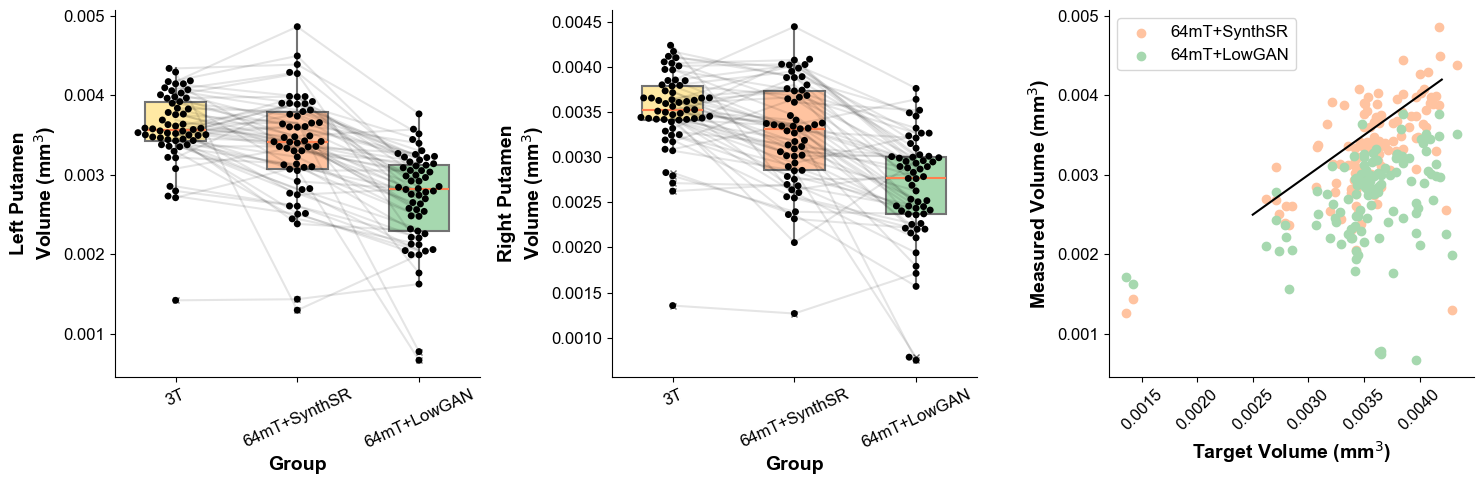

In [56]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Putamen', [0.0025,0.0042], icv)

## Pallidum

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.552e-01 t=-1.988e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:9.023e-13 t=9.484e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:3.703e-09 t=7.271e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-5.423e-01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.555e-09 t=7.499e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:2.222e-09 t=7.405e+00
Left

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Pallidum  Right Pallidum        Group Subject
0      1302.000000     1246.000000           3T    N037
1      1701.000000     1657.000000           3T    P005
2      1504.000000     1398.000000           3T    P009
3      1482.008440     1481.054767           3T    P023
4      1413.345337     1427.650452           3T    P031
..             ...             ...          ...     ...
166    1439.000000      953.000000  64mT+LowGAN    P025
167    2018.000000     1929.000000  64mT+LowGAN    N041
168    1317.000000     1663.000000  64mT+LowGAN    P047
169    1660.000000     1738.000000  64mT+LowGAN    N039
170    1178.000000      787.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

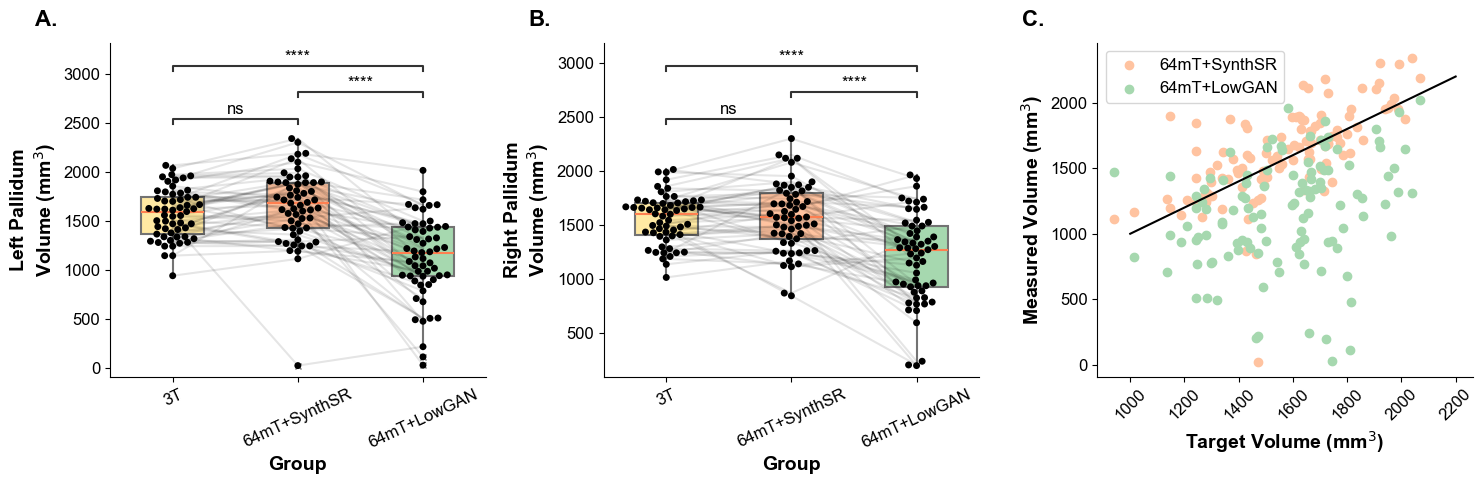

In [57]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_pallidum)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_pallidum)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_pallidum)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Pallidum', [1000,2200])
#plt.savefig(os.path.join(fig_path,'pallidum_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


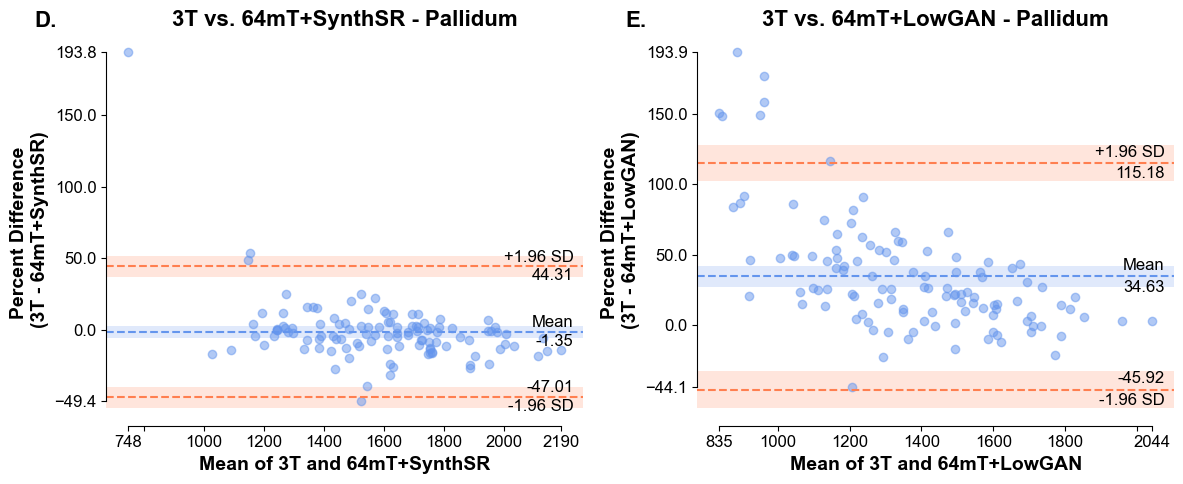

In [58]:
plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Pallidum')
#plt.savefig(os.path.join(fig_path,'pallidum_bland_altman.pdf'))

Left Pallidum, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=7.162860321287304, pvalue=1.8622160645211962e-09, df=56) 
Cohen's d:  1.2963970887255005
Volume Difference:  0.0003164886524621533 +/- 4.3795374718809696e-05

3T vs. 64mT:  TtestResult(statistic=-1.802286421047712, pvalue=0.07688310675866658, df=56) 
Cohen's d:  -0.22450255592894927
Volume Difference:  -5.036709830556944e-05 +/- 2.7699996011472338e-05

64mT+LowGAN vs. 64mT:  TtestResult(statistic=-9.244769966368917, pvalue=7.270822516123484e-13, df=56) 
Cohen's d:  -1.3467041930623331
Volume Difference:  -0.0003668557507677226 +/- 3.933288549381226e-05

Right Pallidum, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=7.5820329975113525, pvalue=3.7785402965610427e-10, df=56) 
Cohen's d:  1.1888524102477829
Volume Difference:  0.0002623401762803192 +/- 3.429538807307706e-05

3T vs. 64mT:  TtestResult(statistic=-0.43556143958217375, pvalue=0.6648292514133531, df=56) 
Cohen's d:  -0.0465611750116507
Vol

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Pallidum  Right Pallidum        Group Subject
0         0.001211        0.001159           3T    N037
1         0.000495        0.000482           3T    P005
2         0.001205        0.001120           3T    P009
3         0.001018        0.001018           3T    P023
4         0.001030        0.001041           3T    P031
..             ...             ...          ...     ...
166       0.001066        0.000706  64mT+LowGAN    P025
167       0.001290        0.001233  64mT+LowGAN    N041
168       0.000844        0.001066  64mT+LowGAN    P047
169       0.001219        0.001276  64mT+LowGAN    N039
170       0.000815        0.000545  64mT+LowGAN    P028

[171 rows x 4 columns]

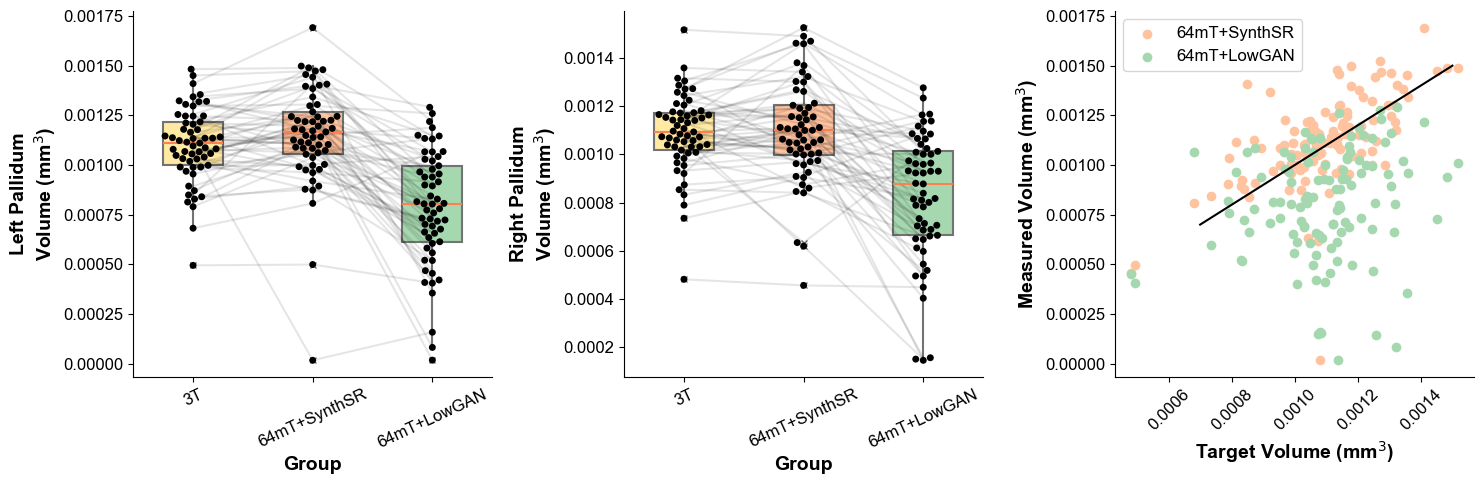

In [59]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Pallidum', [0.0007,0.0015], icv)

## Caudate

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:5.197e-01 t=1.379e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:9.942e-01 t=-9.798e-01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-1.196e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:3.524e-04 t=4.142e+00
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:9.257e-03 t=-3.093e+00
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-3.128e-01
Le

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Caudate  Right Caudate        Group Subject
0     3098.000000    3036.000000           3T    N037
1     2967.000000    2875.000000           3T    P005
2     3369.000000    3337.000000           3T    P009
3     3576.275194    3740.307016           3T    P023
4     3458.976746    3412.246704           3T    P031
..            ...            ...          ...     ...
166   3305.000000    3916.000000  64mT+LowGAN    P025
167   4512.000000    4738.000000  64mT+LowGAN    N041
168   4200.000000    4520.000000  64mT+LowGAN    P047
169   4066.000000    3899.000000  64mT+LowGAN    N039
170   4309.000000    4683.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

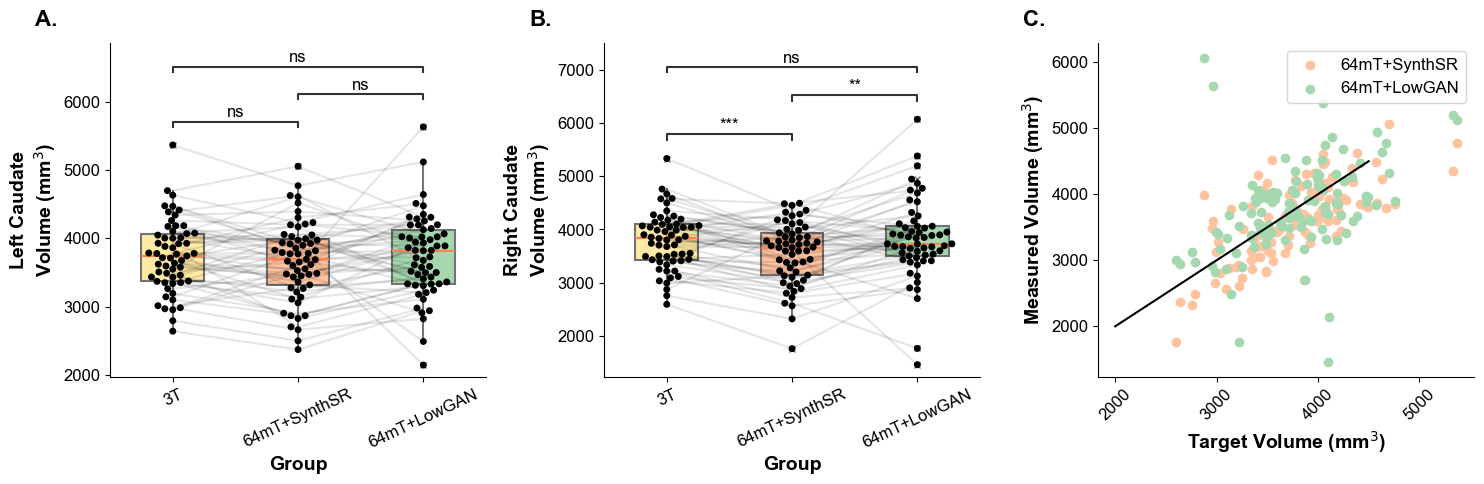

In [60]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, lr_caudate)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, lr_caudate)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, lr_caudate)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis_labeled(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Caudate', [2000,4500])
#plt.savefig(os.path.join(fig_path,'caudate_volumes.pdf'))

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


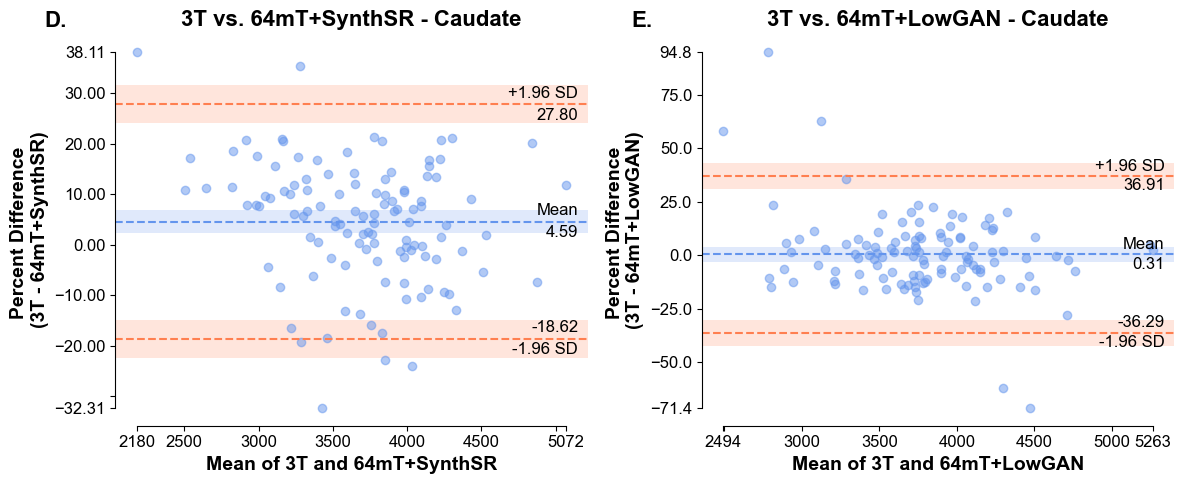

In [61]:
plot_bland_altman2(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Caudate')
#plt.savefig(os.path.join(fig_path,'caudate_bland_altman.pdf'))

Left Caudate, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=0.38815071345644786, pvalue=0.6993761658635849, df=56) 
Cohen's d:  0.04312464183285082
Volume Difference:  1.7045275885890732e-05 +/- 4.352714997176175e-05

3T vs. 64mT:  TtestResult(statistic=1.5983524695830988, pvalue=0.11559229778839808, df=56) 
Cohen's d:  0.15044026820885079
Volume Difference:  6.139729605493642e-05 +/- 3.8074418082748815e-05

64mT+LowGAN vs. 64mT:  TtestResult(statistic=0.9001859171332527, pvalue=0.3718762357865284, df=56) 
Cohen's d:  0.11144875469790641
Volume Difference:  4.4352020169045685e-05 +/- 4.883574050373457e-05

Right Caudate, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=0.058210059682722866, pvalue=0.9537885266464567, df=56) 
Cohen's d:  0.0077670779309331256
Volume Difference:  3.4291011961313803e-06 +/- 5.839004942414052e-05

3T vs. 64mT:  TtestResult(statistic=4.765432837369201, pvalue=1.378713252641305e-05, df=56) 
Cohen's d:  0.4260010074528084
Volume Dif

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Caudate  Right Caudate        Group Subject
0        0.002882       0.002825           3T    N037
1        0.000863       0.000836           3T    P005
2        0.002699       0.002673           3T    P009
3        0.002457       0.002570           3T    P023
4        0.002522       0.002487           3T    P031
..            ...            ...          ...     ...
166      0.002448       0.002901  64mT+LowGAN    P025
167      0.002885       0.003030  64mT+LowGAN    N041
168      0.002692       0.002898  64mT+LowGAN    P047
169      0.002985       0.002863  64mT+LowGAN    N039
170      0.002983       0.003242  64mT+LowGAN    P028

[171 rows x 4 columns]

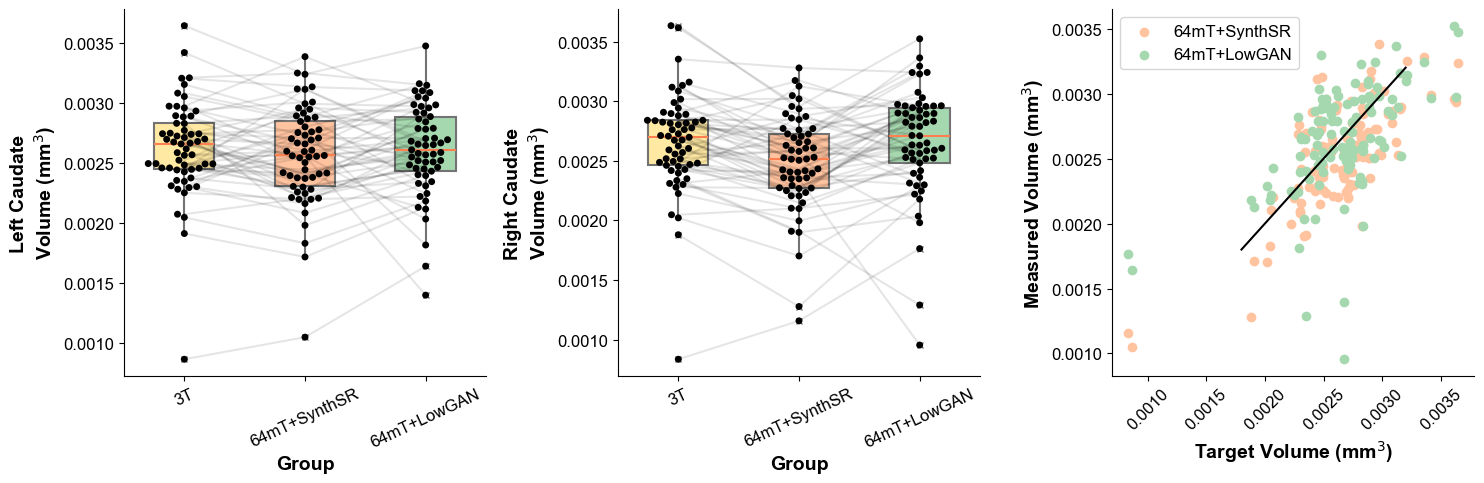

In [62]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Caudate', [0.0018,0.0032], icv)

## Sulcal CSF

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:2.595e-23 t=-1.701e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:4.362e-35 t=2.919e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.356e-19 t=1.366e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3T vs. 64mT+SynthSR: t-test paired samples with Bonferroni correction, P_val:2.595e-23 t=-1.701e+01
64mT+SynthSR vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:4.362e-35 t=2.919e+01
3T vs. 64mT+LowGAN: t-test paired samples with Bonferroni correction, P_val:5.356e-19 t=1.366e+01
Left

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Sulcal CSF  Right Sulcal CSF        Group Subject
0      313014.000000     313014.000000           3T    N037
1      288544.000000     288544.000000           3T    P005
2      278582.000000     278582.000000           3T    P009
3      341518.068586     341518.068586           3T    P023
4      307506.561279     307506.561279           3T    P031
..               ...               ...          ...     ...
166    228494.000000     228494.000000  64mT+LowGAN    P025
167    264054.000000     264054.000000  64mT+LowGAN    N041
168    281907.000000     281907.000000  64mT+LowGAN    P047
169    237550.000000     237550.000000  64mT+LowGAN    N039
170    264949.000000     264949.000000  64mT+LowGAN    P028

[171 rows x 4 columns]

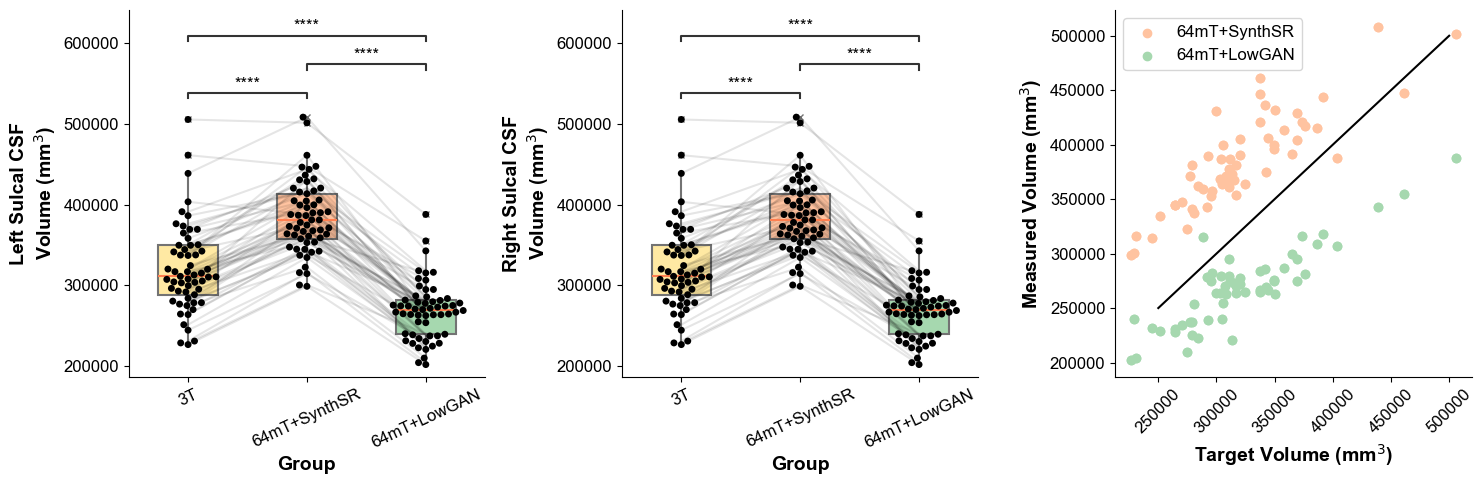

In [63]:
lofi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_SynthSR'
hifi_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_3T'
recon_synthseg_outputs = '/mnt/leif/littlab/users/cvadali/LowGAN_leave_one_out/output/SynthSeg_LowGAN'

l_recon_list = []
r_recon_list = []

l_lofi_list = []
r_lofi_list = []

l_hifi_list = []
r_hifi_list = []

sub_list = []

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_synth_T1_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_T1_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_LowGAN_T1_SynthSeg.nii.gz')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = nib.load(seg_lofi_path)
        l_lofi, r_lofi = calculate_volume(lofi_seg, csf)
        
        
        # hifi
        hifi_seg = nib.load(seg_hifi_path)
        l_hifi, r_hifi = calculate_volume(hifi_seg, csf)
        
        # recon
        recon_seg = nib.load(seg_recon_path)
        l_recon, r_recon = calculate_volume(recon_seg, csf)
        
        # append the lists
        l_lofi_list.append(l_lofi)
        r_lofi_list.append(r_lofi)
    
        l_hifi_list.append(l_hifi)
        r_hifi_list.append(r_hifi)

        l_recon_list.append(l_recon)
        r_recon_list.append(r_recon)
        
        sub_list.append(sub)

# plot the data
plot_volume_analysis(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Sulcal CSF', [250000,500000])

The Bias in the plot is: lofi-hifi
The Bias in the plot is: recon-hifi


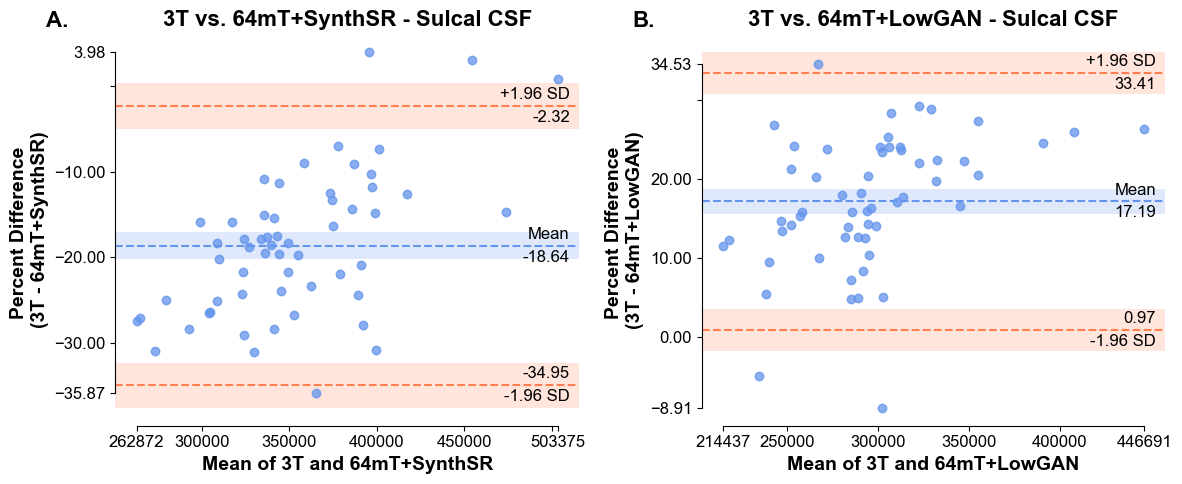

In [64]:
plot_bland_altman(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, 'Sulcal CSF')

Left Sulcal CSF, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=14.289602476591702, pvalue=2.4974911849276102e-20, df=56) 
Cohen's d:  1.3249990316862614
Volume Difference:  0.03691780094260494 +/- 0.0025607799582531327

3T vs. 64mT:  TtestResult(statistic=-16.65953572087074, pvalue=2.3197339774504505e-23, df=56) 
Cohen's d:  -1.3503493739643313
Volume Difference:  -0.04483357320270862 +/- 0.002667454651303178

64mT+LowGAN vs. 64mT:  TtestResult(statistic=-26.686080424208285, pvalue=1.579729818804348e-33, df=56) 
Cohen's d:  -3.0890547317505033
Volume Difference:  -0.08175137414531355 +/- 0.003036455050444241

Right Sulcal CSF, one-sample t-test
3T vs. 64mT+LowGAN:  TtestResult(statistic=14.289602476591702, pvalue=2.4974911849276102e-20, df=56) 
Cohen's d:  1.3249990316862614
Volume Difference:  0.03691780094260494 +/- 0.0025607799582531327

3T vs. 64mT:  TtestResult(statistic=-16.65953572087074, pvalue=2.3197339774504505e-23, df=56) 
Cohen's d:  -1.3503493739643313
Volum

Traceback (most recent call last):
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
           ^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/leif/littlab/users/cvadali/anaconda3/envs/LowGAN/lib/python3.11/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
            ^^^^^^^^^^^^^
  

     Left Sulcal CSF  Right Sulcal CSF        Group Subject
0           0.291219          0.291219           3T    N037
1           0.083909          0.083909           3T    P005
2           0.223139          0.223139           3T    P009
3           0.234653          0.234653           3T    P023
4           0.224169          0.224169           3T    P031
..               ...               ...          ...     ...
166         0.169275          0.169275  64mT+LowGAN    P025
167         0.168843          0.168843  64mT+LowGAN    N041
168         0.180715          0.180715  64mT+LowGAN    P047
169         0.174405          0.174405  64mT+LowGAN    N039
170         0.183396          0.183396  64mT+LowGAN    P028

[171 rows x 4 columns]

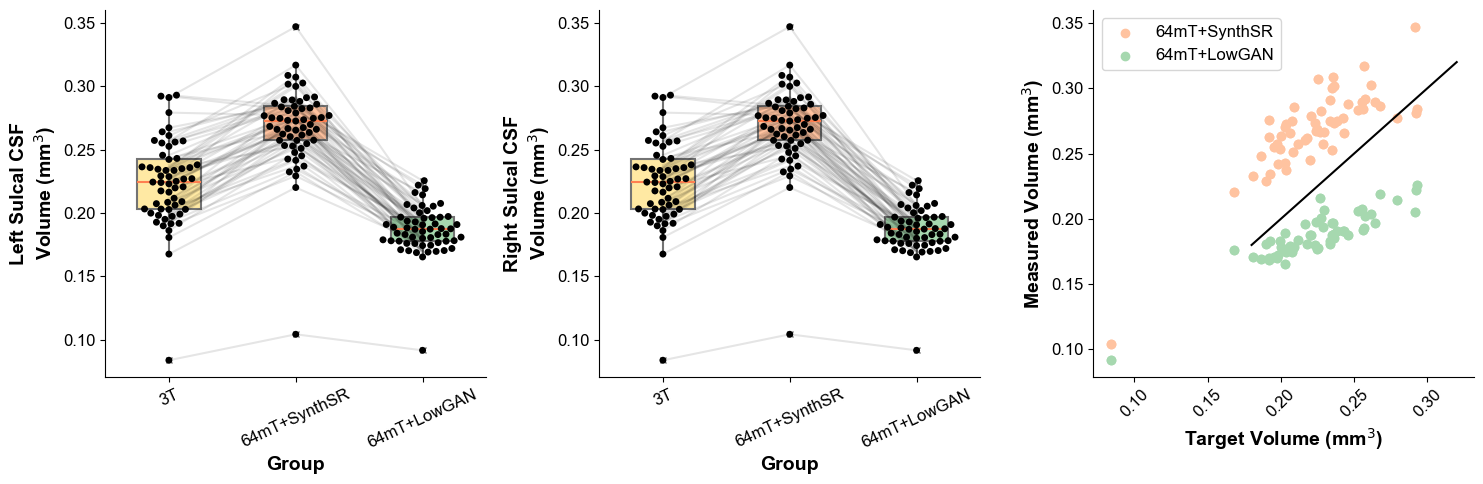

In [65]:
plot_volume_analysis_icv_regressed(l_lofi_list, r_lofi_list, l_hifi_list, r_hifi_list, l_recon_list, r_recon_list, sub_list, 'Sulcal CSF', [0.18,0.32], icv)

## Dice overlap of volume segmentations

This analysis compares the Dice score between segmentations at 3T, 64mT and from LowGAN

In [66]:

def dice_coefficient(A, B):
    # Ensure inputs are numpy arrays
    A = np.asarray(A).astype(bool)
    B = np.asarray(B).astype(bool)

    # Calculate intersection (logical AND)
    intersection = np.logical_and(A, B)

    # Calculate Dice coefficient
    dice = (2.0 * intersection.sum()) / (A.sum() + B.sum())

    return dice

def get_dice_structure(seg1, seg2, labels_lr):
    mask1_l = (seg1==labels_lr[0]).astype(int)
    mask1_r = (seg1==labels_lr[1]).astype(int)

    mask2_l = (seg2==labels_lr[0]).astype(int)
    mask2_r = (seg2==labels_lr[1]).astype(int)

    return dice_coefficient(mask1_l, mask2_l), dice_coefficient(mask1_r, mask2_r)

def plot_dice(l_hifi_lofi_dice_list, r_hifi_lofi_dice_list, l_hifi_recon_dice_list, r_hifi_recon_dice_list, subject_list, structure_name):
    
    # create the dataframe for plotting
    df = pd.DataFrame()
    df['L-Dice'] = l_hifi_lofi_dice_list + l_hifi_recon_dice_list
    df['R-Dice'] = r_hifi_lofi_dice_list + r_hifi_recon_dice_list
    df['Group'] = len(subject_list)*['3T-64mT'] + len(subject_list)*['3T-LowGAN']
    df['Subject'] = subject_list + subject_list
    
    
    # create the plots
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.boxplot(x='Group', y='L-Dice', data=df, **plot_params)
    sns.lineplot(x='Group', y='L-Dice', units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='L-Dice', data=df, color='k')
    sns.despine()
    plt.subplot(1,2,2)
    sns.boxplot(x='Group', y='R-Dice', data=df, **plot_params)
    sns.lineplot(x='Group', y='R-Dice', units='Subject', estimator=None,data=df, color='k', alpha=0.1)
    sns.swarmplot(x='Group', y='R-Dice', data=df, color='k')
    sns.despine()
    plt.tight_layout()
    
    # compute the statistics
    print('Left '+structure_name+', Dice comparison one-sample t-test')
    print('3T-LowGAN vs 3T-64mT: ',stats.ttest_1samp(df[df['Group']=='3T-64mT']['L-Dice'].values-df[df['Group']=='3T-LowGAN']['L-Dice'].values, popmean=0))



    print('\nRight '+structure_name+', one-sample t-test')
    print('3T-LowGAN vs 3T-64mT: ',stats.ttest_1samp(df[df['Group']=='3T-64mT']['R-Dice'].values-df[df['Group']=='3T-LowGAN']['R-Dice'].values, popmean=0))
    

### Thalamus

Left Thalamus, Dice comparison one-sample t-test
3T-HyperGAN vs 3T-64mT:  Ttest_1sampResult(statistic=-3.6672827895551583, pvalue=0.0037071634077863146)

Right Thalamus, one-sample t-test
3T-HyperGAN vs 3T-64mT:  Ttest_1sampResult(statistic=-3.875728216435027, pvalue=0.0025823057716470635)


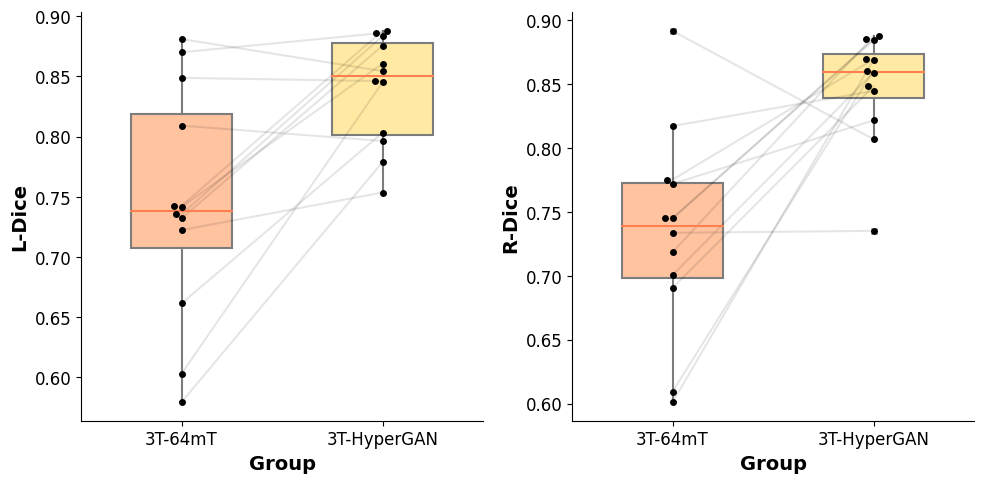

In [76]:

l_hifi_lofi_dice_list = []
l_hifi_recon_dice_list = []

r_hifi_lofi_dice_list = []
r_hifi_recon_dice_list = []

subject_list = []

original_images_path1 = '../source_data/new_subjects_2_19_2023'
original_images_path2 = '../source_data/old_subjects'

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_recon_t1_SynthSeg.nii.gz')
    
    if sub in os.listdir(original_images_path1):
        original_images_path = original_images_path1
    else:
        original_images_path = original_images_path2
    
    lofi_to_hifi_xfm_path = os.path.join(original_images_path,sub,'derivatives',
                                        'registered_images',sub+'_lofi_T1_to_hifi_t1_xfm.mat')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = ants.image_read(seg_lofi_path)        
        
        # hifi
        hifi_seg = ants.image_read(seg_hifi_path)
        
        # recon
        recon_seg = ants.image_read(seg_recon_path)
        
        # lofi to hifi xfm
        #lofi_seg_in_hifi = ants.apply_transforms(hifi_seg, lofi_seg, transformlist=lofi_to_hifi_xfm_path, interpolator='nearestNeighbor')
        
        #ants.image_write(lofi_seg_in_hifi,os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg_in_hifi_t1.nii.gz'))
        
        lofi_seg_in_hifi = ants.resample_image_to_target(lofi_seg, hifi_seg, interp_type='nearestNeighbor')
        
        # calculate the dice coefficients
        l_hifi_lofi_dice, r_hifi_lofi_dice = get_dice_structure(lofi_seg_in_hifi.numpy(), hifi_seg.numpy(), lr_thalamus)
        l_hifi_recon_dice, r_hifi_recon_dice = get_dice_structure(recon_seg.numpy(), hifi_seg.numpy(), lr_thalamus)
        
        l_hifi_lofi_dice_list.append(l_hifi_lofi_dice)
        r_hifi_lofi_dice_list.append(r_hifi_lofi_dice)
        
        l_hifi_recon_dice_list.append(l_hifi_recon_dice)
        r_hifi_recon_dice_list.append(r_hifi_recon_dice)
        
        subject_list.append(sub)
# plot
plot_dice(l_hifi_lofi_dice_list, r_hifi_lofi_dice_list, l_hifi_recon_dice_list, r_hifi_recon_dice_list, subject_list, 'Thalamus')

### Lateral Ventricles

Left Ventricle, Dice comparison one-sample t-test
3T-HyperGAN vs 3T-64mT:  Ttest_1sampResult(statistic=-2.9916303014059884, pvalue=0.012261911979618336)

Right Ventricle, one-sample t-test
3T-HyperGAN vs 3T-64mT:  Ttest_1sampResult(statistic=-3.5276923766182953, pvalue=0.0047340002254866636)


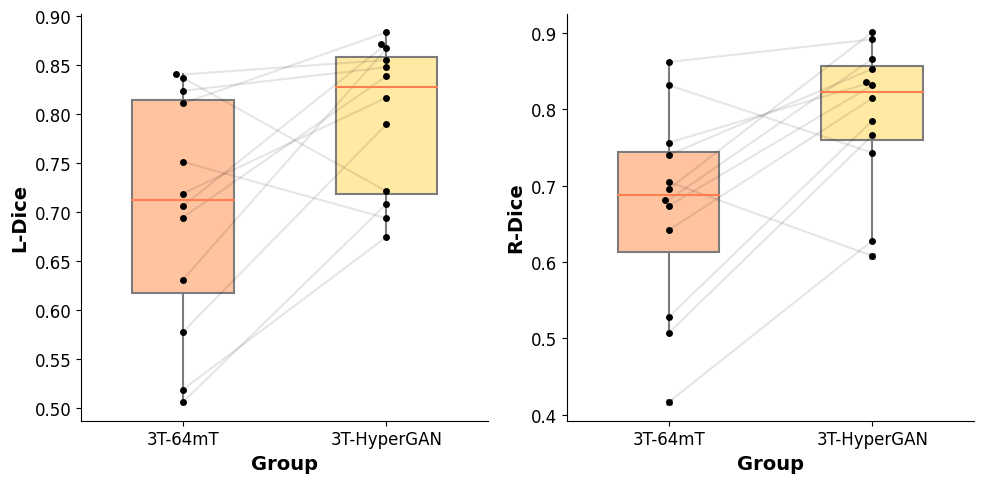

In [77]:
l_hifi_lofi_dice_list = []
l_hifi_recon_dice_list = []

r_hifi_lofi_dice_list = []
r_hifi_recon_dice_list = []

subject_list = []

original_images_path1 = '../source_data/new_subjects_2_19_2023'
original_images_path2 = '../source_data/old_subjects'

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_recon_t1_SynthSeg.nii.gz')
    
    if sub in os.listdir(original_images_path1):
        original_images_path = original_images_path1
    else:
        original_images_path = original_images_path2
    
    lofi_to_hifi_xfm_path = os.path.join(original_images_path,sub,'derivatives',
                                        'registered_images',sub+'_lofi_T1_to_hifi_t1_xfm.mat')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = ants.image_read(seg_lofi_path)        
        
        # hifi
        hifi_seg = ants.image_read(seg_hifi_path)
        
        # recon
        recon_seg = ants.image_read(seg_recon_path)
        
        # lofi to hifi xfm
        #lofi_seg_in_hifi = ants.apply_transforms(hifi_seg, lofi_seg, transformlist=lofi_to_hifi_xfm_path, interpolator='nearestNeighbor')
        
        #ants.image_write(lofi_seg_in_hifi,os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg_in_hifi_t1.nii.gz'))
        
        lofi_seg_in_hifi = ants.resample_image_to_target(lofi_seg, hifi_seg, interp_type='nearestNeighbor')
        
        # calculate the dice coefficients
        l_hifi_lofi_dice, r_hifi_lofi_dice = get_dice_structure(lofi_seg_in_hifi.numpy(), hifi_seg.numpy(), lr_lat_ventricles)
        l_hifi_recon_dice, r_hifi_recon_dice = get_dice_structure(recon_seg.numpy(), hifi_seg.numpy(), lr_lat_ventricles)
        
        l_hifi_lofi_dice_list.append(l_hifi_lofi_dice)
        r_hifi_lofi_dice_list.append(r_hifi_lofi_dice)
        
        l_hifi_recon_dice_list.append(l_hifi_recon_dice)
        r_hifi_recon_dice_list.append(r_hifi_recon_dice)
        
        subject_list.append(sub)
# plot
plot_dice(l_hifi_lofi_dice_list, r_hifi_lofi_dice_list, l_hifi_recon_dice_list, r_hifi_recon_dice_list, subject_list, 'Ventricle')

### Gray Matter

Left Gray Matter, Dice comparison one-sample t-test
3T-HyperGAN vs 3T-64mT:  Ttest_1sampResult(statistic=-6.58100378398084, pvalue=3.9647100950339825e-05)

Right Gray Matter, one-sample t-test
3T-HyperGAN vs 3T-64mT:  Ttest_1sampResult(statistic=-7.889516566315664, pvalue=7.453818807816906e-06)


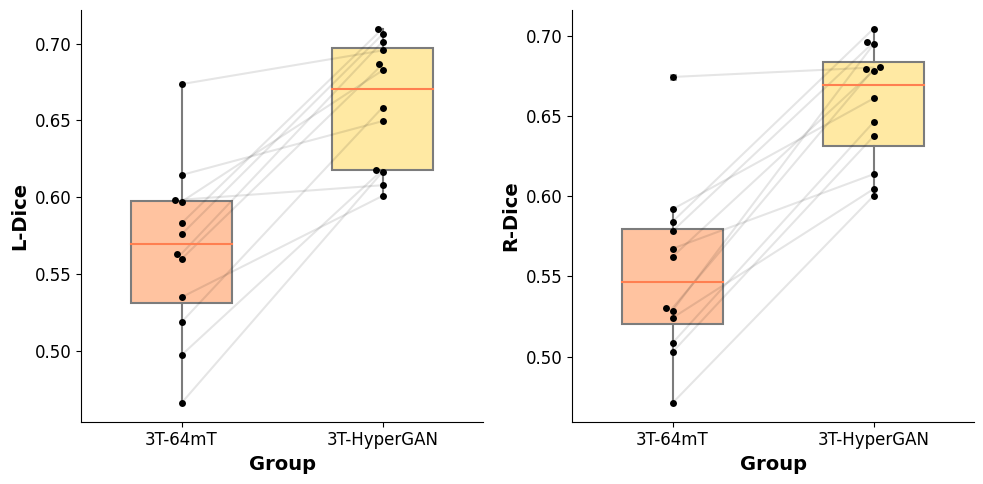

In [78]:
l_hifi_lofi_dice_list = []
l_hifi_recon_dice_list = []

r_hifi_lofi_dice_list = []
r_hifi_recon_dice_list = []

subject_list = []

original_images_path1 = '../source_data/new_subjects_2_19_2023'
original_images_path2 = '../source_data/old_subjects'

for sub in subjects:
    seg_lofi_path = os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg.nii.gz')
    seg_hifi_path = os.path.join(hifi_synthseg_outputs,sub+'_3T_SynthSeg.nii.gz')
    seg_recon_path = os.path.join(recon_synthseg_outputs,sub+'_recon_t1_SynthSeg.nii.gz')
    
    if sub in os.listdir(original_images_path1):
        original_images_path = original_images_path1
    else:
        original_images_path = original_images_path2
    
    lofi_to_hifi_xfm_path = os.path.join(original_images_path,sub,'derivatives',
                                        'registered_images',sub+'_lofi_T1_to_hifi_t1_xfm.mat')
    
    if os.path.exists(seg_lofi_path) & os.path.exists(seg_recon_path) & os.path.exists(seg_hifi_path):
        
        # lofi
        lofi_seg = ants.image_read(seg_lofi_path)        
        
        # hifi
        hifi_seg = ants.image_read(seg_hifi_path)
        
        # recon
        recon_seg = ants.image_read(seg_recon_path)
        
        # lofi to hifi xfm
        #lofi_seg_in_hifi = ants.apply_transforms(hifi_seg, lofi_seg, transformlist=lofi_to_hifi_xfm_path, interpolator='nearestNeighbor')
        
        #ants.image_write(lofi_seg_in_hifi,os.path.join(lofi_synthseg_outputs,sub+'_64mT_SynthSR_SynthSeg_in_hifi_t1.nii.gz'))
        
        lofi_seg_in_hifi = ants.resample_image_to_target(lofi_seg, hifi_seg, interp_type='nearestNeighbor')
        
        # calculate the dice coefficients
        l_hifi_lofi_dice, r_hifi_lofi_dice = get_dice_structure(lofi_seg_in_hifi.numpy(), hifi_seg.numpy(), lr_gm)
        l_hifi_recon_dice, r_hifi_recon_dice = get_dice_structure(recon_seg.numpy(), hifi_seg.numpy(), lr_gm)
        
        l_hifi_lofi_dice_list.append(l_hifi_lofi_dice)
        r_hifi_lofi_dice_list.append(r_hifi_lofi_dice)
        
        l_hifi_recon_dice_list.append(l_hifi_recon_dice)
        r_hifi_recon_dice_list.append(r_hifi_recon_dice)
        
        subject_list.append(sub)
# plot
plot_dice(l_hifi_lofi_dice_list, r_hifi_lofi_dice_list, l_hifi_recon_dice_list, r_hifi_recon_dice_list, subject_list, 'Gray Matter')